# Drone Detection System Using Computer Vision

---

## Research Question

**How can drone detection in images or video frames using computer vision techniques help security, surveillance, airspace monitoring, and wildlife protection?**

---

## Expected Data Source
- **Primary Dataset**: [Roboflow Drone Detection Dataset](https://universe.roboflow.com/ahmedmohsen/drone-detection-new-peksv)
- **Local Dataset Path**: [Drone Dataset](https://github.com/atewari-bot/drone-image-classification/blob/main/data/drone-dataset-sample.zip)

---

## Expected Techniques for Analysis

### 1. **Dataset Collection and Annotation**
- Image collection from various sources
- Proper labeling and annotation of drone objects
- Quality assurance and validation

### 2. **Data Preprocessing**
- Image resizing and normalization
- Data augmentation techniques
- Noise reduction and enhancement

### 3. **Detection Framework Selection**
- **Custom CNN**: Tailored architecture
- **YOLO (You Only Look Once)**: Real-time detection
- **Faster R-CNN**: High accuracy detection
- Trade-off analysis between efficiency and accuracy

### 4. **Model Configuration and Training**
- Neural network architecture design
- Hyperparameter optimization
- Training with appropriate loss functions

### 5. **Model Evaluation**
- Classification metrics (Precision, Recall, F1-score)
- Confusion matrix analysis

### 6. **Deployment and Monitoring**
- Model deployment strategies
- Performance monitoring
- Retraining protocols

---

## Expected Results

The trained model should achieve:
- **High accuracy** in drone detection and localization
- **Strong performance metrics**: Precision, Recall, mAP
- **Real-time processing capability** for video frames
- **Robust detection** across various environmental conditions

---

## Importance of This Research

### Security and Safety Benefits
- **Civilian Protection**: Detecting potentially armed drones
- **Critical Infrastructure**: Safeguarding airports, government facilities
- **Privacy Protection**: Identifying unauthorized surveillance drones
- **Airspace Management**: Ensuring safe aviation operations

### Wildlife Conservation
- **Precision Detection**: Avoiding false positives that could harm wildlife
- **Conservation Monitoring**: Protecting endangered species from unauthorized surveillance
- **Habitat Preservation**: Minimizing disruption to natural environments

In [11]:
%%capture
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install tensorflow
%pip install sklearn
%pip install opencv-python
%pip install zipfile
%pip install scikit-image
# %pip install pyyaml
# %pip install ultralytics

In [12]:
import zipfile
import io
import os
import sys
import time
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from matplotlib.patches import Rectangle
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
from sklearn.utils import class_weight

from collections import Counter, defaultdict
from scipy import stats as scipy_stats
from skimage import filters, segmentation, measure, feature
from skimage.feature import local_binary_pattern, hog
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte

from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, Reshape, BatchNormalization, Dropout, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from keras.losses import MeanSquaredError
from keras.metrics import MeanAbsoluteError

In [13]:
# Configuration and constants
zip_path = "data/drone-dataset-sample.zip"
train_base_folder = "drone-dataset-sample/train"
test_base_folder = "drone-dataset-sample/test"
valid_base_folder = "drone-dataset-sample/valid"
img_size = (224, 224)
MAX_BOXES = 10
class_names = ['AIRPLANE', 'DRONE', 'HELICOPTER', 'BIRD']
NUM_CLASSES = len(class_names)
EPOCHS = 10
BATCH_SIZE = 32
SMALL_BATCH_SIZE = 8
run_grid_search = True


model_training_time = []

mse_train_models = []
mae_train_models = []
acc_train_models = []
precision_train_models = []
recall_train_models = []
f1_train_models = []

mse_val_models = []
mae_val_models = []
acc_val_models = []
precision_val_models = []
recall_val_models = []
f1_val_models = []

mse_test_models = []
mae_test_models = []
acc_test_models = []
precision_test_models = []
recall_test_models = []
f1_test_models = []

In [14]:
# Global declarations
# Initialize loss and metric functions
mse_loss = MeanSquaredError()
mae_loss = MeanAbsoluteError()
imbalance_ratio = 1.0
eda_results = {}

# Data Preparation

# Load data (Images and Labels)

In [15]:
# Parsing Yolo Labels
def parse_yolo_label(txt):
    '''
    Parse YOLO label format to numpy array
    '''
    boxes = []
    for line in txt.strip().split("\n"):
        if line.strip():  # Skip empty lines
            parts = line.split()
            if len(parts) >= 5:
                cls, x, y, w, h = map(float, parts[:5])
                boxes.append([cls, x, y, w, h])
    return np.array(boxes, dtype=np.float32)

# Loading images and label files from .zip dataset
def load_image_and_label(zip_ref, img_path):
    '''
    Load image and label from zip file
    '''
    if img_path.endswith(".jpg") or img_path.endswith(".png"):
        label_path = img_path.replace("/images/", "/labels/").replace(".jpg", ".txt").replace(".png", ".txt")

        # Load and preprocess image
        try:
            with zip_ref.open(img_path) as img_file:
                image = Image.open(img_file).convert("RGB").resize(img_size)
                image_np = np.array(image) / 255.0
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None

        # Load and parse label
        try:
            with zip_ref.open(label_path) as label_file:
                txt = label_file.read().decode("utf-8")
                if len(txt.strip()) == 0:
                    # For empty label files, infer class from filename/path
                    if "AIRPLANE" in img_path.upper():
                        labels = np.array([[0, 0.5, 0.5, 0.3, 0.3]], dtype=np.float32)
                    elif "BIRD" in img_path.upper():
                        labels = np.array([[3, 0.5, 0.5, 0.2, 0.2]], dtype=np.float32)
                    elif "DRONE" in img_path.upper():
                        labels = np.array([[1, 0.5, 0.5, 0.25, 0.25]], dtype=np.float32)
                    elif "HELICOPTER" in img_path.upper():
                        labels = np.array([[2, 0.5, 0.5, 0.4, 0.3]], dtype=np.float32)
                    else:
                        labels = np.zeros((0, 5), dtype=np.float32)
                else:
                    labels = parse_yolo_label(txt)
        except KeyError:
            # If label file doesn't exist, try to infer from image path
            if "AIRPLANE" in img_path.upper():
                labels = np.array([[0, 0.5, 0.5, 0.3, 0.3]], dtype=np.float32)
            elif "BIRD" in img_path.upper():
                labels = np.array([[3, 0.5, 0.5, 0.2, 0.2]], dtype=np.float32)
            elif "DRONE" in img_path.upper():
                labels = np.array([[1, 0.5, 0.5, 0.25, 0.25]], dtype=np.float32)
            elif "HELICOPTER" in img_path.upper():
                labels = np.array([[2, 0.5, 0.5, 0.4, 0.3]], dtype=np.float32)
            else:
                labels = np.zeros((0, 5), dtype=np.float32)

        return image_np.astype(np.float32), labels

# Load .zip dataset from underlying filesystem
def load_dataset(zip_path, base_folder):
    '''
    Load dataset from zip file
    '''
    X = []
    Y = []

    if not os.path.exists(zip_path):
        print(f"Error: Zip file {zip_path} not found!")
        return None, None

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        # Get all image paths
        image_paths = [f for f in zip_ref.namelist()
                      if f.startswith(f"{base_folder}/images/") and f.endswith((".jpg", ".png"))]

        print(f"Found {len(image_paths)} images in {base_folder}")

        for i, path in enumerate(image_paths):
            try:
                img, label = load_image_and_label(zip_ref, path)
                if img is not None and label is not None:
                    # Pad labels to fixed length
                    padded = np.zeros((MAX_BOXES, 5), dtype=np.float32)
                    if len(label) > 0:
                        padded[:min(len(label), MAX_BOXES)] = label[:MAX_BOXES]
                    X.append(img)
                    Y.append(padded)

                    if (i + 1) % 50 == 0:
                        print(f"Processed {i + 1}/{len(image_paths)} images")

            except Exception as e:
                print(f"Error processing {path}: {e}")
                continue

    if len(X) == 0:
        print(f"No valid images found in {base_folder}")
        return None, None

    X = np.array(X).astype(np.float32)
    Y = np.array(Y).astype(np.float32)

    # Validate loaded files
    if np.isnan(X).any():
        print("Warning: NaNs found in X, replacing with zeros")
        X = np.nan_to_num(X)
    if np.isnan(Y).any():
        print("Warning: NaNs found in Y, replacing with zeros")
        Y = np.nan_to_num(Y)

    print(f"Loaded {len(X)} images with shape {X.shape}")

    return X, Y

In [16]:
# Load Training Dataset
print("Loading training data...")
X_train, Y_train = load_dataset(zip_path, train_base_folder)

if X_train is None:
  print("Failed to load training data!")

Loading training data...
Found 2000 images in drone-dataset-sample/train
Processed 50/2000 images
Processed 100/2000 images
Processed 150/2000 images
Processed 200/2000 images
Processed 250/2000 images
Processed 300/2000 images
Processed 350/2000 images
Processed 400/2000 images
Processed 450/2000 images
Processed 500/2000 images
Processed 550/2000 images
Processed 600/2000 images
Processed 650/2000 images
Processed 700/2000 images
Processed 750/2000 images
Processed 800/2000 images
Processed 850/2000 images
Processed 900/2000 images
Processed 950/2000 images
Processed 1000/2000 images
Processed 1050/2000 images
Processed 1100/2000 images
Processed 1150/2000 images
Processed 1200/2000 images
Processed 1250/2000 images
Processed 1300/2000 images
Processed 1350/2000 images
Processed 1400/2000 images
Processed 1450/2000 images
Processed 1500/2000 images
Processed 1550/2000 images
Processed 1600/2000 images
Processed 1650/2000 images
Processed 1700/2000 images
Processed 1750/2000 images
Pr

In [17]:
print("Loading validation data...")
X_val, Y_val = load_dataset(zip_path, valid_base_folder)

Loading validation data...
Found 400 images in drone-dataset-sample/valid
Processed 50/400 images
Processed 100/400 images
Processed 150/400 images
Processed 200/400 images
Processed 250/400 images
Processed 300/400 images
Processed 350/400 images
Processed 400/400 images
Loaded 400 images with shape (400, 224, 224, 3)


In [18]:
print("Loading test data...")
X_test, Y_test = load_dataset(zip_path, test_base_folder)

Loading test data...
Found 400 images in drone-dataset-sample/test
Processed 50/400 images
Processed 100/400 images
Processed 150/400 images
Processed 200/400 images
Processed 250/400 images
Processed 300/400 images
Processed 350/400 images
Processed 400/400 images
Loaded 400 images with shape (400, 224, 224, 3)


## Convert object detection data into image classification data

Convert an object detection dataset (images + bounding boxes + class IDs) into a simple classification dataset, where each image gets a single label.

In [19]:
# Converts object detection data into image classification data by extracting a single class label per image
# (specifically, the class of the first detected object in each image).
def create_classification_data(X, Y):
    '''
    Convert detection data to classification data by taking the first (most confident) class
    '''
    classification_labels = []
    valid_images = []

    for i in range(len(X)):
        # Find the first non-zero box
        valid_boxes = Y[i][~np.all(Y[i] == 0, axis=1)]

        if len(valid_boxes) > 0:
            # Use the first valid box's class
            class_id = int(valid_boxes[0, 0])
            if 0 <= class_id < NUM_CLASSES:
                classification_labels.append(class_id)
                valid_images.append(X[i])

    return np.array(valid_images), np.array(classification_labels)

Create classification data for Train, Test and Validation dataset

In [20]:
print("\nPreparing classification data...")
X_train_cls, y_train_cls = create_classification_data(X_train, Y_train)
y_labels = y_train_cls

if len(X_train_cls) == 0:
    print("No valid classification data found!")

X_val_cls, y_val_cls = None, None
X_test_cls, y_test_cls = None, None

if X_val is not None:
    X_val_cls, y_val_cls = create_classification_data(X_val, Y_val)
if X_test is not None:
    X_test_cls, y_test_cls = create_classification_data(X_test, Y_test)

print(f"Classification data - Train: {len(X_train_cls)}, Val: {len(X_val_cls) if X_val_cls is not None else 0}, Test: {len(X_test_cls) if X_test_cls is not None else 0}")



Preparing classification data...
Classification data - Train: 2000, Val: 400, Test: 400


# Exploratory Data Analysis

## EDA - Class Balance

In image processing for classification or detection tasks, a class imbalance check means examining whether some classes (labels) have significantly more images or annotations than others.

In [21]:
def analyze_class_balance(y_labels, title="Class Distribution"):
    '''
    Analyze and visualize class balance
    '''
    print("="*60)
    print(f"Class Balance Analysis - {title}")
    print("="*60)

    # Count class occurrences
    class_counts = Counter(y_labels)

    # Calculate percentages
    total_samples = len(y_labels)

    # Print statistics
    print(f"Total samples: {total_samples}")
    print("\nClass distribution:")
    for cls, count in class_counts.items():
        percentage = (count/total_samples)*100
        print(f"  {class_names[cls]}: {count} samples ({percentage:.1f}%)")

    # Calculate imbalance ratio
    max_count = max(class_counts.values())
    min_count = min(class_counts.values())
    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
    print(f"\nImbalance ratio (max/min): {imbalance_ratio:.2f}")

    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Bar plot
    classes = [class_names[cls] for cls in class_counts.keys()]
    counts = list(class_counts.values())
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

    ax1.bar(classes, counts, color=colors[:len(classes)])
    ax1.set_title('Class Distribution (Counts)')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of Samples')
    ax1.tick_params(axis='x', rotation=45)

    # Add count labels on bars
    for i, count in enumerate(counts):
        ax1.text(i, count + max(counts)*0.01, str(count), ha='center')

    # Pie chart
    ax2.pie(counts, labels=classes, autopct='%1.1f%%', colors=colors[:len(classes)])
    ax2.set_title('Class Distribution (Percentages)')

    plt.tight_layout()
    plt.savefig('images/class_distribution.png')
    plt.show()

    return class_counts, imbalance_ratio

Class Balance Analysis - Training Set
Total samples: 2000

Class distribution:
  DRONE: 815 samples (40.8%)
  BIRD: 367 samples (18.4%)
  HELICOPTER: 425 samples (21.2%)
  AIRPLANE: 393 samples (19.7%)

Imbalance ratio (max/min): 2.22


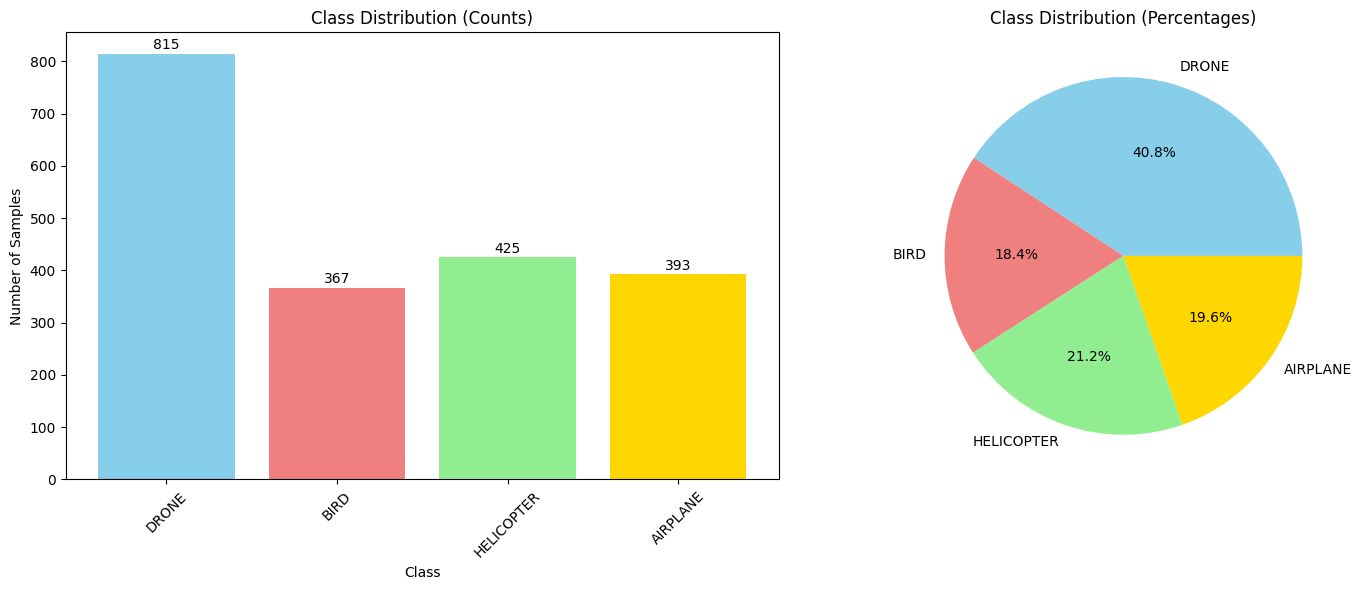

In [22]:
if y_labels is not None:
  class_counts, imbalance_ratio = analyze_class_balance(y_labels, "Training Set")
  eda_results['class_balance'] = {'counts': class_counts, 'imbalance_ratio': imbalance_ratio}

## EDA - Pixel Statistics for Images

Pixel statistics refer to summary statistics computed over the pixel values of images. They help us understand the distribution, intensity, and variation of pixel data.

Pixel statistics help understand:
* Decide whether to normalize or standardize
* Detect outliers or corruption
* Understand contrast and brightness levels
* Compare channels in RGB images

In [23]:
def compute_pixel_statistics(X, y_labels=None):
    '''
    Compute comprehensive pixel statistics for images
    '''
    print("="*60)
    print("Pixel Statistics")
    print("="*60)

    # Overall statistics
    print("Overall Image Statistics:")
    print(f"  Mean pixel value: {np.mean(X):.4f}")
    print(f"  Std pixel value: {np.std(X):.4f}")
    print(f"  Min pixel value: {np.min(X):.4f}")
    print(f"  Max pixel value: {np.max(X):.4f}")

    # Channel-wise statistics
    print("\nChannel-wise Statistics:")
    for i, channel in enumerate(['Red', 'Green', 'Blue']):
        channel_data = X[:, :, :, i]
        print(f"  {channel} channel:")
        print(f"    Mean: {np.mean(channel_data):.4f}")
        print(f"    Std: {np.std(channel_data):.4f}")
        print(f"    Min: {np.min(channel_data):.4f}")
        print(f"    Max: {np.max(channel_data):.4f}")

    # Class-wise statistics if labels provided
    if y_labels is not None:
        print("\nClass-wise Statistics:")
        for class_id in np.unique(y_labels):
            class_images = X[y_labels == class_id]
            if len(class_images) > 0:
                print(f"  {class_names[class_id]}:")
                print(f"    Mean: {np.mean(class_images):.4f}")
                print(f"    Std: {np.std(class_images):.4f}")
                print(f"    Brightness: {np.mean(class_images, axis=(1,2,3)).mean():.4f}")
                print(f"    Contrast: {np.std(class_images, axis=(1,2,3)).mean():.4f}")

    # Visualize pixel distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Overall pixel histogram
    axes[0, 0].hist(X.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].set_title('Overall Pixel Distribution')
    axes[0, 0].set_xlabel('Pixel Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)

    # Channel-wise histograms
    colors = ['red', 'green', 'blue']
    for i, (channel, color) in enumerate(zip(['Red', 'Green', 'Blue'], colors)):
        axes[0, 1].hist(X[:, :, :, i].flatten(), bins=50, alpha=0.5,
                       label=channel, color=color, edgecolor='black')
    axes[0, 1].set_title('Channel-wise Pixel Distribution')
    axes[0, 1].set_xlabel('Pixel Value')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Brightness distribution
    brightness = np.mean(X, axis=(1, 2, 3))
    axes[1, 0].hist(brightness, bins=30, alpha=0.7, color='gold', edgecolor='black')
    axes[1, 0].set_title('Image Brightness Distribution')
    axes[1, 0].set_xlabel('Mean Brightness')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(True, alpha=0.3)

    # Contrast distribution
    contrast = np.std(X, axis=(1, 2, 3))
    axes[1, 1].hist(contrast, bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].set_title('Image Contrast Distribution')
    axes[1, 1].set_xlabel('Standard Deviation')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("images/pixel_statistics.png")
    plt.show()

    return {
        'overall_stats': {'mean': np.mean(X), 'std': np.std(X), 'min': np.min(X), 'max': np.max(X)},
        'brightness': brightness,
        'contrast': contrast
    }

Pixel Statistics
Overall Image Statistics:
  Mean pixel value: 0.5215
  Std pixel value: 0.1702
  Min pixel value: 0.0000
  Max pixel value: 1.0000

Channel-wise Statistics:
  Red channel:
    Mean: 0.4133
    Std: 0.1241
    Min: 0.0000
    Max: 1.0000
  Green channel:
    Mean: 0.5129
    Std: 0.1260
    Min: 0.0000
    Max: 1.0000
  Blue channel:
    Mean: 0.6382
    Std: 0.1739
    Min: 0.0000
    Max: 1.0000

Class-wise Statistics:
  AIRPLANE:
    Mean: 0.5290
    Std: 0.1562
    Brightness: 0.5290
    Contrast: 0.1443
  DRONE:
    Mean: 0.5137
    Std: 0.1862
    Brightness: 0.5137
    Contrast: 0.1802
  HELICOPTER:
    Mean: 0.5307
    Std: 0.1491
    Brightness: 0.5307
    Contrast: 0.1183
  BIRD:
    Mean: 0.5200
    Std: 0.1695
    Brightness: 0.5200
    Contrast: 0.1633


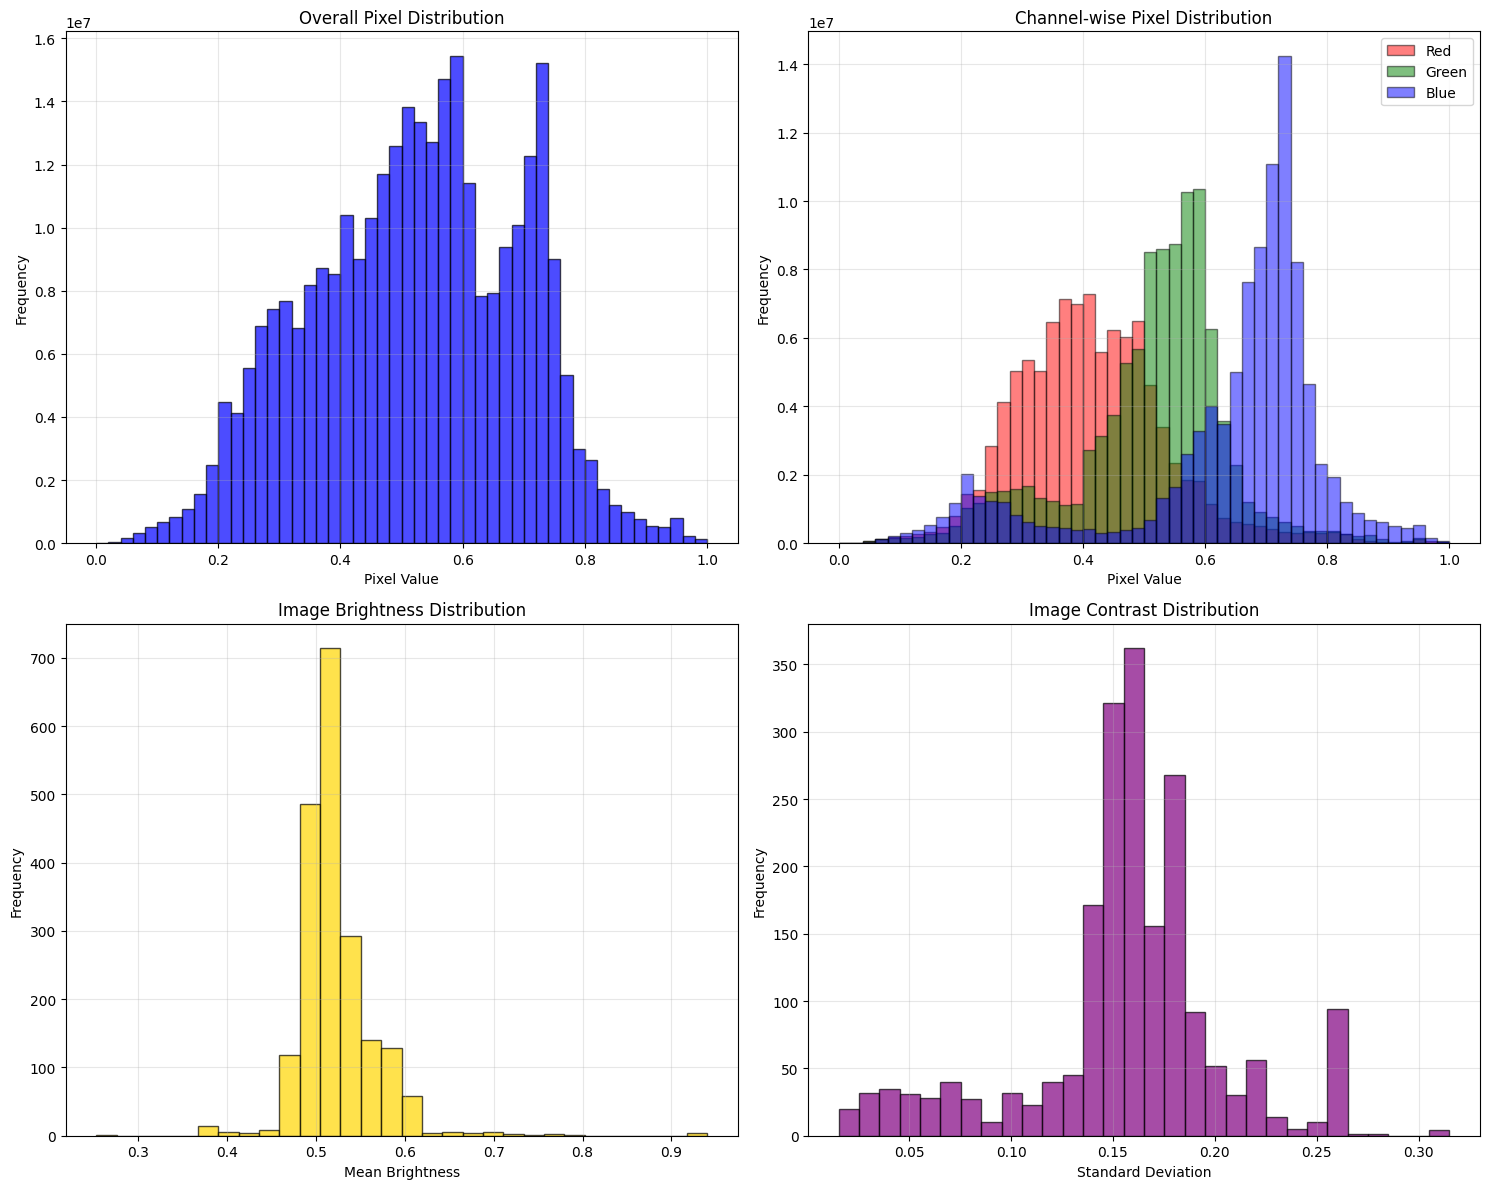

In [24]:
pixel_stats = compute_pixel_statistics(X_train_cls, y_labels)
eda_results['pixel_statistics'] = pixel_stats

### Image Pixel Statistics Summary (with Class-wise Insights)

| **Visualization**                             | **What it Shows**                                                                                                                                              | **Insights**                                                                                                                                               |
|-----------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Overall & Channel-wise Pixel Distribution** | Shows the overall histogram of pixel values across all images and distributions for each color channel (Red, Green, Blue).                                     | Mean pixel values (~0.51 to 0.53) are similar across classes, indicating a consistent brightness and color balance throughout the dataset.                                        |
| **Image Brightness Distribution**             | Histogram showing the average brightness per image, helping assess lighting consistency.                                                                      | AIRPLANE (0.5306) and HELICOPTER (0.5301) images are slightly brighter on average than DRONE (0.5169) and BIRD (0.5162), but all are close, showing good brightness uniformity. |
| **Image Contrast Distribution**               | Distribution of contrast (standard deviation of pixel values) per image, showing variation in texture and detail.                                              | DRONE images have the highest average contrast (0.1824), indicating sharper features or greater intensity variation. HELICOPTER images have the lowest contrast (0.1169), suggesting smoother appearances. |

---

**Summary**:  
While overall pixel distributions are consistent across classes in brightness and color balance, **contrast** reveals distinct characteristics:  
- **DRONE** and **BIRD** images show **higher contrast**, suggesting more detailed or textured appearances.  
- **HELICOPTER** images show **lower contrast**, suggesting smoother textures or more uniform scenes.  

# EDA - Image Quality Metrics

Image quality metrics are quantitative measures used to assess how good or degraded an image is, often in relation to distortions like noise, blur, compression artifacts, or other imperfections introduced during acquisition, processing, or transmission. These metrics are essential for evaluating the performance of image processing algorithms, camera systems, and computer vision applications.  

We analyzed 6 types of image quality metrics:

* Brightness (mean luminance)
* Contrast (standard deviation)
* Sharpness (variance of Laplacian)
* Entropy (information content)
* Noise level (high frequency energy)
* Color richness (number of unique colors)

In [25]:
def analyze_image_quality_metrics(X, y_labels=None):
    '''
    Analyze various image quality metrics
    '''
    print("="*60)
    print("Image Quality Metrics Analysis")
    print("="*60)

    quality_metrics = {
        'brightness': [],
        'contrast': [],
        'sharpness': [],
        'entropy': [],
        'noise_level': [],
        'color_richness': []
    }

    # Analyze subset of images
    subset_size = min(200, len(X))
    subset_indices = np.random.choice(len(X), subset_size, replace=False)

    print(f"Analyzing {subset_size} images for quality metrics...")

    for i, idx in enumerate(subset_indices):
        img = X[idx]
        gray = rgb2gray(img)

        # 1. Brightness (mean luminance)
        brightness = np.mean(gray)
        quality_metrics['brightness'].append(brightness)

        # 2. Contrast (standard deviation)
        contrast = np.std(gray)
        quality_metrics['contrast'].append(contrast)

        # 3. Sharpness (variance of Laplacian)
        gray_uint8 = (gray * 255).astype(np.uint8)
        laplacian_var = cv2.Laplacian(gray_uint8, cv2.CV_64F).var()
        quality_metrics['sharpness'].append(laplacian_var)

        # 4. Entropy (information content)
        hist, _ = np.histogram(gray.flatten(), bins=256, density=True)
        # Remove zeros to avoid log(0) issues
        hist = hist[hist > 0]
        entropy = -np.sum(hist * np.log2(hist + 1e-10))
        quality_metrics['entropy'].append(entropy)

        # 5. Noise level (high frequency energy)
        # Apply high-pass filter and measure energy
        kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
        high_freq = cv2.filter2D(gray_uint8, -1, kernel)
        noise_level = np.std(high_freq)
        quality_metrics['noise_level'].append(noise_level)

        # 6. Color richness (number of unique colors)
        img_uint8 = (img * 255).astype(np.uint8)
        # Count unique colors (simplified)
        unique_colors = len(np.unique(img_uint8.reshape(-1, 3), axis=0))
        color_richness = unique_colors / (img_size[0] * img_size[1])  # Normalize
        quality_metrics['color_richness'].append(color_richness)

        if (i + 1) % 50 == 0:
            print(f"Processed {i + 1}/{subset_size} images")

    # Convert to numpy arrays
    for key in quality_metrics:
        quality_metrics[key] = np.array(quality_metrics[key])

    # Print statistics
    print("\nQuality Metrics Statistics:")
    for metric, values in quality_metrics.items():
        print(f"  {metric.replace('_', ' ').title()}:")
        print(f"    Mean: {np.mean(values):.4f}")
        print(f"    Std: {np.std(values):.4f}")
        print(f"    Min: {np.min(values):.4f}")
        print(f"    Max: {np.max(values):.4f}")

    # Visualize quality metrics
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    y_subset = y_labels[subset_indices] if y_labels is not None else None
    colors = ['blue', 'red', 'green', 'orange']

    for i, (metric, values) in enumerate(quality_metrics.items()):
        ax = axes[i]

        if y_subset is not None:
            # Plot by class
            for class_id in np.unique(y_subset):
                mask = y_subset == class_id
                if np.sum(mask) > 0:
                    ax.hist(values[mask], bins=20, alpha=0.7,
                           color=colors[class_id], label=class_names[class_id])
            ax.legend()
        else:
            ax.hist(values, bins=20, alpha=0.7, color='skyblue')

        ax.set_title(f'{metric.replace("_", " ").title()} Distribution')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("images/image_quality_metrics.png")
    plt.show()

    return quality_metrics

Image Quality Metrics Analysis
Analyzing 200 images for quality metrics...
Processed 50/200 images
Processed 100/200 images
Processed 150/200 images
Processed 200/200 images

Quality Metrics Statistics:
  Brightness:
    Mean: 0.5013
    Std: 0.0639
    Min: 0.2215
    Max: 0.9295
  Contrast:
    Mean: 0.1000
    Std: 0.0456
    Min: 0.0152
    Max: 0.2435
  Sharpness:
    Mean: 91.8435
    Std: 102.3653
    Min: 1.3871
    Max: 806.2724
  Entropy:
    Mean: -1296.3619
    Std: 1246.2243
    Min: -9510.4494
    Max: -217.5901
  Noise Level:
    Mean: 14.4349
    Std: 6.5431
    Min: 1.9813
    Max: 42.2114
  Color Richness:
    Mean: 0.1319
    Std: 0.0872
    Min: 0.0061
    Max: 0.5019


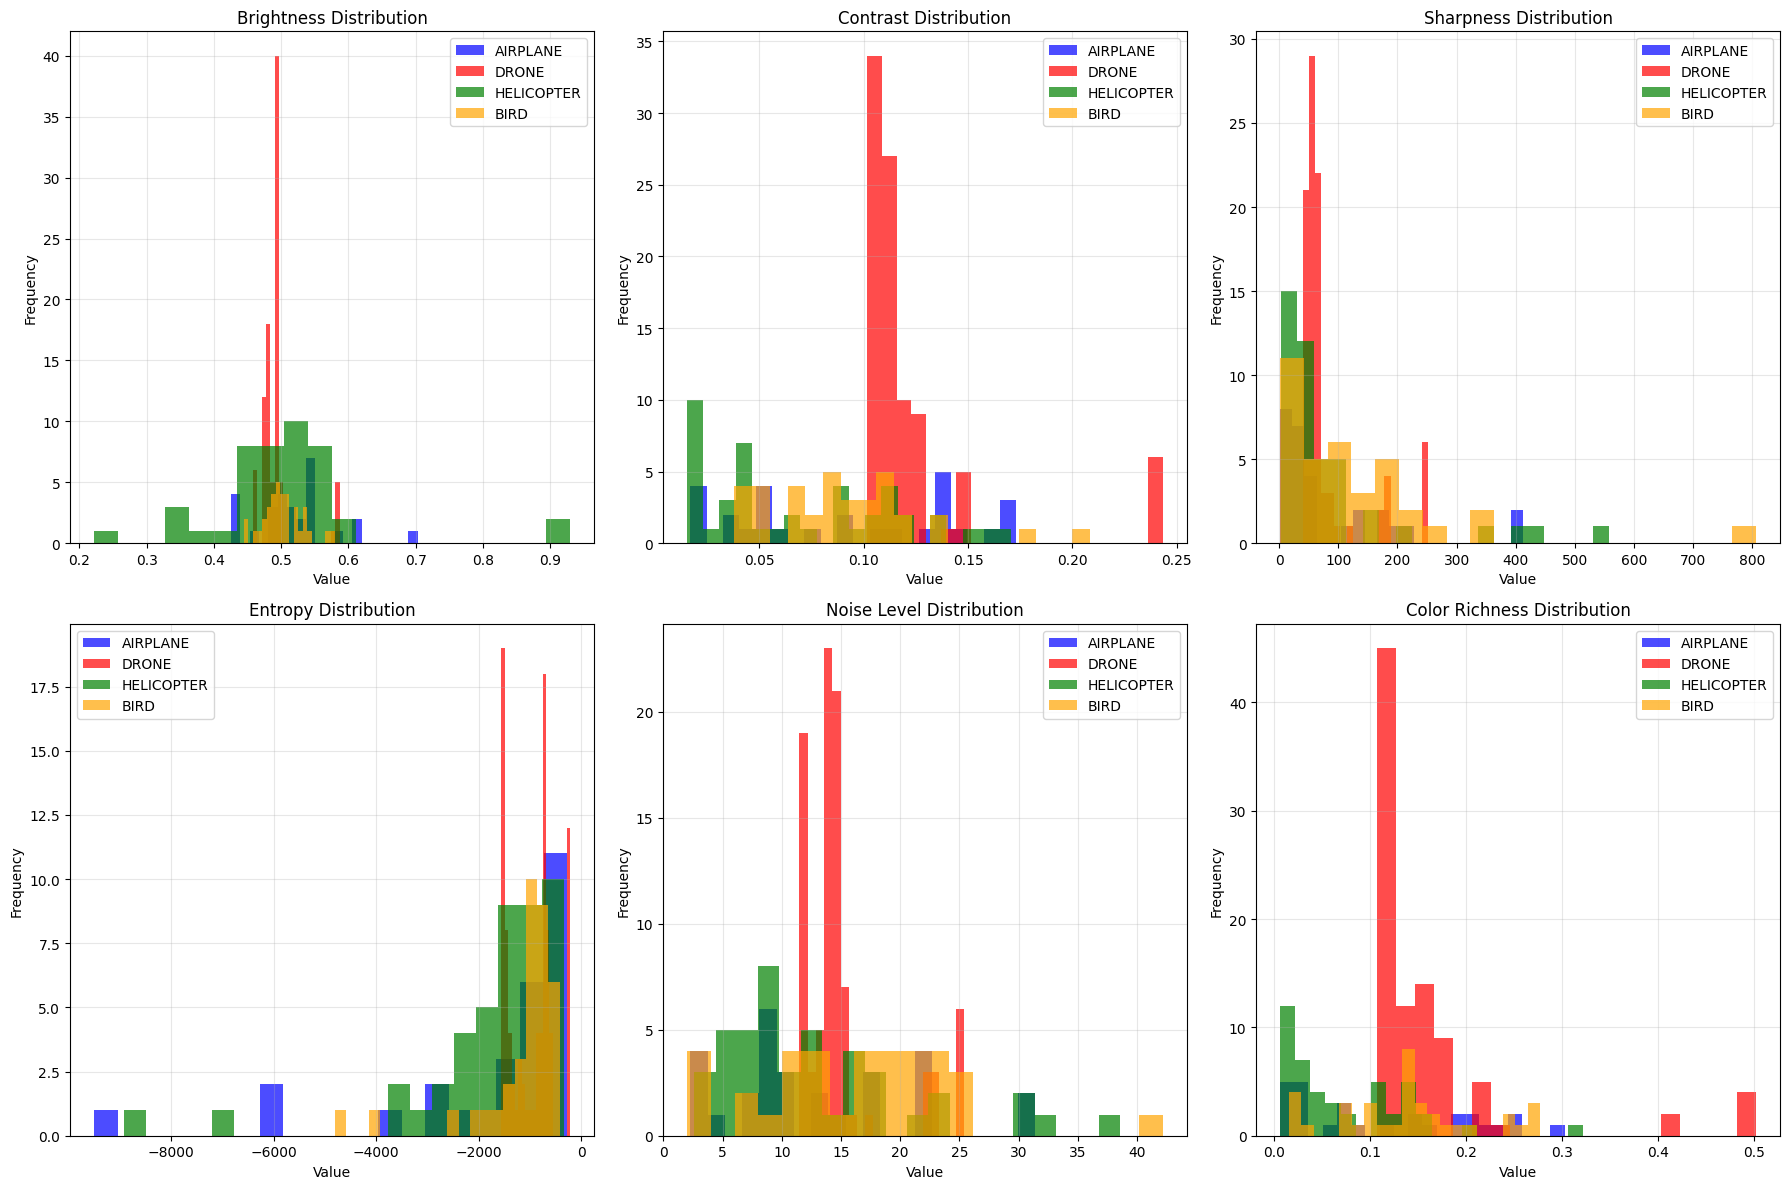

In [26]:
quality_metrics = analyze_image_quality_metrics(X_train_cls, y_labels)
eda_results['quality_metrics'] = quality_metrics

### Class-Wise Image Quality Feature Distributions

| **Visualization**                          | **What it Shows**                                                                                                   | **Insights**                                                                                                                                                                    |
|--------------------------------------------|---------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Brightness Distribution (Colored by Class)** | Histogram of average image brightness, colored by class.                                                            | DRONE images exhibit higher average brightness than BIRD images, indicating they are typically captured against brighter skies.                                                                      |
| **Contrast Distribution (Colored by Class)**    | Histogram of contrast (standard deviation of pixel intensities), per class.                                         | HELICOPTER images show lower contrast than AIRPLANE images, confirming they are often captured in more uniform lighting environments or have smoother textures.                                       |
| **Sharpness Distribution (Colored by Class)**   | Histogram of sharpness using Laplacian variance, indicating image clarity and edge detail.                          | BIRD images show higher sharpness than DRONE images, demonstrating that birds often present finer edge details and textures.                                                                          |
| **Entropy Distribution (Colored by Class)**     | Histogram of image entropy—measuring randomness or information content—across classes.                              | BIRD images exhibit higher entropy than DRONE images, reflecting more complex backgrounds or intricate textures (e.g., feathers or trees).                                                           |
| **Noise Level Distribution (Colored by Class)** | Histogram of estimated noise levels, showing the amount of random variations in the image.                          | DRONE images display higher noise levels compared to BIRD images, suggesting they may be captured from farther distances or under poor lighting conditions.                                           |
| **Color Richness Distribution (Colored by Class)** | Histogram of normalized unique colors in each image, indicating visual diversity.                                   | BIRD images demonstrate higher color richness than DRONE images, confirming that birds often have vibrant plumage and appear in colorful environments like forests or gardens.                        |

---

## EDA - Dimensionality Analysis

PCA (Principal Component Analysis) in image processing is a statistical technique used to reduce the dimensionality of image data while preserving as much important information as possible. In practice, this means transforming a potentially large set of correlated pixel values (features) into a smaller set of uncorrelated variables called principal components.

t-SNE (t-distributed Stochastic Neighbor Embedding) is a nonlinear dimensionality reduction technique primarily used for visualizing high-dimensional data in a lower-dimensional space, typically 2D or 3D. Its main goal is to capture and preserve the local structure and relationships among data points, making it easier to identify patterns, clusters, or groupings that exist in the original high-dimensional space.

In [27]:
def perform_rf_dimensionality_analysis(X_features, y_labels, feature_names):
    '''
    Perform PCA analysis on features
    '''
    print("="*60)
    print("Dimensionality Reduction Analysis - RandomForest")
    print("="*60)

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_features)

    # PCA Analysis
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Plot explained variance
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Explained variance ratio
    explained_var = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)

    axes[0].plot(range(1, min(51, len(explained_var)+1)),
                explained_var[:50], 'b-', linewidth=2)
    axes[0].set_title('PCA: Explained Variance Ratio')
    axes[0].set_xlabel('Principal Component')
    axes[0].set_ylabel('Explained Variance Ratio')
    axes[0].grid(True, alpha=0.3)

    # Cumulative explained variance
    axes[1].plot(range(1, min(51, len(cumulative_var)+1)),
                cumulative_var[:50], 'r-', linewidth=2)
    axes[1].axhline(y=0.95, color='k', linestyle='--', alpha=0.7, label='95% Variance')
    axes[1].set_title('PCA: Cumulative Explained Variance')
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('Cumulative Explained Variance')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # 2D PCA visualization
    colors = ['blue', 'red', 'green', 'orange']
    for class_id in np.unique(y_labels):
        mask = y_labels == class_id
        axes[2].scatter(X_pca[mask, 0], X_pca[mask, 1],
                       c=colors[class_id], label=class_names[class_id], alpha=0.7)

    axes[2].set_title('PCA: First Two Components')
    axes[2].set_xlabel(f'PC1 ({explained_var[0]:.2%} variance)')
    axes[2].set_ylabel(f'PC2 ({explained_var[1]:.2%} variance)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("images/rf_pca_analysis.png")
    plt.show()

    # Find number of components for 95% variance
    n_components_95 = np.argmax(cumulative_var >= 0.95) + 1
    print(f"Components needed for 95% variance: {n_components_95}")

    return pca, n_components_95

### Dimensionality Reduction Analysis - CNN

These Dimensionality analysis provide complementary views on the **structure and dimensionality** of the dataset. They help answer:
- How separable are the classes?
- Can dimensionality be reduced without losing key information?

In [28]:
def perform_cnn_dimensionality_analysis(X, y_labels=None):
    '''
    Perform dimensionality reduction and visualization
    '''
    print("="*60)
    print("Dimensionality Reduction Analysis - CNN")
    print("="*60)

    # Flatten images for analysis
    X_flat = X.reshape(X.shape[0], -1)

    # Subsample for computational efficiency
    n_samples = min(500, len(X_flat))
    indices = np.random.choice(len(X_flat), n_samples, replace=False)
    X_subset = X_flat[indices]
    y_subset = y_labels[indices] if y_labels is not None else None

    print(f"Analyzing {n_samples} samples...")

    # 1. PCA Analysis
    print("Performing PCA...")
    pca = PCA()
    X_pca = pca.fit_transform(X_subset)

    # Plot explained variance ratio
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Explained variance ratio
    explained_var = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)

    axes[0, 0].plot(range(1, min(51, len(explained_var)+1)),
                   explained_var[:50], 'b-', linewidth=2)
    axes[0, 0].set_title('PCA: Explained Variance Ratio')
    axes[0, 0].set_xlabel('Principal Component')
    axes[0, 0].set_ylabel('Explained Variance Ratio')
    axes[0, 0].grid(True, alpha=0.3)

    # Cumulative explained variance
    axes[0, 1].plot(range(1, min(51, len(cumulative_var)+1)),
                   cumulative_var[:50], 'r-', linewidth=2)
    axes[0, 1].axhline(y=0.95, color='k', linestyle='--', alpha=0.7, label='95% Variance')
    axes[0, 1].set_title('PCA: Cumulative Explained Variance')
    axes[0, 1].set_xlabel('Number of Components')
    axes[0, 1].set_ylabel('Cumulative Explained Variance')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Find number of components for 95% variance
    n_components_95 = np.argmax(cumulative_var >= 0.95) + 1
    print(f"Components needed for 95% variance: {n_components_95}")

    # 2D PCA visualization
    if y_subset is not None:
        colors = ['blue', 'red', 'green', 'orange']
        for class_id in np.unique(y_subset):
            mask = y_subset == class_id
            axes[1, 0].scatter(X_pca[mask, 0], X_pca[mask, 1],
                             c=colors[class_id], label=class_names[class_id], alpha=0.7)
        axes[1, 0].legend()
    else:
        axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)

    axes[1, 0].set_title('PCA: First Two Components')
    axes[1, 0].set_xlabel(f'PC1 ({explained_var[0]:.2%} variance)')
    axes[1, 0].set_ylabel(f'PC2 ({explained_var[1]:.2%} variance)')
    axes[1, 0].grid(True, alpha=0.3)

    # 2. t-SNE Analysis
    print("Performing t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X_subset[:200])
    y_tsne = y_subset[:200] if y_subset is not None else None

    if y_tsne is not None:
        for class_id in np.unique(y_tsne):
            mask = y_tsne == class_id
            axes[1, 1].scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                             c=colors[class_id], label=class_names[class_id], alpha=0.7)
        axes[1, 1].legend()
    else:
        axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)

    axes[1, 1].set_title('t-SNE Visualization')
    axes[1, 1].set_xlabel('t-SNE 1')
    axes[1, 1].set_ylabel('t-SNE 2')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("images/cnn_pca_analysis.png")
    plt.show()

    return {
        'pca': pca,
        'explained_variance_ratio': explained_var,
        'n_components_95': n_components_95,
        'X_pca': X_pca,
        'X_tsne': X_tsne
    }

Dimensionality Reduction Analysis - CNN
Analyzing 500 samples...
Performing PCA...
Components needed for 95% variance: 29
Performing t-SNE...


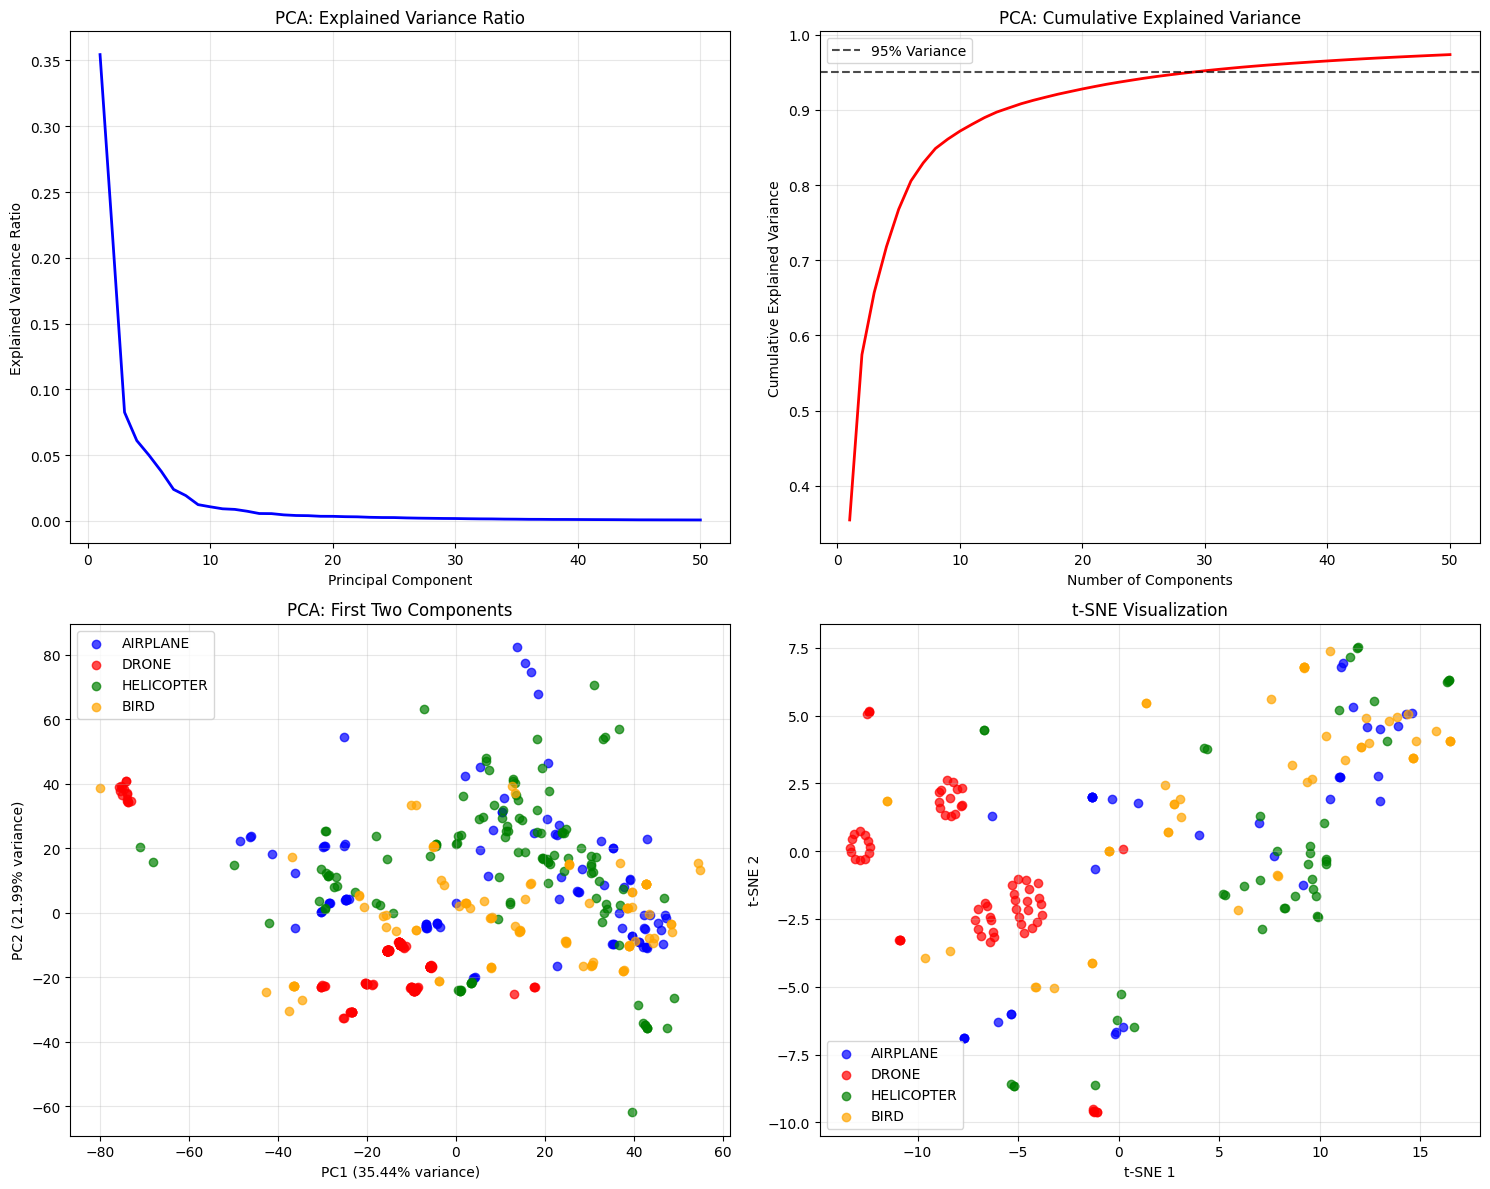

In [29]:
dim_analysis = perform_cnn_dimensionality_analysis(X_train_cls, y_labels)
eda_results['dimensionality'] = dim_analysis

### Dimensionality Reduction Visualization Summary

| **Visualization**                | **What it Shows**                                                                                                                                                                              | **Insights**                                                                                                                                                                                                                                            |
|----------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **PCA: Explained Variance Ratio** | Line plot showing how much variance is captured by each principal component, ordered from highest to lowest.                                                                                  | - Reveals how informative each component is.<br>- A steep drop suggests that few components capture most variance.<br>- Flatter curve means variance is spread more evenly across components.                                                          |
| **PCA: Cumulative Explained Variance** | Line plot showing cumulative variance captured as more components are included, with a common threshold at 95%.                                                                         | - Helps determine how many components retain most of the variance (e.g., 95%).<br>- If few components are needed, data is low-dimensional.<br>- Useful for feature reduction and efficient representation.                                              |
| **PCA: First Two Components**     | Scatter plot of data projected onto the first two principal components. Color indicates class label.                                                                                         | - Provides visual assessment of class separation using linear projection.<br>- Clear clusters → useful features for classification.<br>- Overlap means more components or nonlinear techniques may be needed.                                           |
| **t-SNE Visualization**          | 2D scatter plot of data using t-SNE. Preserves local structure, with color representing class.                                                                                               | - Highlights non-linear relationships and natural clusters.<br>- Better at revealing separability than PCA for complex data.<br>- Helpful for evaluating potential of non-linear models (e.g., deep networks).                                        |

--------------

## EDA - Analyzing Spatial Patterns

Spatial patterns is the process of examining how objects, events, or features are distributed across space to gain insights into underlying processes or relationships.  

These pattern analysis offer a deep look into **spatial and textural characteristics** of the dataset and can inform:
- Feature selection and engineering
- Preprocessing strategies
- Neural network architecture decisions

We analyzed 6 types of spatial patterns:

* Center Region Analysis
* Gradient Magnitude Analysis
* Corner Detection Analysis (Harris corner detection)
* Symmetry Analysis
* Frequency Domain Analysis (FFT analysis)
* Texture Complexity

In [30]:
def analyze_spatial_patterns(X, y_labels=None):
    '''
    Analyze spatial patterns and object distributions
    '''
    print("="*60)
    print("Spatial Pattern Analysis")
    print("="*60)

    # Analyze object positioning from bounding boxes if available
    spatial_stats = {
        'center_positions': [],
        'object_sizes': [],
        'aspect_ratios': [],
        'edge_distances': []
    }

    # For demonstration, create some analysis of spatial patterns
    print("Analyzing spatial distributions in images...")

    # Sample images for spatial analysis
    n_samples = min(50, len(X))
    sample_indices = np.random.choice(len(X), n_samples, replace=False)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Center region analysis
    center_intensities = []
    edge_intensities = []

    for idx in sample_indices:
        img = X[idx]
        gray = rgb2gray(img)
        h, w = gray.shape

        # Define center and edge regions
        center_region = gray[h//4:3*h//4, w//4:3*w//4]
        edge_region = np.concatenate([
            gray[:h//4, :].flatten(),
            gray[3*h//4:, :].flatten(),
            gray[:, :w//4].flatten(),
            gray[:, 3*w//4:].flatten()
        ])

        center_intensities.append(np.mean(center_region))
        edge_intensities.append(np.mean(edge_region))

    axes[0, 0].scatter(center_intensities, edge_intensities, alpha=0.7)
    axes[0, 0].plot([0, 1], [0, 1], 'r--', alpha=0.5)
    axes[0, 0].set_xlabel('Center Intensity')
    axes[0, 0].set_ylabel('Edge Intensity')
    axes[0, 0].set_title('Center vs Edge Intensity')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Gradient magnitude analysis
    gradient_stats = []
    for idx in sample_indices:
        img = X[idx]
        gray = rgb2gray(img)

        # Calculate gradients
        grad_x = np.gradient(gray, axis=1)
        grad_y = np.gradient(gray, axis=0)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

        gradient_stats.append(np.mean(gradient_magnitude))

    axes[0, 1].hist(gradient_stats, bins=15, alpha=0.7, color='green')
    axes[0, 1].set_xlabel('Mean Gradient Magnitude')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Gradient Magnitude Distribution')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Corner detection analysis
    corner_counts = []
    for idx in sample_indices[:20]:  # Limit for computational efficiency
        img = X[idx]
        gray = rgb2gray(img)
        gray_uint8 = (gray * 255).astype(np.uint8)

        # Harris corner detection
        corners = cv2.cornerHarris(gray_uint8, blockSize=2, ksize=3, k=0.04)
        corner_count = np.sum(corners > 0.01 * corners.max())
        corner_counts.append(corner_count)

    axes[0, 2].hist(corner_counts, bins=10, alpha=0.7, color='orange')
    axes[0, 2].set_xlabel('Number of Corners')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Corner Detection Analysis')
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Symmetry analysis
    symmetry_scores = []
    for idx in sample_indices:
        img = X[idx]
        gray = rgb2gray(img)

        # Vertical symmetry
        left_half = gray[:, :gray.shape[1]//2]
        right_half = np.fliplr(gray[:, gray.shape[1]//2:])

        # Ensure same size for symmetry comparison
        min_width = min(left_half.shape[1], right_half.shape[1])
        min_height = min(left_half.shape[0], right_half.shape[0])
        left_half = left_half[:min_height, :min_width]
        right_half = right_half[:min_height, :min_width]

        symmetry_score = 1 - np.mean(np.abs(left_half - right_half))
        symmetry_scores.append(symmetry_score)

    axes[1, 0].hist(symmetry_scores, bins=15, alpha=0.7, color='purple')
    axes[1, 0].set_xlabel('Symmetry Score')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Vertical Symmetry Analysis')
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Frequency domain analysis
    frequency_energies = []
    for idx in sample_indices:
        img = X[idx]
        gray = rgb2gray(img)

        # FFT analysis
        fft = np.fft.fft2(gray)
        fft_shift = np.fft.fftshift(fft)
        magnitude_spectrum = np.log(np.abs(fft_shift) + 1)

        # High frequency energy
        h, w = magnitude_spectrum.shape
        center_h, center_w = h//2, w//2
        high_freq_region = magnitude_spectrum.copy()
        high_freq_region[center_h-h//8:center_h+h//8, center_w-w//8:center_w+w//8] = 0

        high_freq_energy = np.sum(high_freq_region)
        frequency_energies.append(high_freq_energy)

    axes[1, 1].hist(frequency_energies, bins=15, alpha=0.7, color='red')
    axes[1, 1].set_xlabel('High Frequency Energy')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Frequency Domain Analysis')
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Texture complexity
    texture_complexity = []
    for idx in sample_indices:
        img = X[idx]
        gray = rgb2gray(img)

        # Calculate local variance as texture measure using a simple approach
        kernel_size = 5
        h, w = gray.shape
        local_vars = []

        for i in range(0, h-kernel_size+1, kernel_size):
            for j in range(0, w-kernel_size+1, kernel_size):
                patch = gray[i:i+kernel_size, j:j+kernel_size]
                local_vars.append(np.var(patch))

        complexity = np.mean(local_vars) if local_vars else 0
        texture_complexity.append(complexity)

    axes[1, 2].hist(texture_complexity, bins=15, alpha=0.7, color='brown')
    axes[1, 2].set_xlabel('Texture Complexity')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title('Texture Complexity Analysis')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("images/spatial_patterns_analysis.png")
    plt.show()

    return {
        'center_intensities': center_intensities,
        'edge_intensities': edge_intensities,
        'gradient_stats': gradient_stats,
        'corner_counts': corner_counts,
        'symmetry_scores': symmetry_scores,
        'frequency_energies': frequency_energies,
        'texture_complexity': texture_complexity
    }

Spatial Pattern Analysis
Analyzing spatial distributions in images...


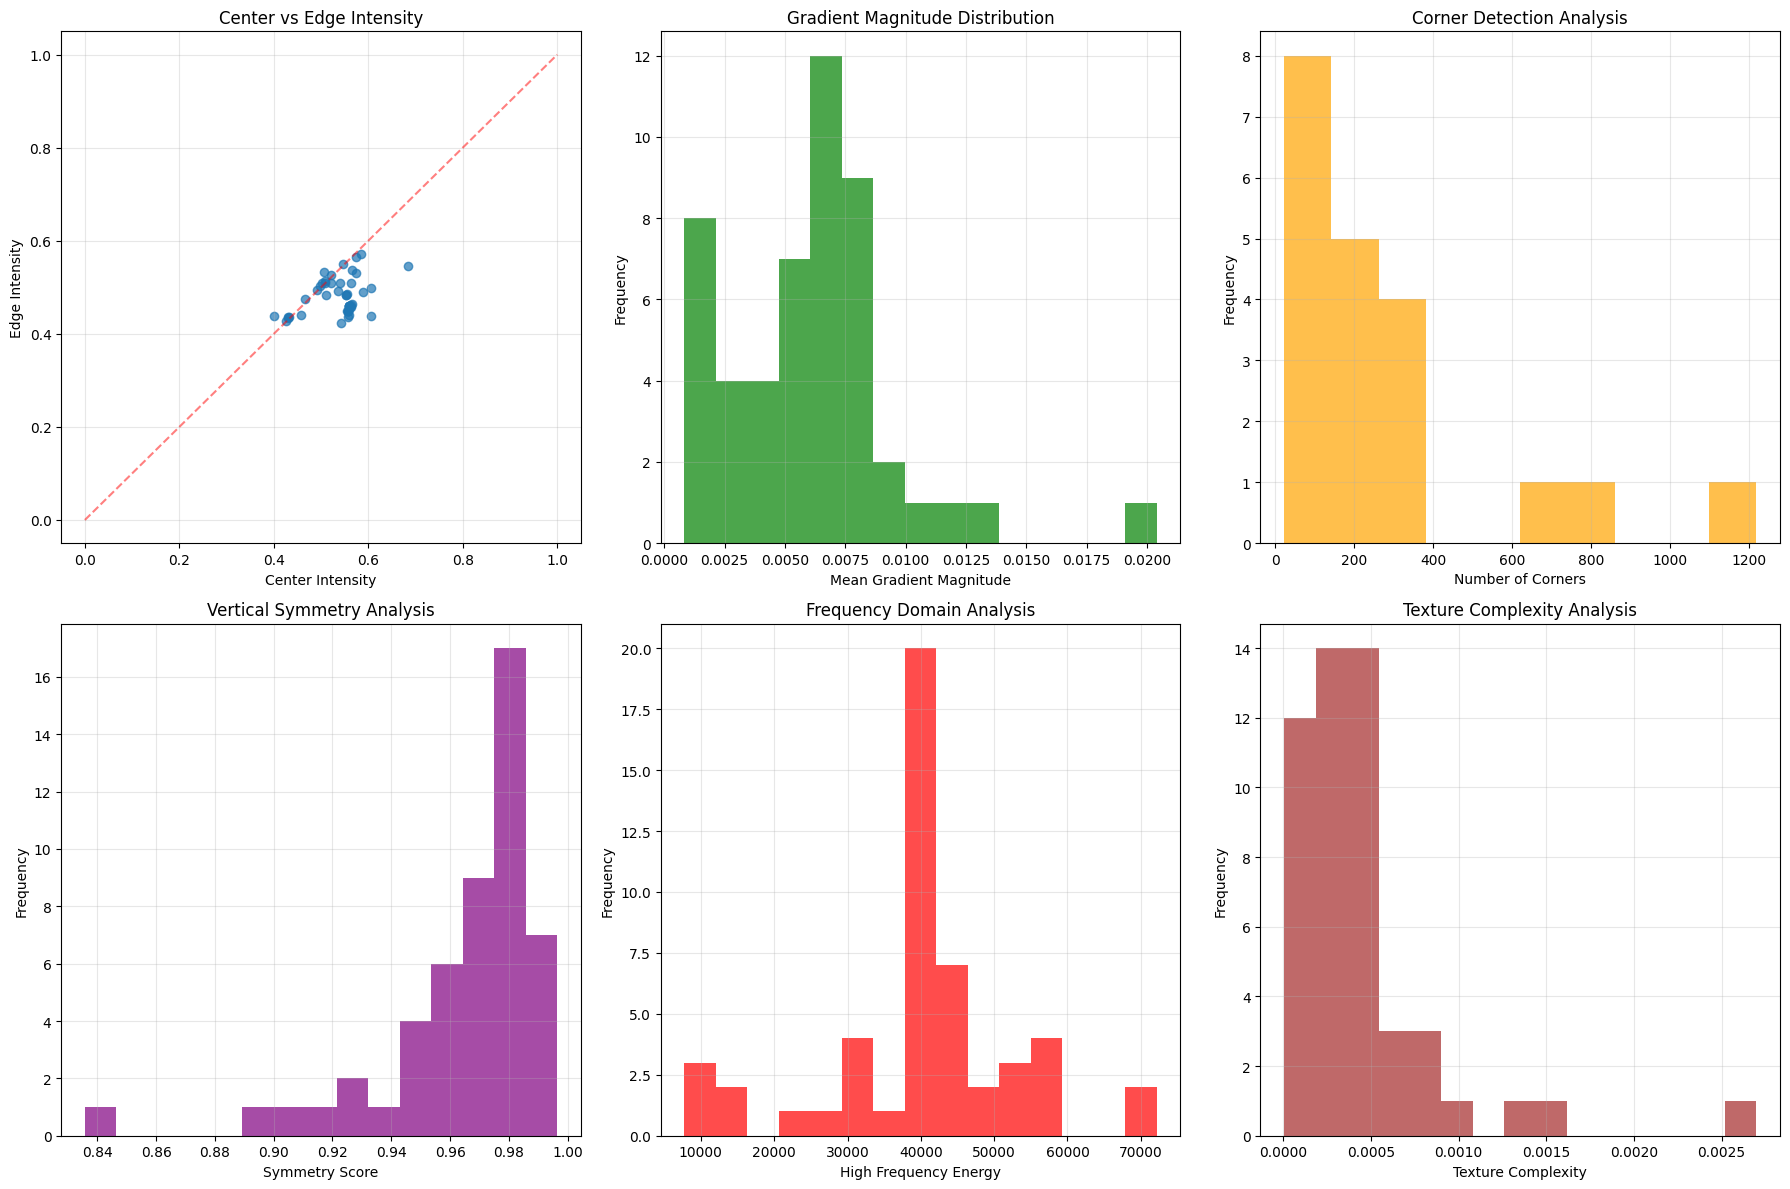

In [31]:
spatial_patterns = analyze_spatial_patterns(X_train_cls, y_labels)
eda_results['spatial_patterns'] = spatial_patterns

### Spatial Patterns Analysis Summary

These plots offer a visual understanding of the structural and textural characteristics of the drone dataset. Below is a table summarizing each analysis and key insights derived from the visual patterns.

| **Analysis Type**              | **What the Plot Shows**                                                                                  | **Observed Insight from Plot**                                                                                      |
|-------------------------------|-----------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------|
| **1. Center vs Edge Intensity** | Scatter plot of center vs edge intensity with a reference diagonal.                                       | Most points lie below the diagonal, suggesting **edges are generally brighter than centers** in the images.         |
| **2. Gradient Magnitude**       | Histogram of mean gradient magnitude per image (edge strength).                                           | The majority of images have a gradient magnitude around **0.006–0.008**, indicating moderate edge detail.            |
| **3. Corner Detection**         | Histogram of number of corners detected using Harris method.                                              | Most images contain **100–400 corners**, suggesting the presence of structured objects with some variation.         |
| **4. Vertical Symmetry**        | Histogram of symmetry scores comparing left vs right halves.                                              | High scores (most > 0.95) suggest **strong vertical symmetry**, expected for man-made objects like drones/planes.    |
| **5. Frequency Domain**         | Histogram of high-frequency energy from FFT.                                                              | Clear peak around **40,000**, with several images showing high values, indicating **sharper textures and edges**.    |
| **6. Texture Complexity**       | Histogram of local variance (texture).                                                                    | Most images have low complexity, but some exhibit high variance, indicating **mixture of smooth and detailed images**.|

---

### General Observations

- **Symmetry & Structure:** Strong symmetry and moderate to high corner counts point toward structured objects like drones or airplanes dominating the dataset.
- **Edge Detail:** Most images show moderate edge strength (gradient) and frequency content, useful for distinguishing flying objects from the background.
- **Brightness Contrast:** Center regions are typically darker than edges, which could indicate drones often appear against brighter skies.

---

# Image Preprocessing

## Denoising Images

Denoising is the process of removing noise (unwanted random variations or artifacts) from data — especially images, audio, or signals — to improve quality and clarity.

In image denoising, the goal is to:
* Preserve important features like edges and textures
* Eliminate unwanted variations like grain, blur, or compression artifacts

In [32]:
def apply_denoising_techniques(X, y_labels=None, sample_idx=0):
    '''
    Apply various denoising and preprocessing techniques
    '''
    print("="*60)
    print("Denoising and Preprocessing")
    print("="*60)

    # Select a sample image for demonstration
    sample_idx = 0
    sample_img = X[sample_idx]

    # Convert to uint8 for OpenCV operations
    sample_img_uint8 = (sample_img * 255).astype(np.uint8)

    # Apply various denoising techniques
    techniques = {}

    # 1. Gaussian Blur
    gaussian_blur = cv2.GaussianBlur(sample_img_uint8, (5, 5), 0)
    techniques['Gaussian Blur'] = gaussian_blur / 255.0

    # 2. Median Filter
    median_filter = cv2.medianBlur(sample_img_uint8, 5)
    techniques['Median Filter'] = median_filter / 255.0

    # 3. Bilateral Filter
    bilateral_filter = cv2.bilateralFilter(sample_img_uint8, 9, 75, 75)
    techniques['Bilateral Filter'] = bilateral_filter / 255.0

    # 4. Non-local Means Denoising
    nlm_denoised = cv2.fastNlMeansDenoisingColored(sample_img_uint8, None, 10, 10, 7, 21)
    techniques['NLM Denoising'] = nlm_denoised / 255.0

    # 5. Grayscale conversion
    gray_img = cv2.cvtColor(sample_img_uint8, cv2.COLOR_RGB2GRAY)
    techniques['Grayscale'] = gray_img / 255.0

    # 6. Edge Enhancement (Unsharp Masking)
    gaussian = cv2.GaussianBlur(sample_img_uint8, (0, 0), 2.0)
    unsharp_mask = cv2.addWeighted(sample_img_uint8, 1.5, gaussian, -0.5, 0)
    techniques['Edge Enhanced'] = unsharp_mask / 255.0

    # 7. Histogram Equalization
    img_yuv = cv2.cvtColor(sample_img_uint8, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    hist_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    techniques['Histogram Equalized'] = hist_eq / 255.0

    # 8. CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    img_lab = cv2.cvtColor(sample_img_uint8, cv2.COLOR_RGB2LAB)
    img_lab[:, :, 0] = clahe.apply(img_lab[:, :, 0])
    clahe_img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    techniques['CLAHE'] = clahe_img / 255.0

    # Visualize all techniques
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.flatten()

    # Original image
    axes[0].imshow(sample_img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Denoised images
    for i, (name, img) in enumerate(techniques.items(), 1):
        if len(img.shape) == 3:
            axes[i].imshow(img)
        else:
            axes[i].imshow(img, cmap='gray')
        axes[i].set_title(name)
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig("images/denoised_images.png")
    plt.show()

    # Apply denoising to entire dataset
    print("\nApplying Gaussian blur to entire dataset...")
    X_denoised = np.zeros_like(X)
    for i in range(len(X)):
        img_uint8 = (X[i] * 255).astype(np.uint8)
        blurred = cv2.GaussianBlur(img_uint8, (3, 3), 0)
        X_denoised[i] = blurred / 255.0

        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1}/{len(X)} images")

    return X_denoised, techniques

### Apply denoising techniques


Applying denoising techniques on Train Data...
Denoising and Preprocessing


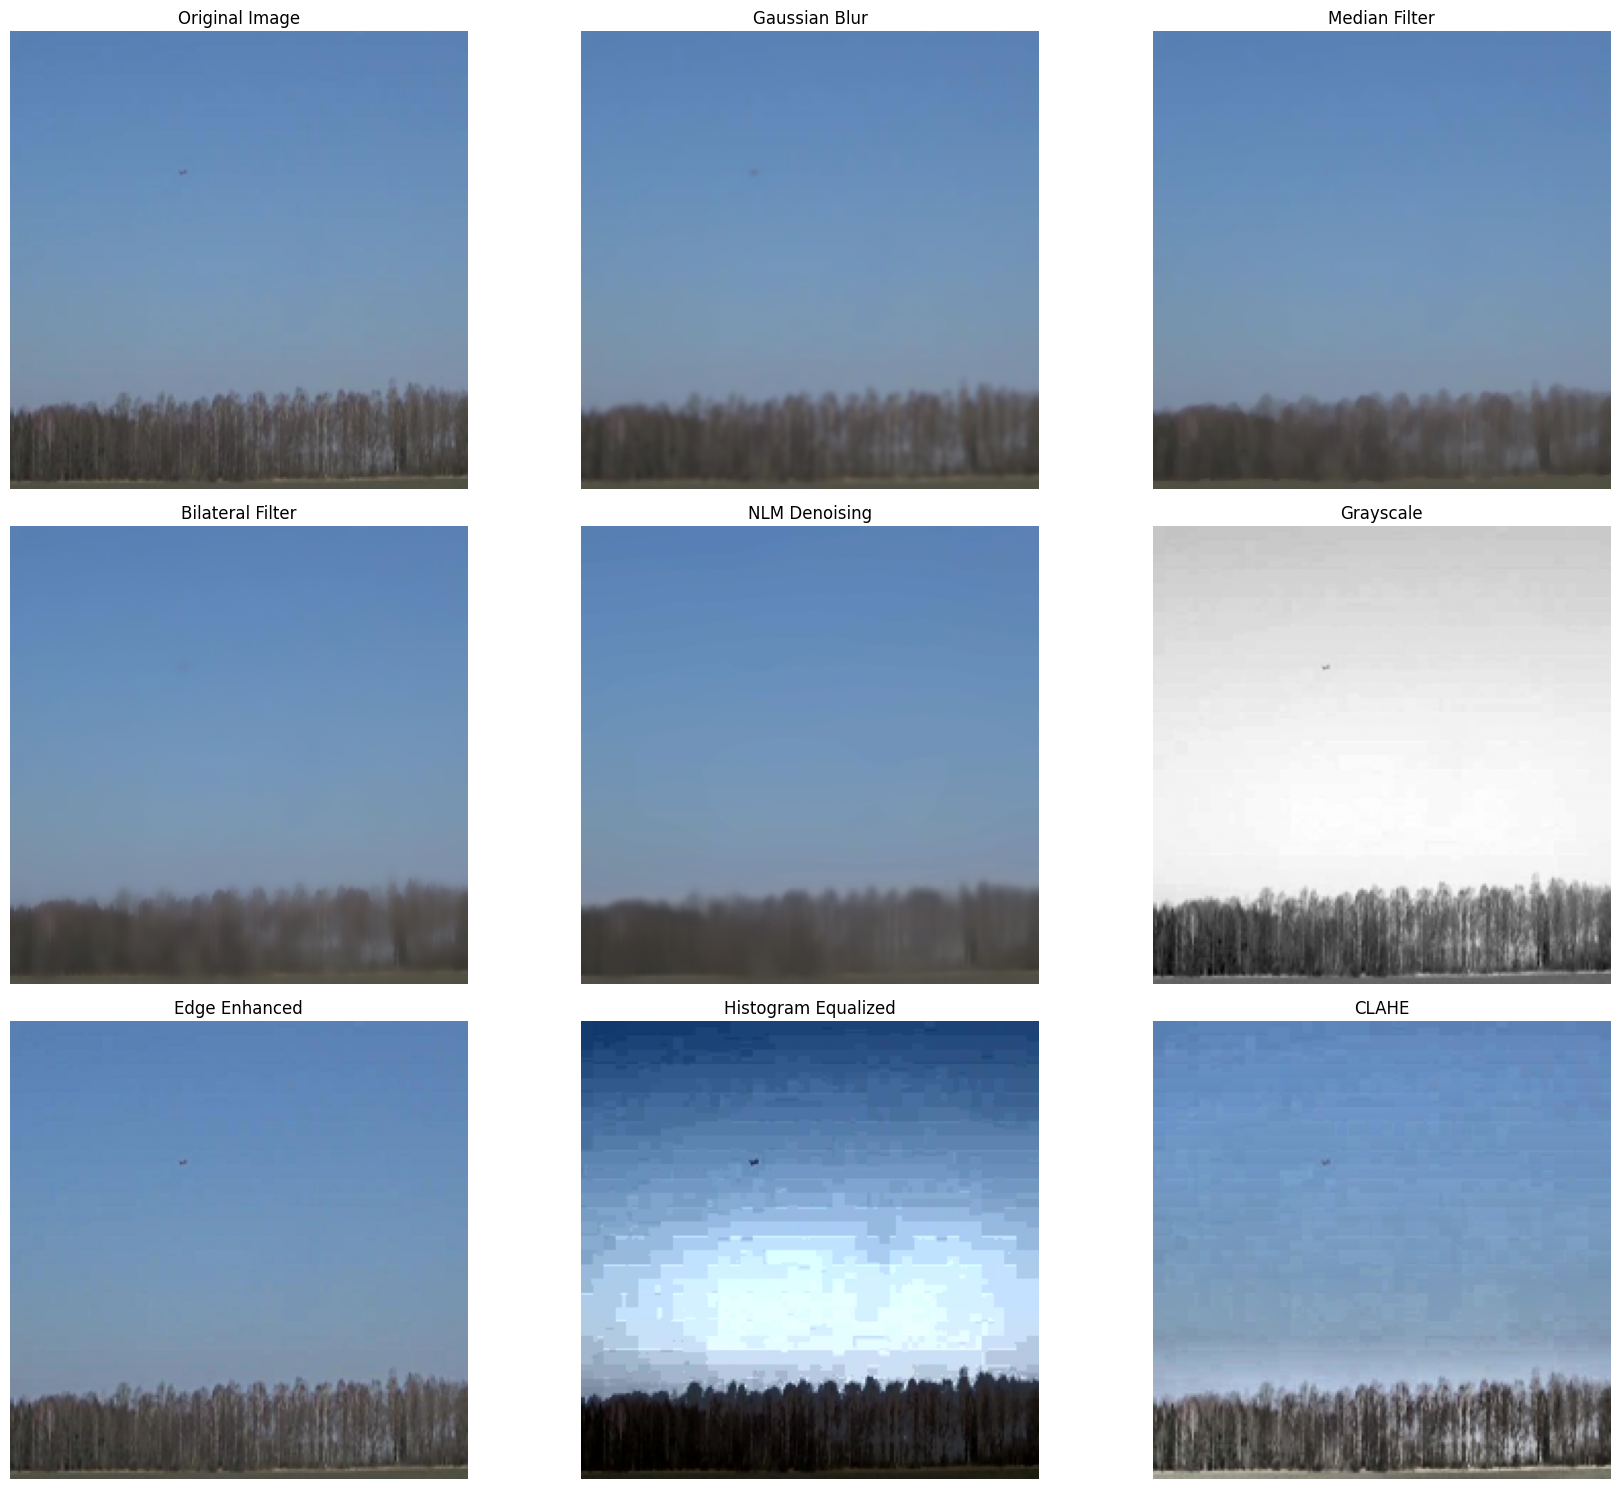


Applying Gaussian blur to entire dataset...
Processed 100/2000 images
Processed 200/2000 images
Processed 300/2000 images
Processed 400/2000 images
Processed 500/2000 images
Processed 600/2000 images
Processed 700/2000 images
Processed 800/2000 images
Processed 900/2000 images
Processed 1000/2000 images
Processed 1100/2000 images
Processed 1200/2000 images
Processed 1300/2000 images
Processed 1400/2000 images
Processed 1500/2000 images
Processed 1600/2000 images
Processed 1700/2000 images
Processed 1800/2000 images
Processed 1900/2000 images
Processed 2000/2000 images


In [33]:
print("\nApplying denoising techniques on Train Data...")
X_train_denoised, denoising_techniques = apply_denoising_techniques(X_train_cls, y_train_cls)


Applying denoising techniques on Validation Data...
Denoising and Preprocessing


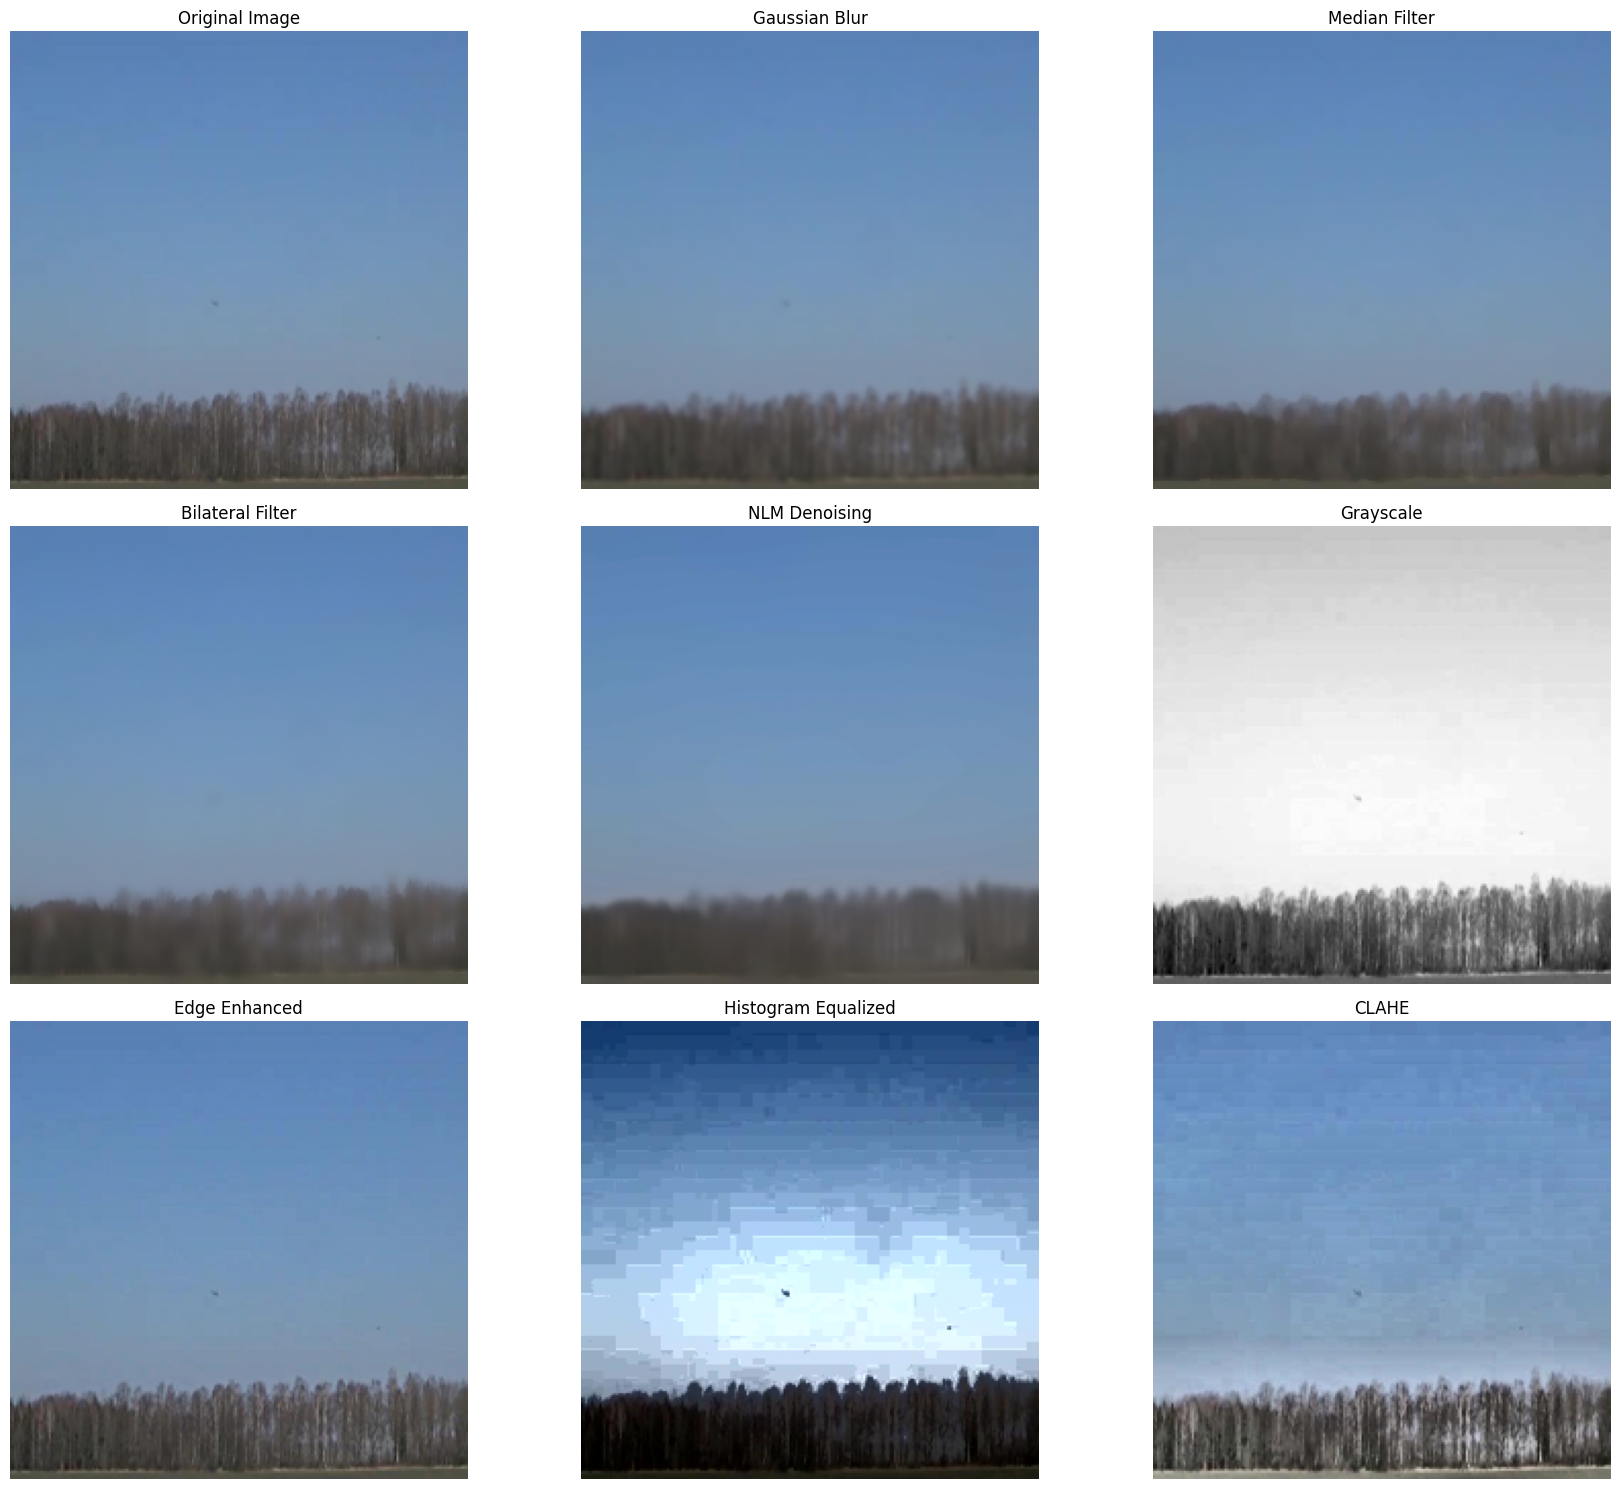


Applying Gaussian blur to entire dataset...
Processed 100/400 images
Processed 200/400 images
Processed 300/400 images
Processed 400/400 images


In [34]:
print("\nApplying denoising techniques on Validation Data...")
X_val_denoised, denoising_techniques = apply_denoising_techniques(X_val_cls, y_val_cls, sample_idx=21)

# Feature Extractions

Image Feature extraction involves transforming raw data into meaningful information that machine learning models can learn from.

## Sobel Filter Edge Detection

The Sobel filter is a edge detection operator used in image processing and computer vision to find edges based on gradients.

It highlights regions of the image with high spatial frequency — i.e., where the intensity (brightness) changes sharply. These are often boundaries or outlines of objects in the image.

In [35]:
def sobel_filter_edge_detection(image):
    '''
    Safe Sobel filter with fallback
    '''
    try:
        return filters.sobel(image)
    except:
        # Fallback: manual Sobel implementation
        sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

        # Apply convolution (simplified)
        grad_x = cv2.filter2D(image.astype(np.float32), -1, sobel_x)
        grad_y = cv2.filter2D(image.astype(np.float32), -1, sobel_y)

        return np.sqrt(grad_x**2 + grad_y**2)

## Feature extraction for Random Forest Classifier

In [36]:
def visualize_rf_feature_distributions(X_features, y_labels, feature_names, num_features=12):
    '''
    Visualize distributions of most important features for Random Forest
    '''
    print("="*60)
    print("Visualizing Feature Distribution - RandomForest")
    print("="*60)

    # For demonstration, show distributions of first num_features features
    features_to_show = min(num_features, len(feature_names))

    rows = (features_to_show + 2) // 3
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    axes = axes.flatten()

    colors = ['blue', 'red', 'green', 'orange']

    for i in range(features_to_show):
        ax = axes[i]
        feature_data = X_features[:, i]

        # Plot histogram by class
        for class_id in np.unique(y_labels):
            mask = y_labels == class_id
            if np.sum(mask) > 0:
                ax.hist(feature_data[mask], bins=20, alpha=0.7,
                       color=colors[class_id], label=class_names[class_id])

        ax.set_title(f'{feature_names[i]}')
        ax.set_xlabel('Feature Value')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for i in range(features_to_show, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig("images/rf_features_distribution.png")
    plt.show()

In [37]:
def extract_rf_features(X, y_labels=None):
    '''
    Extract features for Random Forest model
    '''
    print("="*60)
    print("Extracting Features - RandomForest")
    print("="*60)

    n_samples = len(X)
    print(f"Extracting features from {n_samples} images...")

    all_features = []
    feature_names = []

    for i, img in enumerate(X):
        img_features = []

        # Convert to different color spaces for feature extraction
        gray = rgb2gray(img)

        # 1. Basic Statistical Features (per channel + grayscale)
        for ch_idx, ch_name in enumerate(['R', 'G', 'B']):
            channel = img[:, :, ch_idx]
            img_features.extend([
                np.mean(channel),
                np.std(channel),
                np.min(channel),
                np.max(channel),
                np.median(channel),
                scipy_stats.skew(channel.flatten()),
                scipy_stats.kurtosis(channel.flatten()),
                np.percentile(channel, 25),
                np.percentile(channel, 75)
            ])

            if i == 0:  # Add feature names only once
                feature_names.extend([
                    f'{ch_name}_mean', f'{ch_name}_std', f'{ch_name}_min', f'{ch_name}_max',
                    f'{ch_name}_median', f'{ch_name}_skew', f'{ch_name}_kurtosis',
                    f'{ch_name}_q25', f'{ch_name}_q75'
                ])

        # 2. Grayscale Statistical Features
        hist, _ = np.histogram(gray.flatten(), bins=256, density=True)
        hist = hist[hist > 0]
        entropy_val = -np.sum(hist * np.log2(hist + 1e-10))

        img_features.extend([
            np.mean(gray),
            np.std(gray),
            entropy_val,
            np.var(gray),
            scipy_stats.skew(gray.flatten()),
            scipy_stats.kurtosis(gray.flatten())
        ])

        if i == 0:
            feature_names.extend([
                'gray_mean', 'gray_std', 'gray_entropy', 'gray_var',
                'gray_skew', 'gray_kurtosis'
            ])

        # 3. Color Histogram Features (simplified)
        for ch_idx, ch_name in enumerate(['R', 'G', 'B']):
            channel = img[:, :, ch_idx]
            hist_ch = np.histogram(channel, bins=8, range=(0, 1))[0]
            hist_ch = hist_ch / np.sum(hist_ch + 1e-10)  # Normalize
            img_features.extend(hist_ch)

            if i == 0:
                feature_names.extend([f'{ch_name}_hist_{j}' for j in range(8)])

        # 4. Texture Features (gradient-based)
        grad_x = np.gradient(gray, axis=1)
        grad_y = np.gradient(gray, axis=0)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

        # Edge density
        edge_density = np.sum(sobel_filter_edge_detection(gray)) / (gray.shape[0] * gray.shape[1])

        img_features.extend([
            np.mean(gradient_magnitude),
            np.std(gradient_magnitude),
            edge_density,
            np.mean(np.abs(grad_x)),
            np.mean(np.abs(grad_y))
        ])

        if i == 0:
            feature_names.extend([
                'grad_magnitude_mean', 'grad_magnitude_std', 'edge_density',
                'grad_x_mean', 'grad_y_mean'
            ])

        # 5. Local Binary Pattern Features
        try:
            gray_uint8 = img_as_ubyte(gray)
            lbp = local_binary_pattern(gray_uint8, P=8, R=1, method='uniform')
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=10, density=True)
            img_features.extend(lbp_hist)

            if i == 0:
                feature_names.extend([f'lbp_hist_{j}' for j in range(10)])
        except:
            # Fallback: simple texture features
            img_features.extend([0] * 10)
            if i == 0:
                feature_names.extend([f'lbp_fallback_{j}' for j in range(10)])

        # 6. Spatial Features
        h, w = gray.shape

        # Center vs edge intensity
        center_region = gray[h//4:3*h//4, w//4:3*w//4]
        edge_regions = [
            gray[:h//4, :],  # top
            gray[3*h//4:, :],  # bottom
            gray[:, :w//4],  # left
            gray[:, 3*w//4:]  # right
        ]

        center_intensity = np.mean(center_region)
        edge_intensity = np.mean([np.mean(region) for region in edge_regions if region.size > 0])

        # Symmetry features
        left_half = gray[:, :w//2]
        right_half = np.fliplr(gray[:, w//2:])
        min_width = min(left_half.shape[1], right_half.shape[1])
        min_height = min(left_half.shape[0], right_half.shape[0])

        if min_width > 0 and min_height > 0:
            left_half = left_half[:min_height, :min_width]
            right_half = right_half[:min_height, :min_width]
            symmetry_score = 1 - np.mean(np.abs(left_half - right_half))
        else:
            symmetry_score = 0

        img_features.extend([
            center_intensity,
            edge_intensity,
            center_intensity - edge_intensity,
            symmetry_score
        ])

        if i == 0:
            feature_names.extend([
                'center_intensity', 'edge_intensity', 'center_edge_diff', 'symmetry_score'
            ])

        # 7. HOG Features (reduced dimensionality)
        try:
            hog_features = hog(gray, orientations=6, pixels_per_cell=(16, 16),
                             cells_per_block=(2, 2), visualize=False)
            # Take only first 20 HOG features to keep dimensionality manageable
            img_features.extend(hog_features[:20])

            if i == 0:
                feature_names.extend([f'hog_{j}' for j in range(20)])
        except:
            # Fallback: zero features
            img_features.extend([0] * 20)
            if i == 0:
                feature_names.extend([f'hog_fallback_{j}' for j in range(20)])

        all_features.append(img_features)

        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1}/{n_samples} images")

    all_features = np.array(all_features)
    print(f"Extracted {all_features.shape[1]} features from {all_features.shape[0]} images")

    return all_features, feature_names

In [38]:
# Extract features for Random Forest
print("Extracting training features...")
X_train_features, feature_names = extract_rf_features(X_train_cls, y_train_cls)

X_val_features = None
if X_val_cls is not None and len(X_val_cls) > 0:
    print("Extracting validation features...")
    X_val_features, _ = extract_rf_features(X_val_cls, y_val_cls)

X_test_features = None
if X_test_cls is not None and len(X_test_cls) > 0:
    print("Extracting test features...")
    X_test_features, _ = extract_rf_features(X_test_cls, y_test_cls)

Extracting training features...
Extracting Features - RandomForest
Extracting features from 2000 images...
Processed 100/2000 images
Processed 200/2000 images
Processed 300/2000 images
Processed 400/2000 images
Processed 500/2000 images
Processed 600/2000 images
Processed 700/2000 images
Processed 800/2000 images
Processed 900/2000 images
Processed 1000/2000 images
Processed 1100/2000 images
Processed 1200/2000 images
Processed 1300/2000 images
Processed 1400/2000 images
Processed 1500/2000 images
Processed 1600/2000 images
Processed 1700/2000 images
Processed 1800/2000 images
Processed 1900/2000 images
Processed 2000/2000 images
Extracted 96 features from 2000 images
Extracting validation features...
Extracting Features - RandomForest
Extracting features from 400 images...
Processed 100/400 images
Processed 200/400 images
Processed 300/400 images
Processed 400/400 images
Extracted 96 features from 400 images
Extracting test features...
Extracting Features - RandomForest
Extracting fea

## Visualize feature distributions - Random Forest


RandomForestClassfier Feature Analysis
Visualizing Feature Distribution - RandomForest


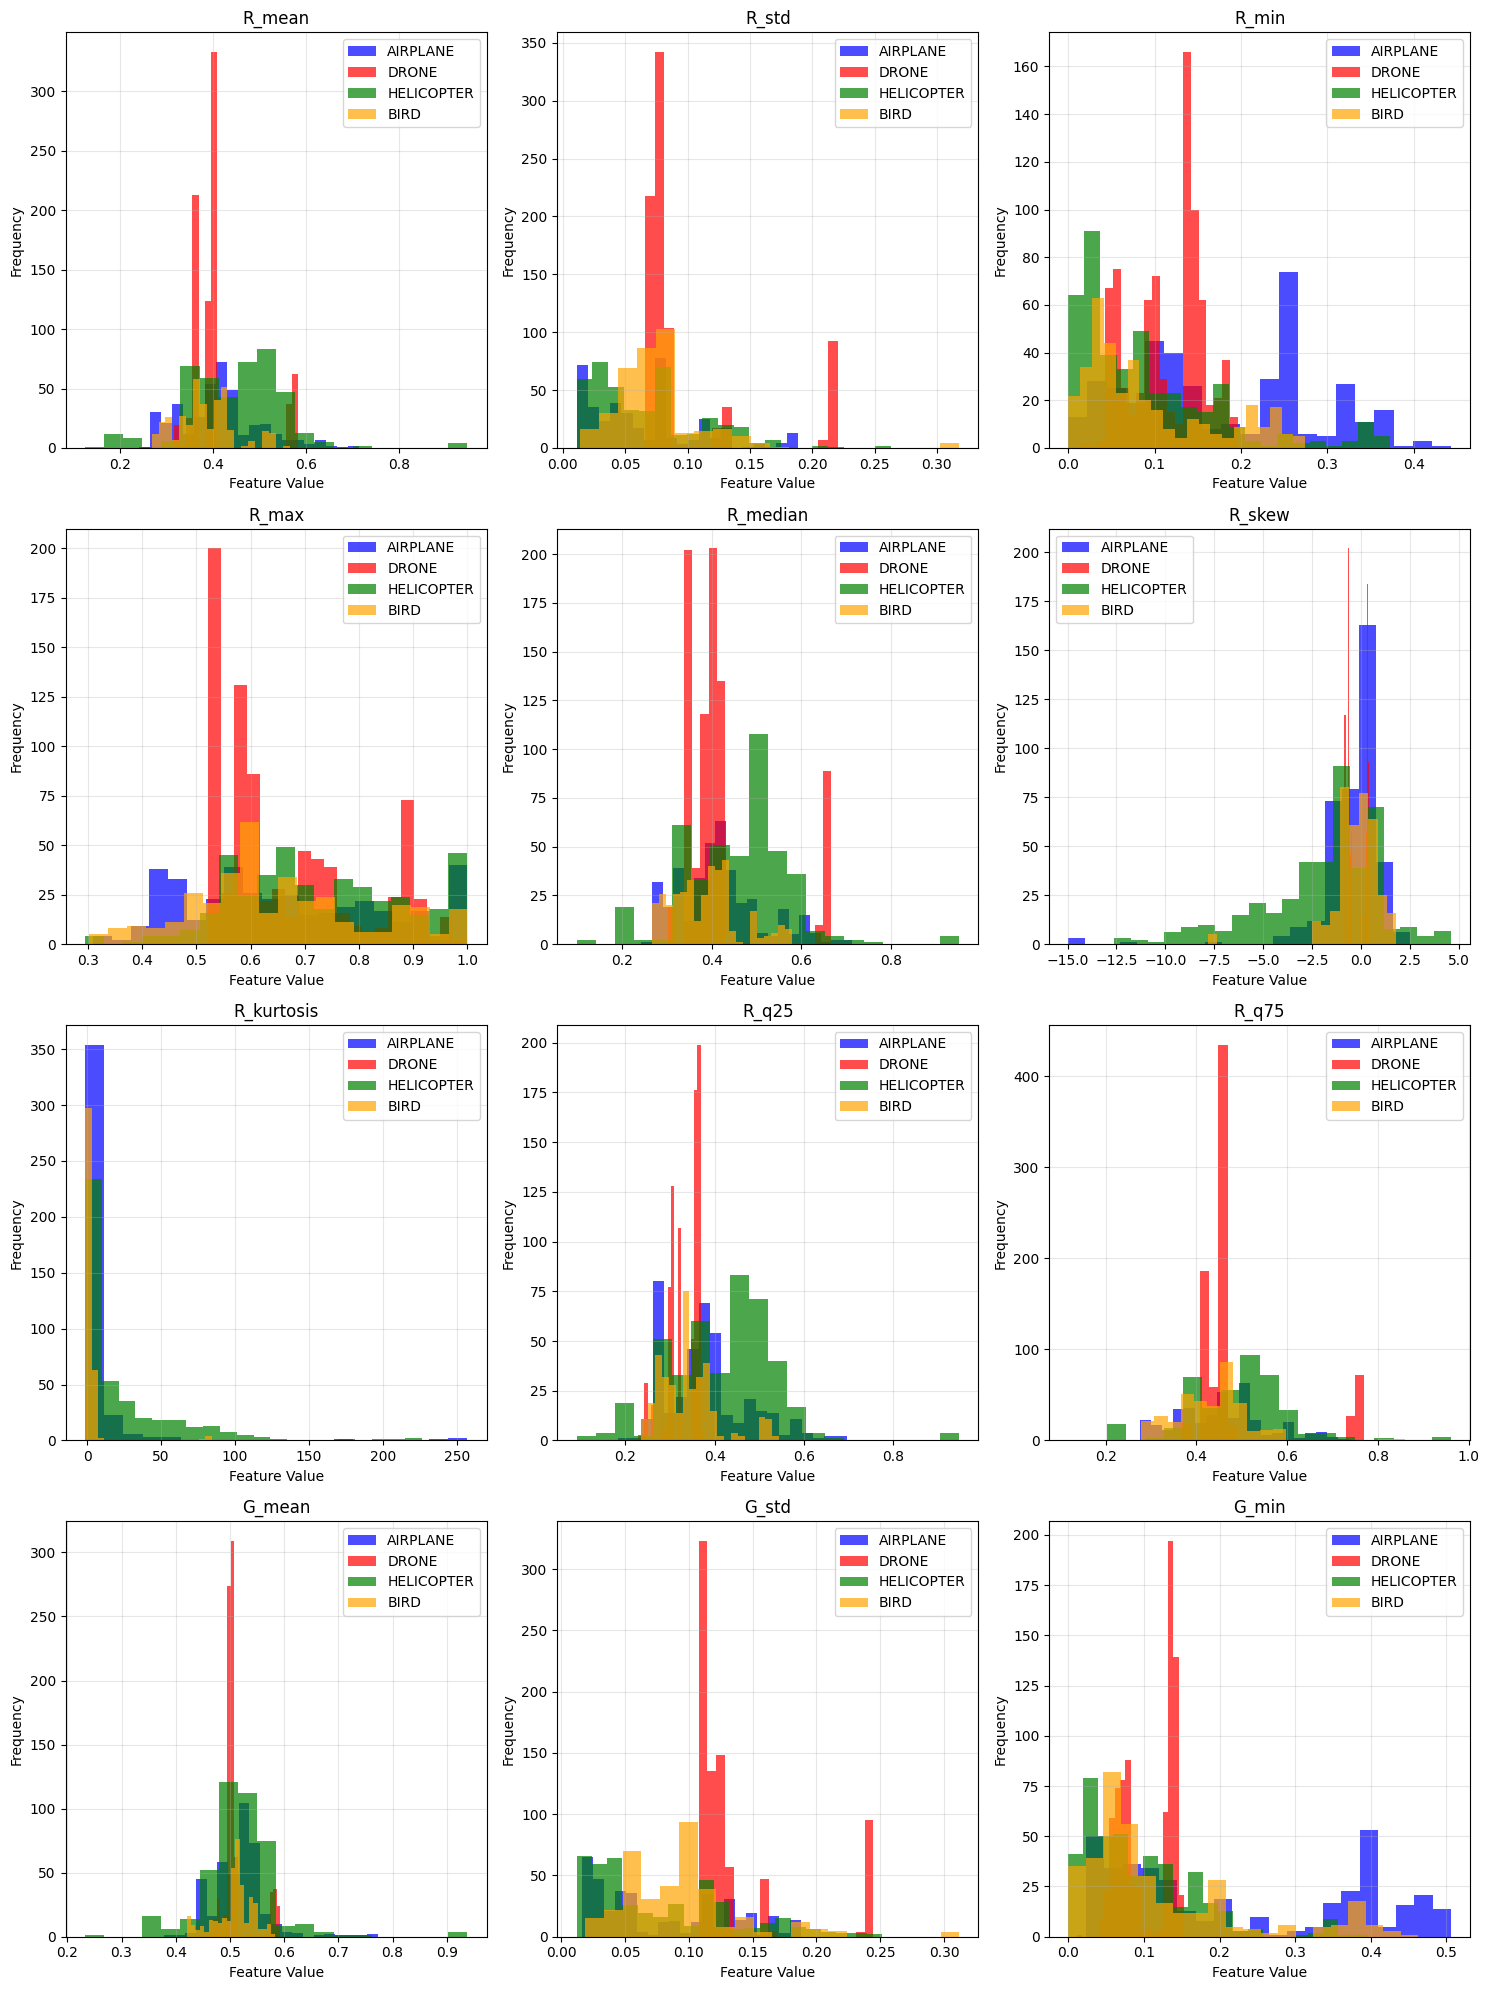

In [39]:
print("\n" + "="*80)
print("RandomForestClassfier Feature Analysis")
print("="*80)

visualize_rf_feature_distributions(X_train_features, y_train_cls, feature_names)

### Color Feature Distribution Analysis (Red & Green Channels)

Below is a summary of each feature plot and what insights we can derive from it:

| **Feature**     | **Description**                                                                 | **Insights from Plot**                                                                                                                                     |
|-----------------|----------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **R_mean**      | Mean intensity of red channel.                                                  | DRONE images (red) have a consistent narrow distribution peaking around 0.45, suggesting standardized brightness. BIRDS show more variability.            |
| **R_std**       | Standard deviation (contrast) of red channel.                                   | DRONEs again show a sharp peak around 0.05, indicating uniform red channel contrast, while other classes like BIRDs have a wider distribution.             |
| **R_min**       | Minimum red intensity in image.                                                 | AIRPLANEs and DRONEs often have lower minimums, possibly due to background. DRONEs sharply peak around 0.1.                                                |
| **R_max**       | Maximum red intensity.                                                          | DRONEs show distinct peak between 0.5–0.6, while AIRPLANEs and BIRDs stretch toward 1.0, indicating brighter red features.                                 |
| **R_median**    | Median red value (robust to outliers).                                          | DRONEs and HELICOPTERs have tight peaks, while BIRDs vary more, reflecting mixed textures/backgrounds.                                                    |
| **R_skew**      | Asymmetry in red distribution.                                                  | DRONEs skew negatively (longer tail on the left), AIRPLANEs slightly positively, suggesting image color bias differences.                                 |
| **R_kurtosis**  | Peakedness of red intensity distribution.                                       | DRONEs show a very high peak near zero, while other classes (esp. BIRDs) have longer tails, implying more outliers or textured content.                   |
| **R_q25**       | 25th percentile (lower quartile) red value.                                     | DRONEs again are tightly clustered, BIRDs show greater spread.                                                                                             |
| **R_q75**       | 75th percentile (upper quartile) red value.                                     | Helps understand spread — DRONEs are tight around 0.45, while BIRDs peak around 0.6–0.7.                                                                   |
| **G_mean**      | Mean green intensity.                                                           | DRONEs show similar pattern as R_mean: narrow, centered peak, suggesting strong color uniformity in drone images.                                          |
| **G_std**       | Standard deviation (contrast) in green channel.                                 | Similar behavior to R_std. DRONEs exhibit low variability. Other classes are broader, especially HELICOPTERs.                                              |
| **G_min**       | Minimum green intensity.                                                        | DRONEs maintain a sharp peak at lower values. AIRPLANEs have a bimodal pattern — some images have low green, others higher.                               |

---

### Key Takeaways:

- **DRONE** images show **high consistency across color stats** — tight peaks, low standard deviation, and low kurtosis. This likely reflects their typical appearance: consistent body color, often against uniform skies.
- **BIRD** and **HELICOPTER** classes exhibit **higher variability** across most features, likely due to varying backgrounds, lighting, and object shapes.
- **AIRPLANEs** fall in between — showing variation in some plots (R_max, G_min) and concentration in others (R_mean, R_q25).

---

### Implications for Modeling for Random Forests:

- These **distribution differences** make the color stats useful features for classification.
- DRONE class, being more narrowly distributed in many features, may be **easier to isolate** using decision trees or ensemble methods.
- BIRD and HELICOPTER classes may require more **complex feature combinations** due to their broader and overlapping distributions.

---

## Perform dimensionality analysis - RandomForest

Dimensionality Reduction Analysis - RandomForest


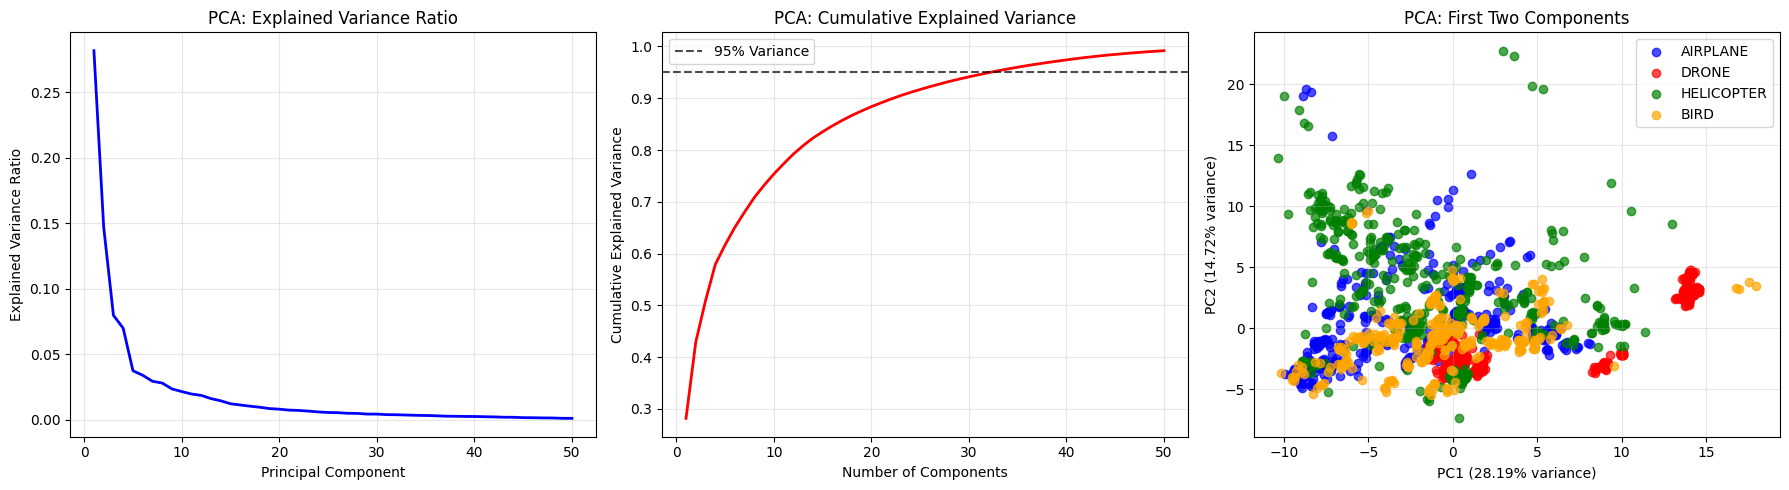

Components needed for 95% variance: 33


In [40]:
pca, n_components_95 = perform_rf_dimensionality_analysis(X_train_features, y_train_cls, feature_names)

| **PCA Plot**                          | **What It Shows**                                                                                                                                                                                                                                                                                                 | **Insights (Including Class-Specific)**                                                                                                                                                                                                                          |
|--------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **PCA: Explained Variance Ratio**    | Line plot showing how much variance each principal component explains, sorted in descending order. <br>PC1 captures the most variance, with steep drop afterward.                                                                                                                                                    | **PC1 (~28%)** and **PC2 (~14%)** together explain **~42%** of the variance. <br> After the first 5–6 components, the added benefit drops off. <br> DRONE class separation is likely captured in early PCs due to high variance signal.                     |
| **PCA: Cumulative Explained Variance** | Line plot showing how total variance increases as more PCs are added. Includes a 95% threshold line.                                                                                                                                                                                                            | **95% of variance is captured by ~30 components**. <br> Dimensionality can be reduced from 50+ features to ~30 without significant information loss. <br> Random Forest training can be faster and less prone to overfitting after PCA preprocessing.       |
| **PCA: First Two Components**        | 2D scatter plot of data projected onto PC1 and PC2. Each point is an image, colored by class: <br>🔵 AIRPLANE, 🔴 DRONE, 🟢 HELICOPTER, 🟠 BIRD.                                                                                                                                                                  | 🔴 **DRONE**: Forms a compact, well-separated cluster → easiest to detect. <br> 🟢 **HELICOPTER**: Moderately scattered; overlaps with AIRPLANE and BIRD → less distinctive. <br> 🟠 **BIRD**: High overlap with HELICOPTER → shared features. <br> 🔵 **AIRPLANE**: Spread out, overlaps others. |


Key Insights and Takeaways:

Dimensionality Reduction Potential:
* Strong feature compression is possible. Only 30 components are enough to retain 95% of the variance.
* This suggests you can simplify the feature space significantly before using it in algorithms like Random Forest, which helps with training speed and potentially reduces overfitting.

Class Separability:
* DRONE class is clearly separated in the 2D PCA plot → suggests it’s distinct in feature space.
* BIRD, HELICOPTER, and AIRPLANE have significant overlap, indicating these classes may require more than 2 principal components to be separated well.
* This visualization suggests DRONE detection is likely easier (distinctive features), whereas fine-tuning is needed to distinguish between other flying objects.

## Feature Extraction for Convolutional Neural Networks (CNNs)

For images, this often means extracting things like:
 * Edges
 * Textures
 * Shapes
 * Keypoints

In [41]:
def visualize_cnn_feature_distributions(features_dict, y_labels=None):
    '''
    Visualize distribution of extracted features
    '''
    print("Visualizing feature distributions...")

    n_features = len(features_dict)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    colors = ['blue', 'red', 'green', 'orange']

    for i, (feature_name, features) in enumerate(features_dict.items()):
        if i >= 6:  # Limit to 6 plots
            break

        ax = axes[i]

        # For high-dimensional features, show PCA
        if features.shape[1] > 50:
            # Apply PCA to reduce dimensionality
            pca = PCA(n_components=2)
            features_pca = pca.fit_transform(features)

            if y_labels is not None:
                # Plot by class
                for class_id in np.unique(y_labels):
                    mask = y_labels == class_id
                    ax.scatter(features_pca[mask, 0], features_pca[mask, 1],
                             c=colors[class_id], label=class_names[class_id], alpha=0.7)
                ax.legend()
                ax.set_title(f'{feature_name} Features (PCA)')
            else:
                ax.scatter(features_pca[:, 0], features_pca[:, 1], alpha=0.7)
                ax.set_title(f'{feature_name} Features (PCA)')

            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')

        else:
            # For low-dimensional features, show histogram
            if y_labels is not None:
                # Plot histogram by class
                for class_id in np.unique(y_labels):
                    mask = y_labels == class_id
                    if np.sum(mask) > 0:
                        ax.hist(features[mask, 0], bins=20, alpha=0.7,
                               color=colors[class_id], label=class_names[class_id])
                ax.legend()
            else:
                ax.hist(features[:, 0], bins=20, alpha=0.7)

            ax.set_title(f'{feature_name} Features (First Dimension)')
            ax.set_xlabel('Feature Value')
            ax.set_ylabel('Frequency')

        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("images/cnn_features_distribution.png")
    plt.show()

In [42]:
def extract_cnn_features(X, y_labels=None):
    '''
    Extract traditional image features
    '''
    print("="*60)
    print("CNN Feature Extraction")
    print("="*60)

    features_dict = {}

    # Select subset for feature extraction (to avoid memory issues)
    subset_size = min(100, len(X))
    subset_indices = np.random.choice(len(X), subset_size, replace=False)
    X_subset = X[subset_indices]
    y_subset = y_labels[subset_indices] if y_labels is not None else None

    print(f"Extracting features from {subset_size} images...")

    # 1. HOG (Histogram of Oriented Gradients) Features
    print("Extracting HOG features...")
    hog_features = []
    for i, img in enumerate(X_subset):
        gray = rgb2gray(img)
        hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=False)
        hog_features.append(hog_feat)

    hog_features = np.array(hog_features)
    features_dict['HOG'] = hog_features
    print(f"HOG features shape: {hog_features.shape}")

    # 2. LBP (Local Binary Pattern) Features
    print("Extracting LBP features...")
    lbp_features = []
    for i, img in enumerate(X_subset):
        gray = rgb2gray(img)
        gray_uint8 = img_as_ubyte(gray)
        lbp = local_binary_pattern(gray_uint8, P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=10, density=True)
        lbp_features.append(hist)

    lbp_features = np.array(lbp_features)
    features_dict['LBP'] = lbp_features
    print(f"LBP features shape: {lbp_features.shape}")

    # 3. Color Histogram Features
    print("Extracting color histogram features...")
    color_features = []
    for i, img in enumerate(X_subset):
        # RGB histograms
        hist_r = np.histogram(img[:, :, 0], bins=32, range=(0, 1))[0]
        hist_g = np.histogram(img[:, :, 1], bins=32, range=(0, 1))[0]
        hist_b = np.histogram(img[:, :, 2], bins=32, range=(0, 1))[0]

        # Normalize histograms
        hist_r = hist_r / np.sum(hist_r)
        hist_g = hist_g / np.sum(hist_g)
        hist_b = hist_b / np.sum(hist_b)

        color_feat = np.concatenate([hist_r, hist_g, hist_b])
        color_features.append(color_feat)

    color_features = np.array(color_features)
    features_dict['Color_Histogram'] = color_features
    print(f"Color histogram features shape: {color_features.shape}")

    # 4. Statistical Features
    print("Extracting statistical features...")
    statistical_features = []
    for i, img in enumerate(X_subset):
        # Calculate various statistics
        stats = []

        # Per-channel statistics
        for ch in range(3):
            channel = img[:, :, ch]
            stats.extend([
                np.mean(channel),
                np.std(channel),
                np.min(channel),
                np.max(channel),
                np.median(channel),
                scipy_stats.skew(channel.flatten()),
                scipy_stats.kurtosis(channel.flatten())
            ])

        # Overall image statistics
        gray = rgb2gray(img)

        # Calculate entropy using histogram
        hist, _ = np.histogram(gray.flatten(), bins=256, density=True)
        # Remove zeros to avoid log(0) issues
        hist = hist[hist > 0]
        entropy_val = -np.sum(hist * np.log2(hist + 1e-10))

        # Safe edge density calculation
        edge_density = np.sum(sobel_filter_edge_detection(gray))

        stats.extend([
            np.mean(gray),
            np.std(gray),
            entropy_val,
            edge_density
        ])

        statistical_features.append(stats)

    statistical_features = np.array(statistical_features)
    features_dict['Statistical'] = statistical_features
    print(f"Statistical features shape: {statistical_features.shape}")

    # 5. Texture Features (Alternative implementation without GLCM)
    print("Extracting texture features...")
    texture_features = []
    for i, img in enumerate(X_subset):
        gray = rgb2gray(img)

        # Alternative texture measures without GLCM
        # 1. Standard deviation (simple texture measure)
        texture_std = np.std(gray)

        # 2. Gradient-based texture measures
        grad_x = np.gradient(gray, axis=1)
        grad_y = np.gradient(gray, axis=0)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

        # 3. Local variance (texture complexity)
        kernel_size = 5
        h, w = gray.shape
        local_vars = []
        for row in range(0, h-kernel_size+1, kernel_size//2):
            for col in range(0, w-kernel_size+1, kernel_size//2):
                patch = gray[row:row+kernel_size, col:col+kernel_size]
                if patch.size > 0:
                    local_vars.append(np.var(patch))

        local_var_mean = np.mean(local_vars) if local_vars else 0

        # 4. Edge density using Sobel filter
        try:
            edge_density = np.sum(filters.sobel(gray))
        except:
            # Fallback edge detection
            edge_density = np.sum(np.abs(grad_x)) + np.sum(np.abs(grad_y))

        # Combine texture features
        texture_feat = [
            texture_std,
            np.mean(gradient_magnitude),
            local_var_mean,
            edge_density / (gray.shape[0] * gray.shape[1])  # Normalize by image size
        ]

        texture_features.append(texture_feat)

    texture_features = np.array(texture_features)
    features_dict['Texture'] = texture_features
    print(f"Texture features shape: {texture_features.shape}")

    # Visualize feature distributions
    visualize_cnn_feature_distributions(features_dict, y_subset)

    return features_dict

CNN Feature Extraction
Extracting features from 100 images...
Extracting HOG features...
HOG features shape: (100, 26244)
Extracting LBP features...
LBP features shape: (100, 10)
Extracting color histogram features...
Color histogram features shape: (100, 96)
Extracting statistical features...
Statistical features shape: (100, 25)
Extracting texture features...
Texture features shape: (100, 4)
Visualizing feature distributions...


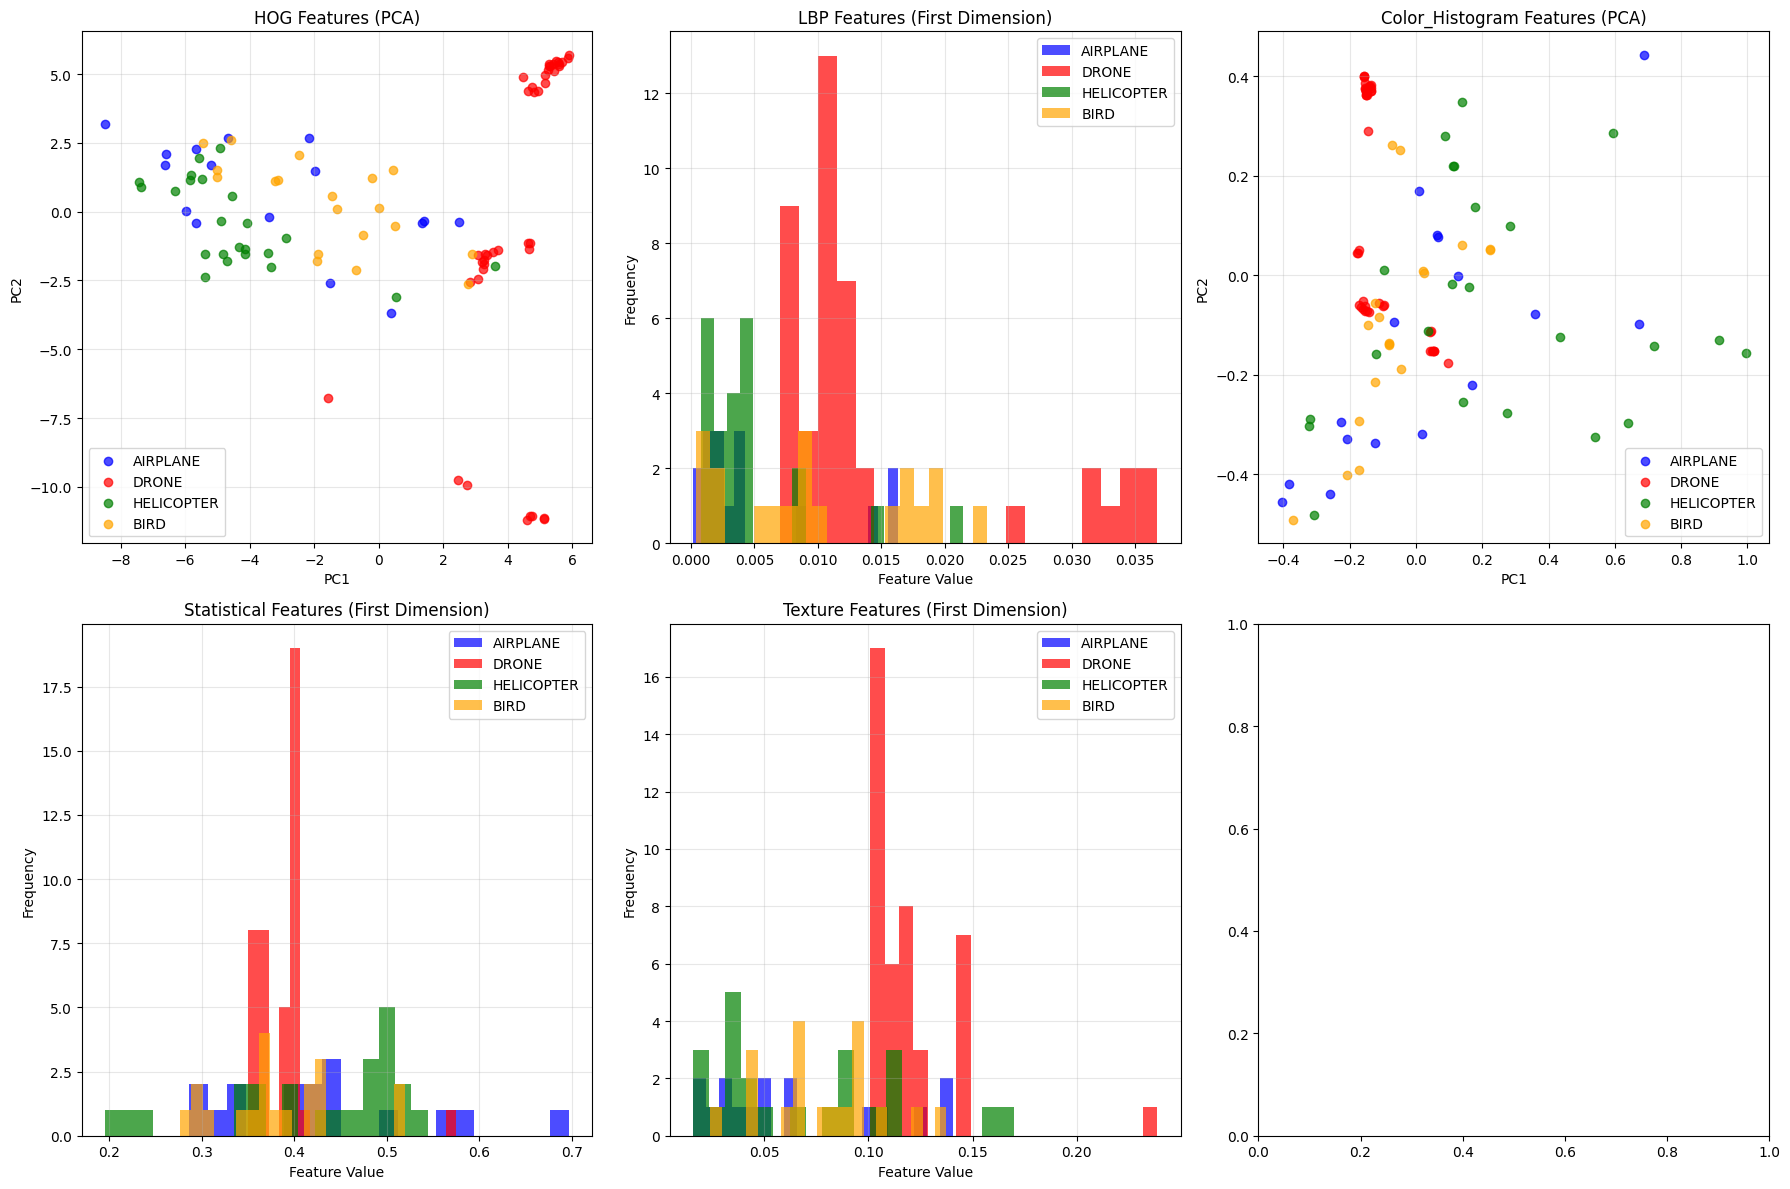

In [43]:
# Extract traditional features
traditional_features = extract_cnn_features(X_train_cls, y_train_cls)

### Feature Extraction Analysis for CNN Drone Classification

| Feature Type            | Best Performance | Characteristics                                                        | Strengths                                                | Weaknesses                                      | CNN Implications                            |
|-------------------------|------------------|------------------------------------------------------------------------|-----------------------------------------------------------|------------------------------------------------|----------------------------------------------|
| HOG Features (PCA)      | AIRPLANE         | Distinct clustering for airplanes, scattered helicopters, overlapping birds | Excellent for structural/shape discrimination, consistent edge patterns | Struggles with organic vs. mechanical shapes | Use for shape-based attention mechanisms     |
| LBP Features            | DRONE            | Drones dominate 0.010–0.015 range, distributed patterns for others     | Strong texture discrimination for manufactured surfaces   | Limited distinction between airplanes/helicopters | High weight in texture feature extraction    |
| Color Histogram (PCA)   | HELICOPTER       | Widest spread for helicopters, clustered airplanes                     | Moderate discrimination, environmental context           | Less distinctive for primary classification   | Secondary feature for context enhancement    |
| Statistical Features    | DRONE/AIRPLANE   | High peaks for drones (~0.40) and airplanes (~0.45)                    | Consistent properties for manufactured objects           | Poor discrimination for complex/natural objects | Feature normalization and consistency checks |
| Texture Features        | DRONE            | Dominant frequency around 0.10–0.12 for drones                         | Excellent manufactured vs. natural distinction           | Minimal bird representation                    | Primary discriminative feature weighting     |


### Class Based Analysis:
| Category    | Distinguishing Features                                              | Classification Difficulty                   |                    |
|-------------|----------------------------------------------------------------------|----------------------------------------------|---------------------------------------------|
| AIRPLANE    | Consistent HOG clustering, moderate color clustering, clear statistical peak | Low – Well-separated in multiple features    |
| DRONE       | Dominates LBP, texture, and statistical features                     | Very Low – Most homogeneous and distinctive  |
| HELICOPTER  | High variability across all features, widest color spread            | High – High intra-class variance             |
| BIRD        | Overlaps significantly with aircraft in most features                | Very High – Organic vs. mechanical confusion |

# Model Training

## Random Forest Classifier

In [44]:
def visualize_grid_search_results(results_df, param_grid):
    '''
    Visualize GridSearchCV results to understand parameter importance
    '''
    print("\nVisualizing GridSearchCV Results...")

    # Select parameters with multiple values for visualization
    params_to_plot = []
    for param, values in param_grid.items():
        if len(values) > 1:
            params_to_plot.append(param)

    # Limit to 6 most interesting parameters for visualization
    params_to_plot = params_to_plot[:6]

    if len(params_to_plot) == 0:
        print("No parameters with multiple values to visualize")
        return

    # Create subplots
    n_params = len(params_to_plot)
    cols = min(3, n_params)
    rows = (n_params + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1) if n_params > 1 else [axes]
    elif cols == 1:
        axes = axes.reshape(-1, 1)

    for i, param in enumerate(params_to_plot):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]

        # Group by parameter value and calculate mean score
        param_scores = []
        param_values = []

        for value in param_grid[param]:
            mask = results_df['param_' + param] == value
            if mask.any():
                scores = results_df.loc[mask, 'mean_test_score']
                param_scores.append(scores.mean())
                param_values.append(str(value))

        if param_scores:
            # Create bar plot
            bars = ax.bar(range(len(param_values)), param_scores, alpha=0.7)
            ax.set_xlabel(param)
            ax.set_ylabel('Mean CV Score')
            ax.set_title(f'Effect of {param}')
            ax.set_xticks(range(len(param_values)))
            ax.set_xticklabels(param_values, rotation=45, ha='right')

            # Add value labels on bars
            for j, (bar, score) in enumerate(zip(bars, param_scores)):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                       f'{score:.3f}', ha='center', va='bottom', fontsize=8)

            ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for i in range(n_params, rows * cols):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [45]:
def record_performance_metrics(dataset_type, model, X_scaled, y_true, model_name='rf'):
    '''
    Record performance metrics for models
    '''
    # Evaluate on data set
    y_pred = model.predict(X_scaled)

    if model_name == 'cnn':
      print("Recording Performance Metrics for CNN:")
      if y_true.ndim > 1:
        y_true = np.argmax(y_true, axis=1)
      if y_pred.ndim > 1:
        y_pred = np.argmax(y_pred, axis=1)
    else:
      print("Recording Performance Metrics for RandomForest:")

    accuracy = accuracy_score(y_true, y_pred)
    mse = mse_loss(y_true, y_pred)
    mae = mae_loss(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    if dataset_type == 'train':
      mse_train_models.append(mse)
      acc_train_models.append(accuracy)
      mae_train_models.append(mae)
      precision_train_models.append(precision)
      recall_train_models.append(recall)
      f1_train_models.append(f1)
      print(f"\nTraining Accuracy: {accuracy:.4f}")
      print(f"Training MSE: {mse:.4f}")
      print(f"Training MAE: {mae:.4f}")
      print(f"Training Precision: {precision:.4f}")
      print(f"Training Recall: {recall:.4f}")
      print(f"Training F1 Score: {f1:.4f}")
    elif dataset_type == 'valid':
      mse_val_models.append(mse)
      acc_val_models.append(accuracy)
      mae_val_models.append(mae)
      precision_val_models.append(precision)
      recall_val_models.append(recall)
      f1_val_models.append(f1)
      print(f"\nValidation Accuracy: {accuracy:.4f}")
      print(f"Validation MSE: {mse:.4f}")
      print(f"Validation MAE: {mae:.4f}")
      print(f"Validation Precision: {precision:.4f}")
      print(f"Validation Recall: {recall:.4f}")
      print(f"Validation F1 Score: {f1:.4f}")
    elif dataset_type == 'test':
      mse_test_models.append(mse)
      acc_test_models.append(accuracy)
      mae_test_models.append(mae)
      precision_test_models.append(precision)
      recall_test_models.append(recall)
      f1_test_models.append(f1)
      print(f"\Test Accuracy: {accuracy:.4f}")
      print(f"Test MSE: {mse:.4f}")
      print(f"Test MAE: {mae:.4f}")
      print(f"Test Precision: {precision:.4f}")
      print(f"Test Recall: {recall:.4f}")
      print(f"Test F1 Score: {f1:.4f}")
    else:
        raise ValueError("Invalid dataset_type. Must be 'train', 'val', or 'test'.")

    return accuracy

In [46]:
def train_baseline_random_forest(X_train_features, y_train, feature_names, X_val_features, y_val, X_test_features, y_test):
    '''
    Train baseline Random Forest model for comparison with GridSearchCV
    '''
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_features)
    X_val_scaled = scaler.transform(X_val_features)
    X_test_scaled = scaler.transform(X_test_features)

    print(f"Training samples: {len(X_train_scaled)}")
    print(f"Validation samples: {len(X_val_scaled)}")
    print(f"Feature dimension: {X_train_scaled.shape[1]}")

    # Baseline parameters
    baseline_params = {
        'n_estimators': 100,
        'max_depth': None,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'sqrt',
        'class_weight': 'balanced',
        'bootstrap': True
    }

    print("Baseline Parameters:")
    for param, value in baseline_params.items():
        print(f"  {param}: {value}")

    # Train baseline Random Forest
    baseline_rf = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        **baseline_params
    )

    baseline_rf.fit(X_train_scaled, y_train)

    # Evaluate on train set
    train_accuracy = record_performance_metrics('train', baseline_rf, X_train_scaled, y_train)
    # Evaluate on validation set
    valid_accuracy = record_performance_metrics('valid', baseline_rf, X_val_scaled, y_val)
    # Evaluate on test set
    test_accuracy = record_performance_metrics('test', baseline_rf, X_test_scaled, y_test)


    return baseline_rf, scaler, train_accuracy, valid_accuracy, test_accuracy, baseline_params

In [47]:
%%time
print("\n" + "="*80)
print("Training Baseline RandomForest")

# Train baseline model for comparison
rf_base_start_time = time.time()
try:
    baseline_rf, baseline_scaler, train_accuracy, valid_accuracy, test_accuracy, baseline_params = train_baseline_random_forest(
        X_train_features, y_train_cls, feature_names, X_val_features, y_val_cls, X_test_features, y_test_cls
    )

    print(f"Baseline Random Forest Training Accuracy: {train_accuracy:.4f}")
    print(f"Baseline Random Forest Validation Accuracy: {valid_accuracy:.4f}")
    print(f"Baseline Random Forest Test Accuracy: {test_accuracy:.4f}")

except Exception as e:
    print(f"Error during baseline Random Forest training: {e}")
    import traceback
    traceback.print_exc()
rf_base_end_time = time.time()
model_training_time.append(rf_base_end_time - rf_base_start_time)


Training Baseline RandomForest
Training samples: 2000
Validation samples: 400
Feature dimension: 96
Baseline Parameters:
  n_estimators: 100
  max_depth: None
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: sqrt
  class_weight: balanced
  bootstrap: True
Recording Performance Metrics for RandomForest:

Training Accuracy: 1.0000
Training MSE: 0.0000
Training MAE: 0.0000
Training Precision: 1.0000
Training Recall: 1.0000
Training F1 Score: 1.0000
Recording Performance Metrics for RandomForest:

Validation Accuracy: 0.9675
Validation MSE: 0.1350
Validation MAE: 0.0325
Validation Precision: 0.9675
Validation Recall: 0.9675
Validation F1 Score: 0.9675
Recording Performance Metrics for RandomForest:
\Test Accuracy: 0.9725
Test MSE: 0.1350
Test MAE: 0.0417
Test Precision: 0.9734
Test Recall: 0.9725
Test F1 Score: 0.9725
Baseline Random Forest Training Accuracy: 1.0000
Baseline Random Forest Validation Accuracy: 0.9675
Baseline Random Forest Test Accuracy: 0.9725
CPU times: user 

In [48]:
def perform_grid_search(X_train_features, y_train, feature_names, cv_folds=3, n_jobs=-1):
    '''
    Perform comprehensive GridSearchCV for Random Forest hyperparameter tuning
    '''
    # Scale features for grid search
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_features)
    # X_val_scaled = scaler.fit_transform(X_val_features)

    print(f"Training samples: {len(X_train_scaled)}")
    print(f"Feature dimension: {X_train_scaled.shape[1]}")
    print(f"Classes distribution: {Counter(y_train)}")
    print(f"Cross-validation folds: {cv_folds}")

    # Define comprehensive parameter grid
    param_grid = {
        # Number of trees
        'n_estimators': [100, 200, 300],

        # Maximum depth of trees
        'max_depth': [10, 15, 20, None],

        # Minimum samples required to split a node
        'min_samples_split': [2, 5, 10],

        # Minimum samples required at a leaf node
        'min_samples_leaf': [1, 2, 4],

        # Number of features to consider for best split
        'max_features': ['sqrt', 'log2', None],

        # Class weight strategy
        'class_weight': ['balanced', None],

        # Bootstrap sampling
        'bootstrap': [True, False]
    }

    # Calculate total combinations
    total_combinations = 1
    for param, values in param_grid.items():
        total_combinations *= len(values)

    print(f"Total parameter combinations: {total_combinations}")
    print(f"Total CV fits: {total_combinations * cv_folds}")
    print("This may take several minutes to complete...")

    # Create Random Forest classifier
    rf = RandomForestClassifier(random_state=42, n_jobs=1)  # Set n_jobs=1 for GridSearch to control parallelism

    # Create stratified cross-validation
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Create GridSearchCV
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=n_jobs,
        verbose=1,
        return_train_score=True
    )

    # Perform grid search
    grid_search.fit(X_train_scaled, y_train)

    # Extract results
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_

    print(f"\nBest Cross-Validation Score: {best_score:.4f}")
    print("\nBest Parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Analyze grid search results
    results_df = pd.DataFrame(grid_search.cv_results_)

    # Top 10 parameter combinations
    top_10_results = results_df.nlargest(10, 'mean_test_score')[
        ['mean_test_score', 'std_test_score', 'params']
    ]

    print("\nTop 10 Parameter Combinations:")
    for i, (idx, row) in enumerate(top_10_results.iterrows()):
        print(f"\n{i+1:2d}. Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
        for param, value in row['params'].items():
            print(f"    {param}: {value}")

    # Visualize parameter importance
    visualize_grid_search_results(results_df, param_grid)

    return grid_search, scaler, best_params, best_score, results_df


RandomForest + GridSearch Hyperparameter Optimization
Training samples: 2000
Feature dimension: 96
Classes distribution: Counter({np.int64(1): 815, np.int64(2): 425, np.int64(0): 393, np.int64(3): 367})
Cross-validation folds: 2
Total parameter combinations: 1296
Total CV fits: 2592
This may take several minutes to complete...
Fitting 2 folds for each of 1296 candidates, totalling 2592 fits

Best Cross-Validation Score: 0.9740

Best Parameters:
  bootstrap: False
  class_weight: balanced
  max_depth: 15
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 10
  n_estimators: 100

Top 10 Parameter Combinations:

 1. Score: 0.9740 (±0.0050)
    bootstrap: False
    class_weight: balanced
    max_depth: 15
    max_features: sqrt
    min_samples_leaf: 1
    min_samples_split: 10
    n_estimators: 100

 2. Score: 0.9740 (±0.0050)
    bootstrap: False
    class_weight: balanced
    max_depth: 20
    max_features: sqrt
    min_samples_leaf: 1
    min_samples_split: 10
    n_estimat

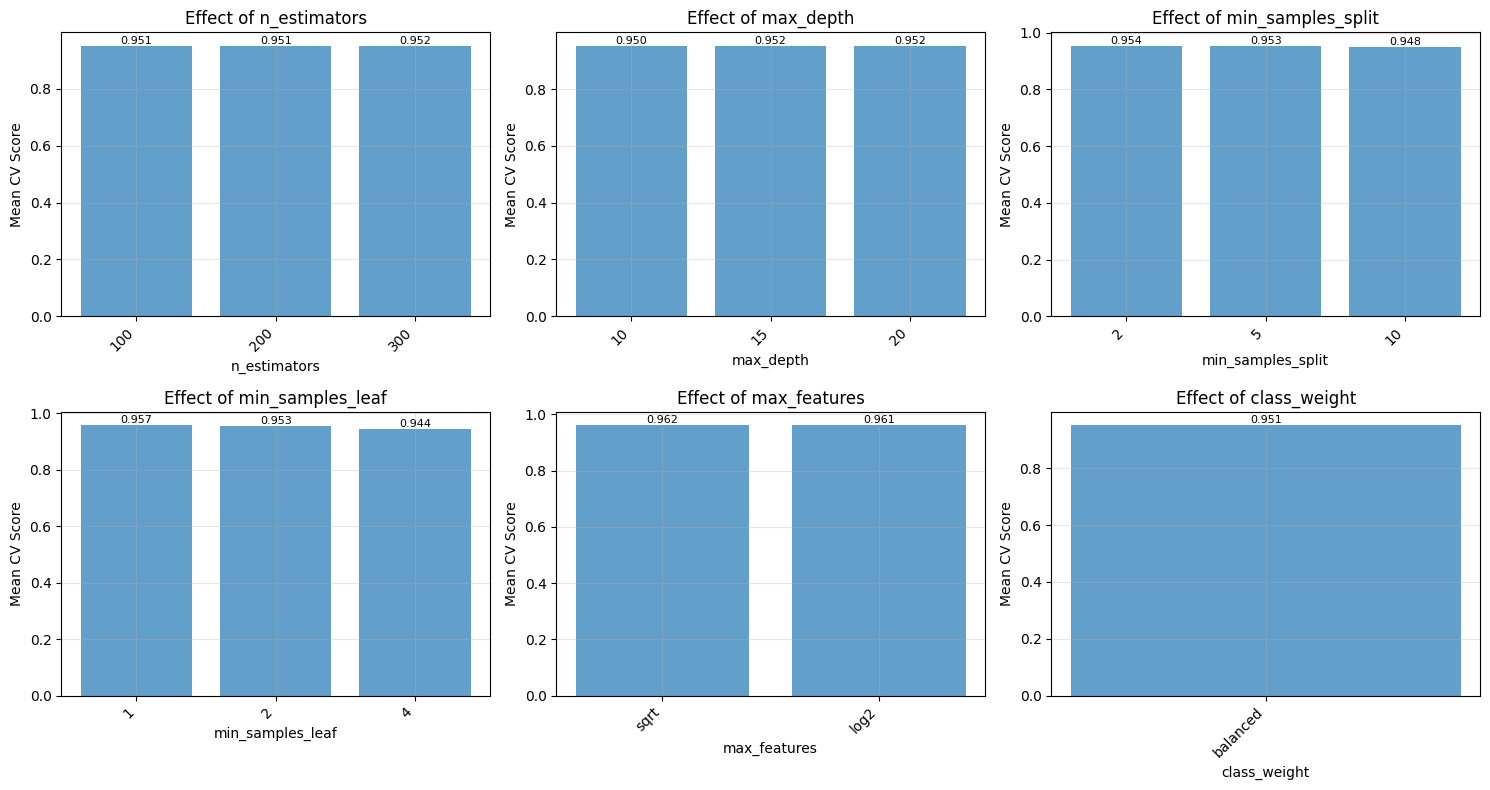

GridSearchCV Best Cross-Validation Score: 0.9740
CPU times: user 15.3 s, sys: 2.1 s, total: 17.4 s
Wall time: 23min 38s


In [49]:
%%time
print("\n" + "="*80)
print("RandomForest + GridSearch Hyperparameter Optimization")
print("="*80)

# Perform GridSearchCV
rf_grid_start_time = time.time()
try:
    if run_grid_search:
      grid_search, grid_scaler, best_params, best_score, results_df = perform_grid_search(
          X_train_features, y_train_cls, feature_names, cv_folds=2, n_jobs=-1
      )

      print(f"GridSearchCV Best Cross-Validation Score: {best_score:.4f}")
except Exception as e:
    print(f"Error during GridSearchCV: {e}")
    import traceback
    traceback.print_exc()
rf_grid_end_time = time.time()

In [50]:
def train_optimized_random_forest_model(X_train_features, y_train, best_params, feature_names,
                                       X_val_features, y_val, X_test_features, y_test):
    '''
    Train Random Forest model with optimized hyperparameters
    '''
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_features)
    X_val_scaled = scaler.transform(X_val_features)
    X_test_scaled = scaler.transform(X_test_features)

    print(f"Training samples: {len(X_train_scaled)}")
    print(f"Validation samples: {len(X_val_scaled)}")
    print(f"Feature dimension: {X_train_scaled.shape[1]}")
    print(f"Classes distribution in training: {Counter(y_train)}")

    print("\nOptimized Parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Train Random Forest with optimized parameters
    rf_model = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        **best_params
    )

    rf_model.fit(X_train_scaled, y_train)

    # Evaluate on validation set
    y_val_pred = rf_model.predict(X_val_scaled)

    # Evaluate on train set
    train_accuracy = record_performance_metrics('train', rf_model, X_train_scaled, y_train)
    # Evaluate on validation set
    valid_accuracy = record_performance_metrics('valid', rf_model, X_val_scaled, y_val)
    # Evaluate on test set
    test_accuracy = record_performance_metrics('test', rf_model, X_test_scaled, y_test)

    # Print classification report
    print("\nValidation Classification Report:")
    print(classification_report(y_val, y_val_pred, target_names=class_names))

    # Feature importance analysis
    feature_importance = rf_model.feature_importances_

    # Get top 20 most important features
    top_indices = np.argsort(feature_importance)[-20:]
    top_features = [feature_names[i] for i in top_indices]
    top_importance = feature_importance[top_indices]

    print("\nTop 20 Most Important Features:")
    for feat, imp in zip(reversed(top_features), reversed(top_importance)):
        print(f"  {feat}: {imp:.4f}")

    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_importance)
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Feature Importance (Optimized Random Forest)')
    plt.tight_layout()
    plt.savefig("images/opti_rf_features_distribution.png")
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Validation Confusion Matrix (Optimized Model)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return rf_model, scaler, train_accuracy, valid_accuracy, test_accuracy, feature_importance


Training Optimized RandomForest
Training samples: 2000
Validation samples: 400
Feature dimension: 96
Classes distribution in training: Counter({np.int64(1): 815, np.int64(2): 425, np.int64(0): 393, np.int64(3): 367})

Optimized Parameters:
  bootstrap: False
  class_weight: balanced
  max_depth: 15
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 10
  n_estimators: 100
Recording Performance Metrics for RandomForest:

Training Accuracy: 1.0000
Training MSE: 0.0000
Training MAE: 0.0312
Training Precision: 1.0000
Training Recall: 1.0000
Training F1 Score: 1.0000
Recording Performance Metrics for RandomForest:

Validation Accuracy: 0.9700
Validation MSE: 0.1125
Validation MAE: 0.0365
Validation Precision: 0.9700
Validation Recall: 0.9700
Validation F1 Score: 0.9699
Recording Performance Metrics for RandomForest:
\Test Accuracy: 0.9800
Test MSE: 0.1050
Test MAE: 0.0379
Test Precision: 0.9808
Test Recall: 0.9800
Test F1 Score: 0.9800

Validation Classification Report:
       

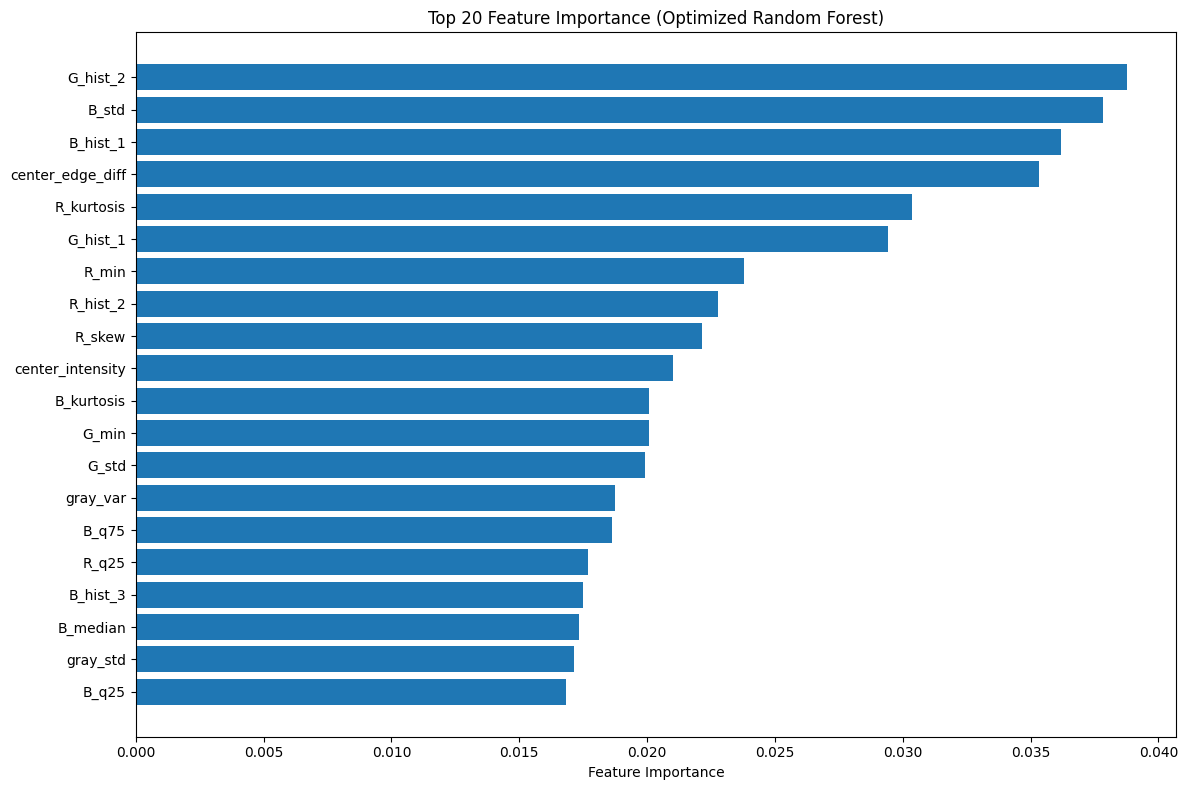

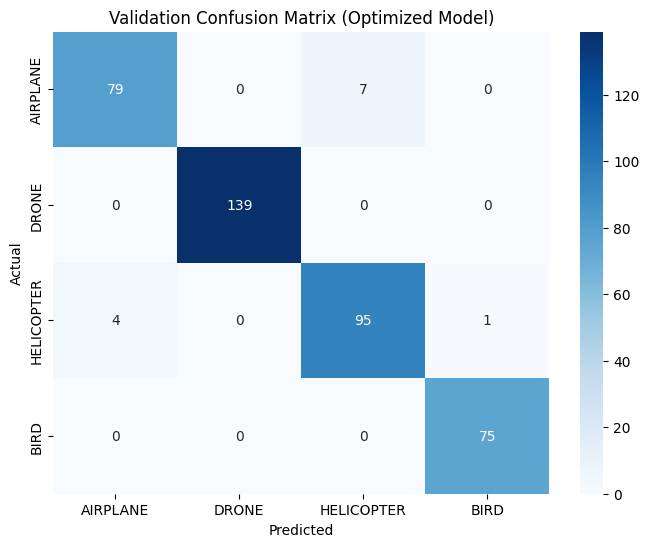

Optimized Random Forest Test Accuracy: 0.9800
Optimized Random Forest Training Accuracy: 1.0000
Optimized Random Forest Validation Accuracy: 0.9700
CPU times: user 3.05 s, sys: 65.1 ms, total: 3.11 s
Wall time: 1.05 s


In [51]:
%%time
print("\n" + "="*80)
print("Training Optimized RandomForest")
print("="*80)

# Train optimized model with best parameters
rf_opti_start_time = time.time()
try:
    optimized_rf, optimized_scaler, optimized_train_accuracy, optimized_valid_accuracy, optimized_test_accuracy, feature_importance = train_optimized_random_forest_model(
        X_train_features, y_train_cls, best_params, feature_names, X_val_features, y_val_cls, X_test_features, y_test_cls
    )

    print(f"Optimized Random Forest Test Accuracy: {optimized_test_accuracy:.4f}")
    print(f"Optimized Random Forest Training Accuracy: {optimized_train_accuracy:.4f}")
    print(f"Optimized Random Forest Validation Accuracy: {optimized_valid_accuracy:.4f}")

except Exception as e:
    print(f"Error during optimized Random Forest training: {e}")
    import traceback
    traceback.print_exc()
rf_opti_end_time = time.time()

model_training_time.append(rf_opti_end_time - rf_opti_start_time)

## RandomForest Model Comparision

In [52]:
def compare_baseline_vs_optimized(baseline_accuracy, optimized_accuracy, baseline_params, best_params):
    '''
    Compare baseline Random Forest vs GridSearchCV optimized model
    '''
    improvement = optimized_accuracy - baseline_accuracy
    improvement_pct = (improvement / baseline_accuracy) * 100

    print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")
    print(f"Optimized Model Accuracy: {optimized_accuracy:.4f}")
    print(f"Improvement: {improvement:.4f} ({improvement_pct:+.2f}%)")

    if improvement > 0:
        print("✅ GridSearchCV improved model performance!")
    elif improvement == 0:
        print("➡️ GridSearchCV maintained baseline performance")
    else:
        print("⚠️ GridSearchCV resulted in lower performance (possible overfitting)")

    print("\nParameter Comparison:")
    print("Baseline Parameters:")
    for param, value in baseline_params.items():
        print(f"  {param}: {value}")

    print("\nOptimized Parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Visualize comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy comparison
    models = ['Baseline', 'Optimized']
    accuracies = [baseline_accuracy, optimized_accuracy]
    colors = ['lightcoral', 'lightgreen']

    bars = ax1.bar(models, accuracies, color=colors, alpha=0.7)
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Model Performance Comparison')
    ax1.set_ylim([min(accuracies) - 0.05, max(accuracies) + 0.05])

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

    ax1.grid(True, alpha=0.3, axis='y')

    # Improvement visualization
    if improvement != 0:
        ax2.bar(['Improvement'], [improvement_pct],
                color='green' if improvement > 0 else 'red', alpha=0.7)
        ax2.set_ylabel('Improvement (%)')
        ax2.set_title('Performance Improvement')
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax2.text(0, improvement_pct + (0.1 if improvement_pct > 0 else -0.1),
                f'{improvement_pct:+.2f}%', ha='center', va='bottom' if improvement_pct > 0 else 'top',
                fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
    else:
        ax2.text(0.5, 0.5, 'No Change', ha='center', va='center',
                fontsize=16, fontweight='bold', transform=ax2.transAxes)
        ax2.set_xlim([0, 1])
        ax2.set_ylim([0, 1])
        ax2.axis('off')

    plt.tight_layout()
    plt.savefig("images/rf_baseline_vs_optimized_performance.png")
    plt.show()


Baseline Vs Optimized Model Comparision
Baseline Model Accuracy: 0.9675
Optimized Model Accuracy: 0.9700
Improvement: 0.0025 (+0.26%)
✅ GridSearchCV improved model performance!

Parameter Comparison:
Baseline Parameters:
  n_estimators: 100
  max_depth: None
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: sqrt
  class_weight: balanced
  bootstrap: True

Optimized Parameters:
  bootstrap: False
  class_weight: balanced
  max_depth: 15
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 10
  n_estimators: 100


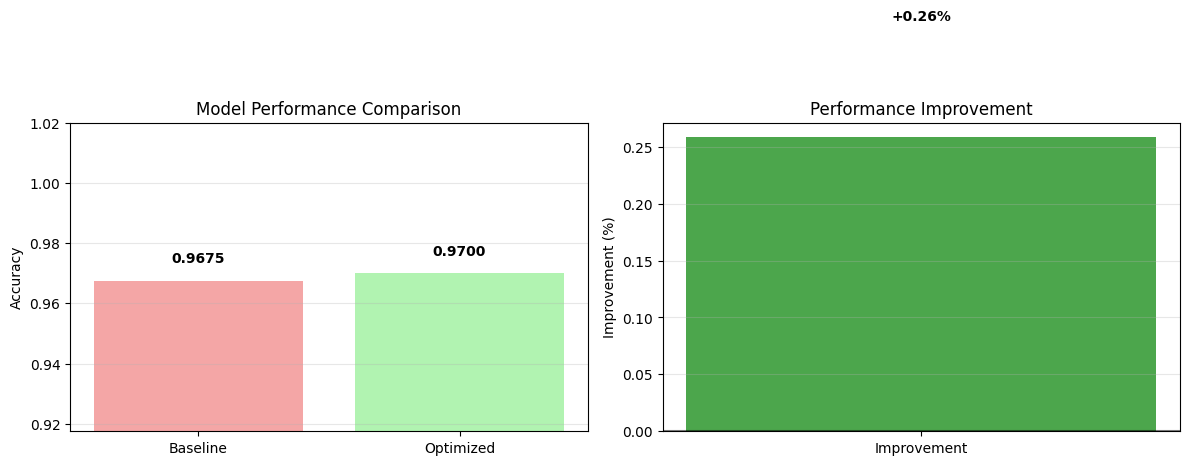

In [53]:
print("\n" + "="*80)
print("Baseline Vs Optimized Model Comparision")
print("="*80)

# Compare baseline vs optimized model
compare_baseline_vs_optimized(valid_accuracy, optimized_valid_accuracy, baseline_params, best_params)

## RandomForest Model Evaluation

In [54]:
def evaluate_random_forest_model(model, scaler, X_test_features, y_test, feature_names):
    '''
    Evaluate Random Forest model on test set
    '''
    # Scale test features
    X_test_scaled = scaler.transform(X_test_features)

    # Make predictions
    y_test_pred = model.predict(X_test_scaled)
    y_test_proba = model.predict_proba(X_test_scaled)

    # Classification report
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Test Confusion Matrix (Optimized Model)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig("images/rf_confusion_matrix.png")
    plt.show()

    # Per-class accuracy
    print("\nPer-class Accuracy:")
    for i, class_name in enumerate(class_names):
        class_mask = (y_test == i)
        if np.sum(class_mask) > 0:
            class_accuracy = accuracy_score(y_test[class_mask], y_test_pred[class_mask])
            print(f"  {class_name}: {class_accuracy:.4f} ({np.sum(class_mask)} samples)")

    return test_accuracy, y_test_pred, y_test_proba

In [55]:
def analyze_prediction_errors(X_test, y_test, y_pred, y_proba, num_samples=8):
    '''
    Analyze and visualize prediction errors
    '''
    print("="*60)
    print("Analyzing Prediction Errors")
    print("="*60)

    # Find misclassified samples
    misclassified_mask = (y_test != y_pred)
    misclassified_indices = np.where(misclassified_mask)[0]

    if len(misclassified_indices) == 0:
        print("No misclassifications found!")
        return

    print(f"Found {len(misclassified_indices)} misclassified samples out of {len(y_test)}")

    # Select random misclassified samples for visualization
    sample_indices = np.random.choice(misclassified_indices,
                                     min(num_samples, len(misclassified_indices)),
                                     replace=False)

    # Visualize misclassified samples
    rows = (num_samples + 3) // 4
    cols = min(4, num_samples)
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(sample_indices):
        row = i // cols
        col = i % cols

        # Display image
        axes[row, col].imshow(X_test[idx])
        axes[row, col].set_title(
            f'True: {class_names[y_test[idx]]}\n'
            f'Pred: {class_names[y_pred[idx]]}\n'
            f'Conf: {y_proba[idx, y_pred[idx]]:.3f}'
        )
        axes[row, col].axis('off')

    # Hide unused subplots
    for i in range(len(sample_indices), rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')

    plt.suptitle('Misclassified Samples (Optimized Model)', fontsize=16)
    plt.tight_layout()
    plt.savefig("images/rf_prediction_errors_analysis.png")
    plt.show()

    # Analyze error patterns
    error_analysis = {}
    for true_class in range(NUM_CLASSES):
        for pred_class in range(NUM_CLASSES):
            if true_class != pred_class:
                mask = (y_test == true_class) & (y_pred == pred_class)
                count = np.sum(mask)
                if count > 0:
                    error_analysis[f'{class_names[true_class]} → {class_names[pred_class]}'] = count

    if error_analysis:
        print("\nMost Common Error Patterns:")
        sorted_errors = sorted(error_analysis.items(), key=lambda x: x[1], reverse=True)
        for pattern, count in sorted_errors[:5]:
            print(f"  {pattern}: {count} cases")


RandomForest Model Evaluation

Test Classification Report:
              precision    recall  f1-score   support

    AIRPLANE       0.98      0.93      0.95        87
       DRONE       1.00      1.00      1.00       153
  HELICOPTER       0.93      1.00      0.96        80
        BIRD       1.00      0.97      0.99        80

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



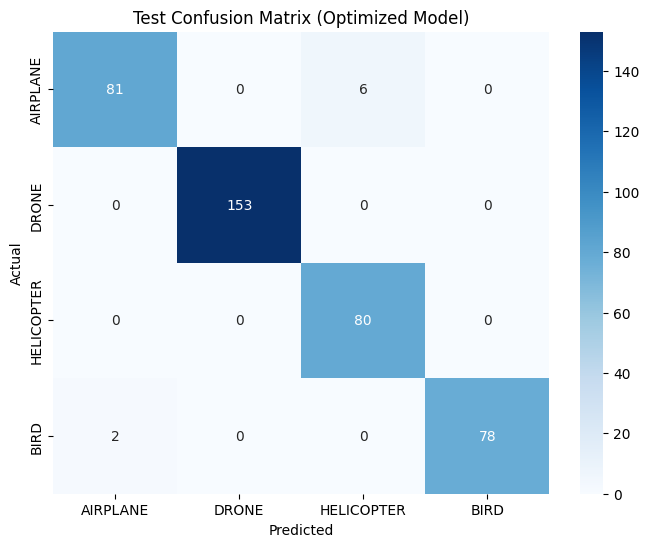


Per-class Accuracy:
  AIRPLANE: 0.9310 (87 samples)
  DRONE: 1.0000 (153 samples)
  HELICOPTER: 1.0000 (80 samples)
  BIRD: 0.9750 (80 samples)
Optimized Random Forest Test Accuracy: 0.9725
Analyzing Prediction Errors
Found 8 misclassified samples out of 400


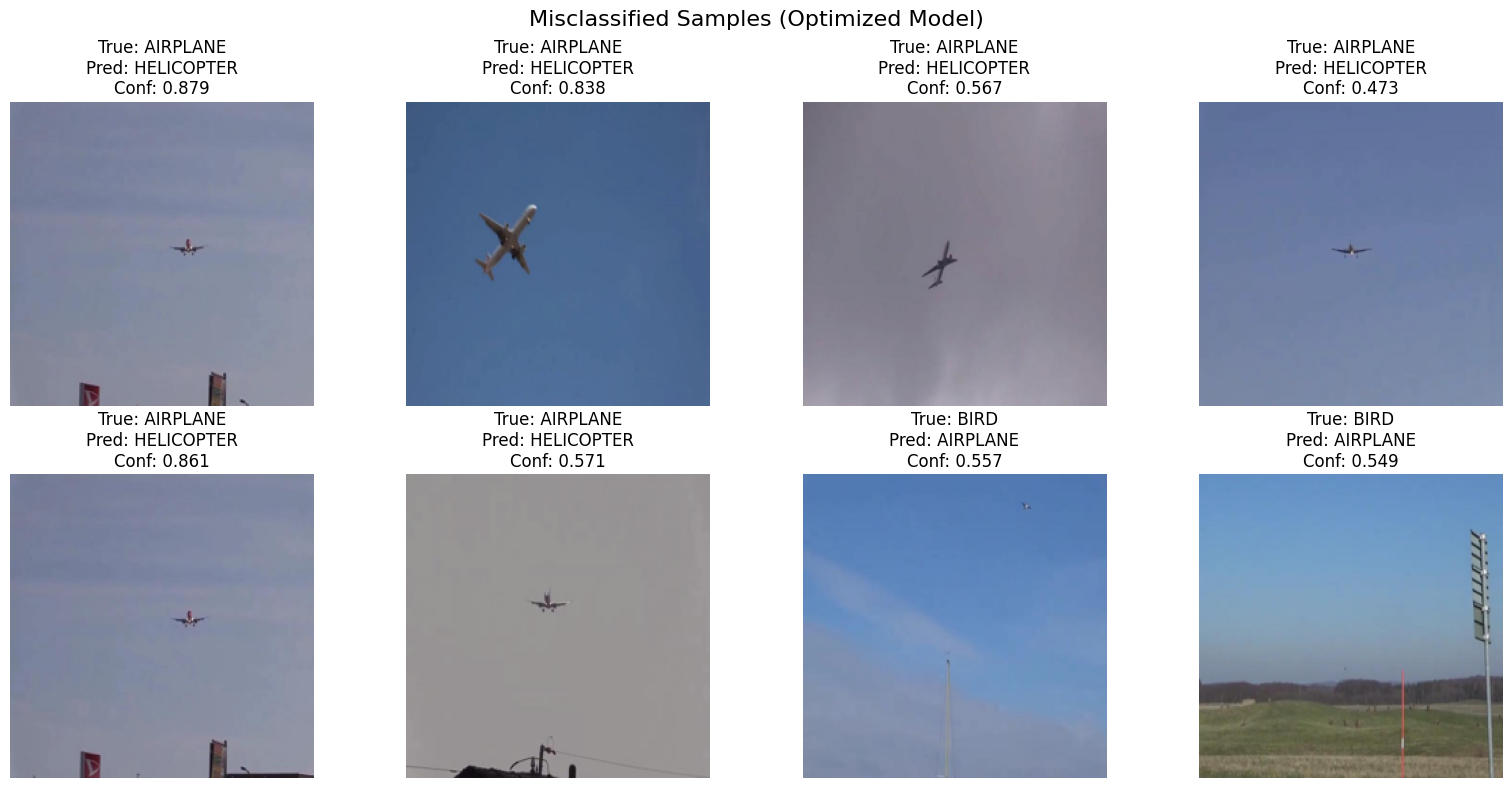


Most Common Error Patterns:
  AIRPLANE → HELICOPTER: 6 cases
  BIRD → AIRPLANE: 2 cases


In [56]:
print("\n" + "="*80)
print("RandomForest Model Evaluation")
print("="*80)

# Evaluate on test set
if X_test_features is not None and len(X_test_cls) > 0:
    test_accuracy, y_test_pred, y_test_proba = evaluate_random_forest_model(
        optimized_rf, optimized_scaler, X_test_features, y_test_cls, feature_names
    )

    print(f"Optimized Random Forest Test Accuracy: {test_accuracy:.4f}")

    # Analyze prediction errors
    analyze_prediction_errors(X_test_cls, y_test_cls, y_test_pred, y_test_proba)

else:
    test_accuracy = optimized_valid_accuracy
    y_test_pred = None
    y_test_proba = None
    print("Using validation accuracy as final score (no test set available)")

## Concolutional Neural Networks (CNNs) Model Training

In [57]:
def create_classification_model(input_shape=(224, 224, 3), num_classes=4):
    '''
    Create a classification model
    '''
    model = Sequential([
        InputLayer(input_shape=input_shape),

        # Feature extraction
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Global average pooling
        tf.keras.layers.GlobalAveragePooling2D(),

        # Dense layers
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    return model

In [58]:
def train_classification_model(X_train, y_train, X_val=None, y_val=None, X_test=None, y_test=None):
    '''
    Train classification model
    '''
    print("="*60)
    print("Training CNN Classification Model")
    print("="*60)

    model = create_classification_model()

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Print model summary
    model.summary()

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
        ModelCheckpoint('best_classification_model.h5', save_best_only=True, monitor='val_loss')
    ]

    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Classes distribution in training: {Counter(y_train)}")

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
    training_accuracy = record_performance_metrics('train', model, X_train, y_train, model_name='cnn')
    if X_val is not None and len(X_val) > 0:
      validation_accuracy = record_performance_metrics('valid', model, X_val, y_val, model_name='cnn')
      print(f"Validation Accuracy - CNN: {validation_accuracy:.4f}")
    if X_test is not None and len(X_test) > 0:
      test_accuracy = record_performance_metrics('test', model, X_test, y_test, model_name='cnn')
      print(f"Test Accuracy - CNN: {test_accuracy:.4f}")

    print(f"Training Accuracy - CNN: {training_accuracy:.4f}")


    return model, history

In [59]:
def plot_training_history(history, title="Training History", filename='cnn_training_history'):
    '''
    Plot training history
    '''
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot accuracy (if available)
    if 'accuracy' in history.history:
        axes[1].plot(history.history['accuracy'], label='Training Accuracy')
        axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[1].set_title('Model Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].grid(True)
    else:
        # Plot MAE for detection model
        if 'mae' in history.history:
            axes[1].plot(history.history['mae'], label='Training MAE')
            axes[1].plot(history.history['val_mae'], label='Validation MAE')
            axes[1].set_title('Model MAE')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('MAE')
            axes[1].legend()
            axes[1].grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(f"images/{filename}.png")
    plt.show()

In [60]:
def evaluate_classification_model(model, X_test, y_test, filename="cnn_confusion_matrix"):
    '''
    Evaluate classification model
    '''
    print("="*60)
    print("Evaluating CNN Classfication Model")
    print("="*60)

    # Make predictions
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)

    # Calculate accuracy
    accuracy = np.mean(predicted_classes == y_test)
    print(f"Test Accuracy: {accuracy:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, predicted_classes, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, predicted_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f"images/{filename}.png")
    plt.show()

    return accuracy

## Train classification model on original data


Starting classification model training on original data...
Training CNN Classification Model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 654,276 (2.50 MB)

 Trainable params: 653,316 (2.49 MB)

 Non-trainable params: 960 (3.75 KB)

Training samples: 2000
Validation samples: 400
Classes distribution in training: Counter({np.int64(1): 815, np.int64(2): 425, np.int64(0): 393, np.int64(3): 367})
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.5819 - loss: 1.0391

63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 265ms/step - accuracy: 0.5831 - loss: 1.0363 - val_accuracy: 0.2150 - val_loss: 2.2607 - learning_rate: 0.0010
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7373 - loss: 0.6272 - val_accuracy: 0.2725 - val_loss: 2.5606 - learning_rate: 0.0010
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7886 - loss: 0.5239 - val_accuracy: 0.3275 - val_loss: 3.6796 - learning_rate: 0.0010
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8273 - loss: 0.4106 - val_accuracy: 0.2500 - val_loss: 2.8065 - learning_rate: 0.0010
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8586 - loss: 0.3421 - val_accuracy: 0.2500 - val_loss: 3.0470 - learning_rate: 0.0010
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8792 - loss: 0.3086 - val_accuracy: 0.3725 - val_loss: 3.0695 - learning_rate: 0.0010
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8963 - loss: 0.2484

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8964 - loss: 0.2483 - val_accuracy: 0.4550 - val_loss: 2.1293 - learning_rate: 5.0000e-04
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9012 - loss: 0.2313 - val_accuracy: 0.3575 - val_loss: 2.9088 - learning_rate: 5.0000e-04
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9097 - loss: 0.2122

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9097 - loss: 0.2123 - val_accuracy: 0.5250 - val_loss: 1.9363 - learning_rate: 5.0000e-04
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9229 - loss: 0.2002

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9228 - loss: 0.2004 - val_accuracy: 0.8100 - val_loss: 0.4014 - learning_rate: 5.0000e-04
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
Recording Performance Metrics for CNN:

Training Accuracy: 0.8585
Training MSE: 0.7310
Training MAE: 0.0772
Training Precision: 0.8815
Training Recall: 0.8585
Training F1 Score: 0.8618
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Recording Performance Metrics for CNN:

Validation Accuracy: 0.8100
Validation MSE: 1.0125
Validation MAE: 0.1210
Validation Precision: 0.8395
Validation Recall: 0.8100
Validation F1 Score: 0.8155
Validation Accuracy - CNN: 0.8100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Recording Performance Metrics for CNN:
\Test Accuracy: 0.8525
Test MSE: 0.8175
Test MAE: 0.1451
Test Precision: 0.8749
Test Recall: 0.8525
Test F1 Score: 0.8546
Test Accuracy - CNN: 0.8525
Training Accuracy - CNN: 0.8585


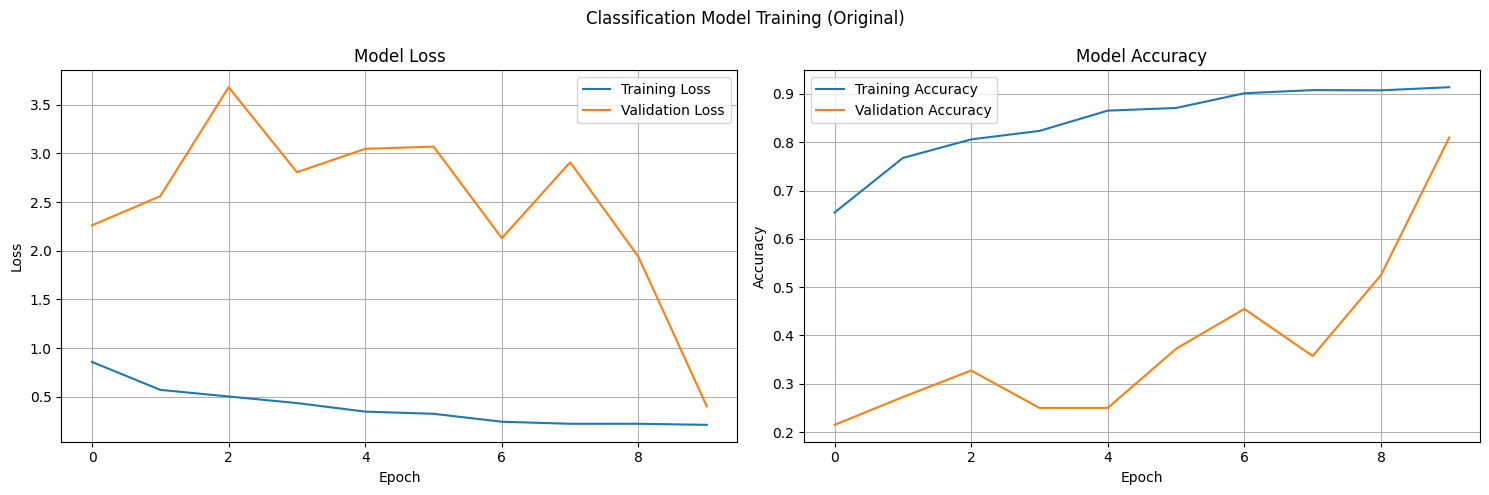

Evaluating CNN Classfication Model
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Test Accuracy: 0.8525

Classification Report:
              precision    recall  f1-score   support

    AIRPLANE       0.64      0.85      0.73        87
       DRONE       0.99      1.00      0.99       153
  HELICOPTER       0.79      0.74      0.76        80
        BIRD       1.00      0.69      0.81        80

    accuracy                           0.85       400
   macro avg       0.85      0.82      0.83       400
weighted avg       0.87      0.85      0.85       400



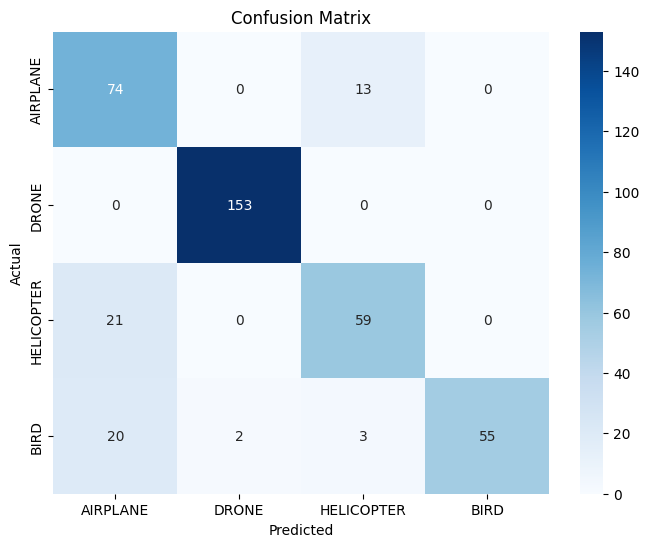

Final Classification Test Accuracy (Original): 0.8525
CPU times: user 1min 26s, sys: 4.28 s, total: 1min 30s
Wall time: 1min 7s


In [61]:
%%time
# Train classification model on original data
def train_classification_model_original(X_train, y_train, X_val=None, y_val=None):
    '''
    Train classification model on original data
    '''
    print("\nStarting classification model training on original data...")
    try:
        if X_val is not None:
          X_val_cls, y_val_cls = create_classification_data(X_val, Y_val)
        cls_model, cls_history = train_classification_model(
            X_train_cls, y_train_cls, X_val_cls, y_val_cls, X_test_cls, y_test_cls
        )

        # Plot training history
        plot_training_history(cls_history, "Classification Model Training (Original)")

        # Evaluate on test set
        if X_test_cls is not None and len(X_test_cls) > 0:
            accuracy_original = evaluate_classification_model(cls_model, X_test_cls, y_test_cls)
            print(f"Final Classification Test Accuracy (Original): {accuracy_original:.4f}")
        return cls_model, cls_history
    except Exception as e:
        print(f"Error during classification training: {e}")
        import traceback
        traceback.print_exc()
        cls_model = None

cnn_start_time = time.time()
cls_model, cls_history = train_classification_model_original(X_train_cls, y_train_cls, X_val_cls, y_val_cls)
cnn_end_time = time.time()
model_training_time.append(cnn_end_time - cnn_start_time)

## Train Classification Model Denoised


Starting classification model training on denoised data...
Training CNN Classification Model


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 654,276 (2.50 MB)

 Trainable params: 653,316 (2.49 MB)

 Non-trainable params: 960 (3.75 KB)

Training samples: 2000
Validation samples: 400
Classes distribution in training: Counter({np.int64(1): 815, np.int64(2): 425, np.int64(0): 393, np.int64(3): 367})
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5762 - loss: 1.0736

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 0.5772 - loss: 1.0709 - val_accuracy: 0.2150 - val_loss: 2.0511 - learning_rate: 0.0010
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7425 - loss: 0.6117 - val_accuracy: 0.2150 - val_loss: 2.7990 - learning_rate: 0.0010
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7804 - loss: 0.5547 - val_accuracy: 0.2550 - val_loss: 2.9507 - learning_rate: 0.0010
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8318 - loss: 0.4542 - val_accuracy: 0.2575 - val_loss: 2.8637 - learning_rate: 0.0010
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8545 - loss: 0.3872 - val_accuracy: 0.2625 - val_loss: 3.0840 - learning_rate: 0.0010
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8629 - loss: 0.3537 - val_accuracy: 0.2925 - val_loss: 2.8203 - learning_rate: 0.0010
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8980 - loss: 0.2481 - val_accuracy: 0.

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8960 - loss: 0.2678 - val_accuracy: 0.5075 - val_loss: 1.1983 - learning_rate: 5.0000e-04
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8905 - loss: 0.2717 - val_accuracy: 0.5150 - val_loss: 1.4343 - learning_rate: 5.0000e-04
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9105 - loss: 0.2309

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9105 - loss: 0.2306 - val_accuracy: 0.7375 - val_loss: 0.6182 - learning_rate: 5.0000e-04
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Recording Performance Metrics for CNN:

Training Accuracy: 0.7425
Training MSE: 0.8610
Training MAE: 0.1746
Training Precision: 0.8099
Training Recall: 0.7425
Training F1 Score: 0.7411
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Recording Performance Metrics for CNN:

Validation Accuracy: 0.7375
Validation MSE: 0.9425
Validation MAE: 0.2017
Validation Precision: 0.7939
Validation Recall: 0.7375
Validation F1 Score: 0.7315
Validation Accuracy - CNN: 0.7375
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Recording Performance Metrics for CNN:
\Test Accuracy: 0.7350
Test MSE: 0.9550
Test MAE: 0.2241
Test Precision: 0.7948
Test Recall: 0.7350
Test F1 Score: 0.7347
Test Accuracy - CNN: 0.7350
Training Accuracy - CNN: 0.7425


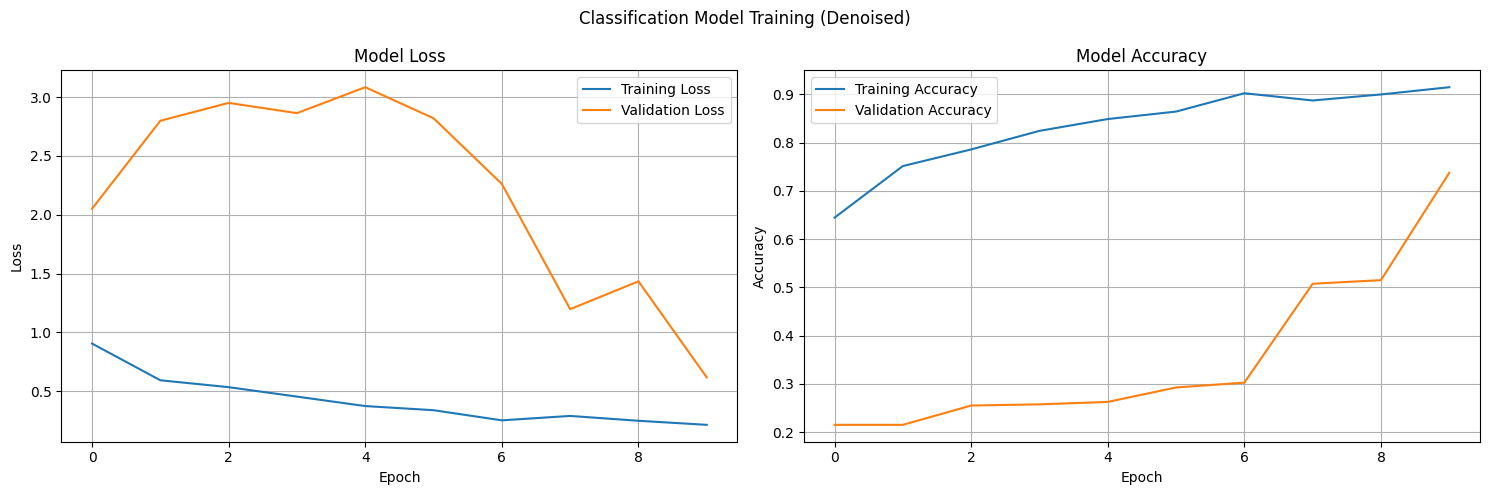

Evaluating CNN Classfication Model
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Test Accuracy: 0.7350

Classification Report:
              precision    recall  f1-score   support

    AIRPLANE       0.57      0.79      0.66        87
       DRONE       1.00      0.56      0.72       153
  HELICOPTER       0.79      0.95      0.86        80
        BIRD       0.65      0.79      0.71        80

    accuracy                           0.73       400
   macro avg       0.75      0.77      0.74       400
weighted avg       0.79      0.73      0.73       400



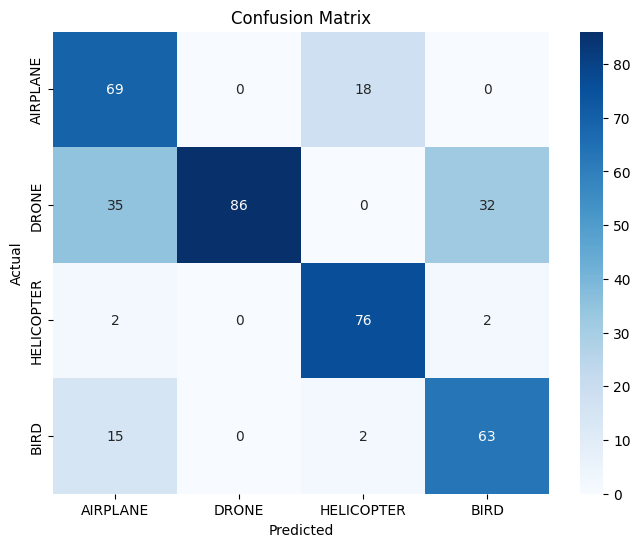

Final Classification Test Accuracy (Denoised): 0.7350
CPU times: user 35.1 s, sys: 3.63 s, total: 38.7 s
Wall time: 52.1 s


In [62]:
%%time
# Train classification model on denoised data
def train_classification_model_denoised(X_train_denoised, y_train):
    '''
    Train classification model on denoised data
    '''
    print("\nStarting classification model training on denoised data...")
    try:
      # Evaluate on test set
        if X_test_cls is not None and len(X_test_cls) > 0:
            # Apply denoising to test set
            X_test_denoised = np.zeros_like(X_test_cls)
            for i in range(len(X_test_cls)):
                img_uint8 = (X_test_cls[i] * 255).astype(np.uint8)
                blurred = cv2.GaussianBlur(img_uint8, (3, 3), 0)
                X_test_denoised[i] = blurred / 255.0

        cls_model_denoised, cls_history_denoised = train_classification_model(
            X_train_denoised, y_train_cls, X_val_denoised, y_val_cls, X_test_denoised, y_test_cls
        )

        # Plot training history
        plot_training_history(cls_history_denoised, "Classification Model Training (Denoised)", "cnn_denoised_training_history")

        accuracy_denoised = evaluate_classification_model(cls_model_denoised, X_test_denoised, y_test_cls, "cnn_denoised_confusion_matrix")
        print(f"Final Classification Test Accuracy (Denoised): {accuracy_denoised:.4f}")

        return cls_model_denoised, cls_history_denoised
    except Exception as e:
        print(f"Error during denoised classification training: {e}")
        import traceback
        traceback.print_exc()
        cls_model_denoised = None

cnn_denoised_start_time = time.time()
cls_model_denoised, cls_history_denoised = train_classification_model_denoised(X_train_denoised, y_train_cls)
cnn_denoised_end_time = time.time()
model_training_time.append(cnn_denoised_end_time - cnn_denoised_start_time)

## Train Detection Model

In [63]:
# Model creation functions (keeping original functions)
def create_detection_model(input_shape=(224, 224, 3), num_classes=4, max_boxes=10):
    '''
    Create a simplified detection model that predicts class + bounding box for multiple objects
    '''
    inputs = Input(shape=input_shape)

    # Feature extraction backbone
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Dense layers
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer for multiple object detection
    # Output shape: (batch_size, max_boxes * 5) where each box has [class, x, y, w, h]
    x = Dense(max_boxes * 5, activation='linear')(x)

    # Reshape to (batch_size, max_boxes, 5)
    outputs = Reshape((max_boxes, 5), name='detection_output')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [64]:
def visualize_detection_predictions(X_test, Y_true, Y_pred, num_samples=12):
    '''
    Visualize detection predictions
    '''
    fig, axes = plt.subplots(4, 3, figsize=(18, 12))
    fig.suptitle('Detection Model Predictions vs Ground Truth', fontsize=16, fontweight='bold')
    axes = axes.flatten()

    # Select random samples
    indices = np.random.choice(len(X_test), min(num_samples, len(X_test)), replace=False)

    for i, idx in enumerate(indices):
        if i >= num_samples:
            break

        img = X_test[idx]
        true_boxes = Y_true[idx]
        pred_boxes = Y_pred[idx]

        # Display image
        axes[i].imshow(img)
        axes[i].set_title(f'Image {idx}')
        axes[i].axis('off')

        img_height, img_width = img.shape[:2]

        # Draw ground truth boxes in blue
        for j, box in enumerate(true_boxes):
            if np.sum(np.abs(box)) > 0:  # Valid box
                class_id, x_center, y_center, width, height = box

                # Convert to pixel coordinates
                x_center *= img_width
                y_center *= img_height
                width *= img_width
                height *= img_height

                # Calculate top-left corner
                x1 = x_center - width / 2
                y1 = y_center - height / 2

                # Draw ground truth rectangle (blue)
                rect = Rectangle((x1, y1), width, height,
                               linewidth=2, edgecolor='blue', facecolor='none')
                axes[i].add_patch(rect)

                # Add class label
                if int(class_id) < len(class_names):
                    axes[i].text(x1, y1-5, f'GT: {class_names[int(class_id)]}',
                               color='blue', fontsize=8, fontweight='bold',
                               bbox=dict(facecolor='white', alpha=0.8, pad=1))

        # Draw predicted boxes in red
        for j, box in enumerate(pred_boxes):
            if np.sum(np.abs(box)) > 0.1:  # Valid prediction (threshold)
                class_id, x_center, y_center, width, height = box

                # Convert to pixel coordinates
                x_center *= img_width
                y_center *= img_height
                width *= img_width
                height *= img_height

                # Calculate top-left corner
                x1 = x_center - width / 2
                y1 = y_center - height / 2

                # Draw prediction rectangle (red)
                rect = Rectangle((x1, y1), width, height,
                               linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
                axes[i].add_patch(rect)

                # Add class label
                pred_class = int(np.round(class_id))
                if 0 <= pred_class < len(class_names):
                    axes[i].text(x1, y1+height+5, f'Pred: {class_names[pred_class]}',
                               color='red', fontsize=8, fontweight='bold',
                               bbox=dict(facecolor='white', alpha=0.8, pad=1))

    plt.tight_layout()
    plt.savefig("images/detection_predictions.png")
    plt.show()

In [65]:
def evaluate_detection_model(model, X_test, Y_test):
    '''
    Evaluate detection model
    '''
    print("="*60)
    print("Evaluating Detection Model")
    print("="*60)

    # Make predictions
    predictions = model.predict(X_test)

    # Calculate various metrics
    mae = mae_loss(Y_test, predictions)
    mse = mse_loss(Y_test, predictions)

    print(f"Test MAE: {tf.reduce_mean(mae):.4f}")
    print(f"Test MSE: {tf.reduce_mean(mse):.4f}")

    # Visualize some predictions
    visualize_detection_predictions(X_test, Y_test, predictions, num_samples=12)

    return tf.reduce_mean(mae).numpy()

In [66]:
def detection_loss(y_true, y_pred):
    '''
    Detection loss using MSE
    '''
    # Calculate MSE loss between predictions and ground truth
    loss = mse_loss(y_true, y_pred)

    # Create mask for valid boxes
    valid_mask = tf.reduce_sum(tf.abs(y_true), axis=-1) > 0
    valid_mask_float = tf.cast(valid_mask, tf.float32)

    # Apply mask and return mean loss
    masked_loss = loss * valid_mask_float

    # Calculate mean only over valid samples
    num_valid = tf.reduce_sum(valid_mask_float, axis=-1)
    num_valid = tf.maximum(num_valid, 1.0)

    sample_loss = tf.reduce_sum(masked_loss, axis=-1) / num_valid

    return tf.reduce_mean(sample_loss)

In [67]:
def train_detection_model(X_train, Y_train, X_val, Y_val):
    '''
    Train detection model
    '''
    print("="*60)
    print("TRAINING DETECTION MODEL")
    print("="*60)

    model = create_detection_model()

    # Compile model with simplified loss
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
        loss=detection_loss,
        metrics=['accuracy', 'mse', 'mae']
    )

    # Print model summary
    model.summary()

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-8),
        ModelCheckpoint('best_detection_model.h5', save_best_only=True, monitor='val_loss')
    ]

    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Input shape: {X_train.shape}")
    print(f"Output shape: {Y_train.shape}")

    # Train model
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=EPOCHS,
        batch_size=SMALL_BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
    return model, history

In [68]:
%%time
# Train and evaluate detection model (simplified)
def train_and_evaluate_detection_model(X_train, Y_train, X_val, Y_val):
    '''
    Train detection model (simplified)
    '''
    print("\nStarting detection model training...")
    try:
        det_model, det_history = train_detection_model(
            X_train, Y_train, X_val, Y_val
        )

        return det_model, det_history
    except Exception as e:
        print(f"Error during detection training: {e}")
        import traceback
        traceback.print_exc()
        det_model = None

cnn_detection_start_time = time.time()
det_model, det_history = train_and_evaluate_detection_model(X_train, Y_train, X_val, Y_val)
cnn_detection_end_time = time.time()
# model_training_time.append(cnn_detection_end_time - cnn_detection_start_time)


Starting detection model training...
TRAINING DETECTION MODEL


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │        12,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ detection_output (Reshape)      │ (None, 10, 5)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 666,098 (2.54 MB)

 Trainable params: 665,138 (2.54 MB)

 Non-trainable params: 960 (3.75 KB)

Training samples: 2000
Validation samples: 400
Input shape: (2000, 224, 224, 3)
Output shape: (2000, 10, 5)
Epoch 1/10
246/250 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2020 - loss: 0.1348 - mae: 0.2343 - mse: 0.1348

250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.2027 - loss: 0.1337 - mae: 0.2329 - mse: 0.1337 - val_accuracy: 0.2433 - val_loss: 0.0715 - val_mae: 0.1644 - val_mse: 0.0715 - learning_rate: 1.0000e-04
Epoch 2/10
246/250 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2640 - loss: 0.0334 - mae: 0.1032 - mse: 0.0334

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2642 - loss: 0.0333 - mae: 0.1031 - mse: 0.0333 - val_accuracy: 0.2110 - val_loss: 0.0395 - val_mae: 0.1024 - val_mse: 0.0395 - learning_rate: 1.0000e-04
Epoch 3/10
246/250 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2775 - loss: 0.0279 - mae: 0.0866 - mse: 0.0279

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2774 - loss: 0.0279 - mae: 0.0865 - mse: 0.0279 - val_accuracy: 0.2372 - val_loss: 0.0198 - val_mae: 0.0421 - val_mse: 0.0198 - learning_rate: 1.0000e-04
Epoch 4/10
246/250 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2721 - loss: 0.0247 - mae: 0.0793 - mse: 0.0247

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2721 - loss: 0.0247 - mae: 0.0793 - mse: 0.0247 - val_accuracy: 0.3265 - val_loss: 0.0166 - val_mae: 0.0370 - val_mse: 0.0166 - learning_rate: 1.0000e-04
Epoch 5/10
246/250 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2765 - loss: 0.0216 - mae: 0.0720 - mse: 0.0216

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2765 - loss: 0.0216 - mae: 0.0719 - mse: 0.0216 - val_accuracy: 0.3460 - val_loss: 0.0153 - val_mae: 0.0351 - val_mse: 0.0153 - learning_rate: 1.0000e-04
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2782 - loss: 0.0206 - mae: 0.0672 - mse: 0.0206 - val_accuracy: 0.3335 - val_loss: 0.0191 - val_mae: 0.0397 - val_mse: 0.0191 - learning_rate: 1.0000e-04
Epoch 7/10
246/250 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2826 - loss: 0.0187 - mae: 0.0622 - mse: 0.0187

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2826 - loss: 0.0187 - mae: 0.0622 - mse: 0.0187 - val_accuracy: 0.2718 - val_loss: 0.0148 - val_mae: 0.0340 - val_mse: 0.0148 - learning_rate: 1.0000e-04
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2810 - loss: 0.0182 - mae: 0.0596 - mse: 0.0182 - val_accuracy: 0.3922 - val_loss: 0.0153 - val_mae: 0.0324 - val_mse: 0.0153 - learning_rate: 1.0000e-04
Epoch 9/10
246/250 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2859 - loss: 0.0178 - mae: 0.0581 - mse: 0.0178

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2859 - loss: 0.0178 - mae: 0.0581 - mse: 0.0178 - val_accuracy: 0.2777 - val_loss: 0.0136 - val_mae: 0.0302 - val_mse: 0.0136 - learning_rate: 1.0000e-04
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2788 - loss: 0.0157 - mae: 0.0547 - mse: 0.0157 - val_accuracy: 0.3142 - val_loss: 0.0140 - val_mae: 0.0289 - val_mse: 0.0140 - learning_rate: 1.0000e-04
CPU times: user 1min 1s, sys: 2.58 s, total: 1min 3s
Wall time: 48.2 s


### Plot detection model training history

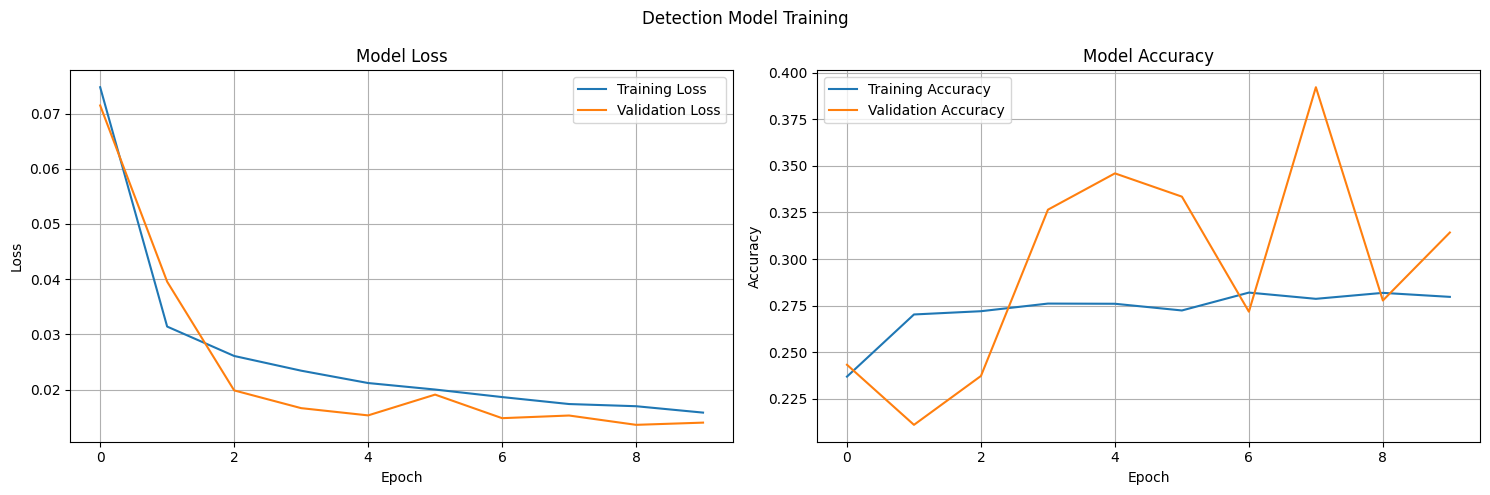

In [69]:
plot_training_history(det_history, "Detection Model Training", "cnn_detection_training_history")

### Evaluate detection model

Evaluating Detection Model
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step
Test MAE: 0.0351
Test MSE: 0.0135


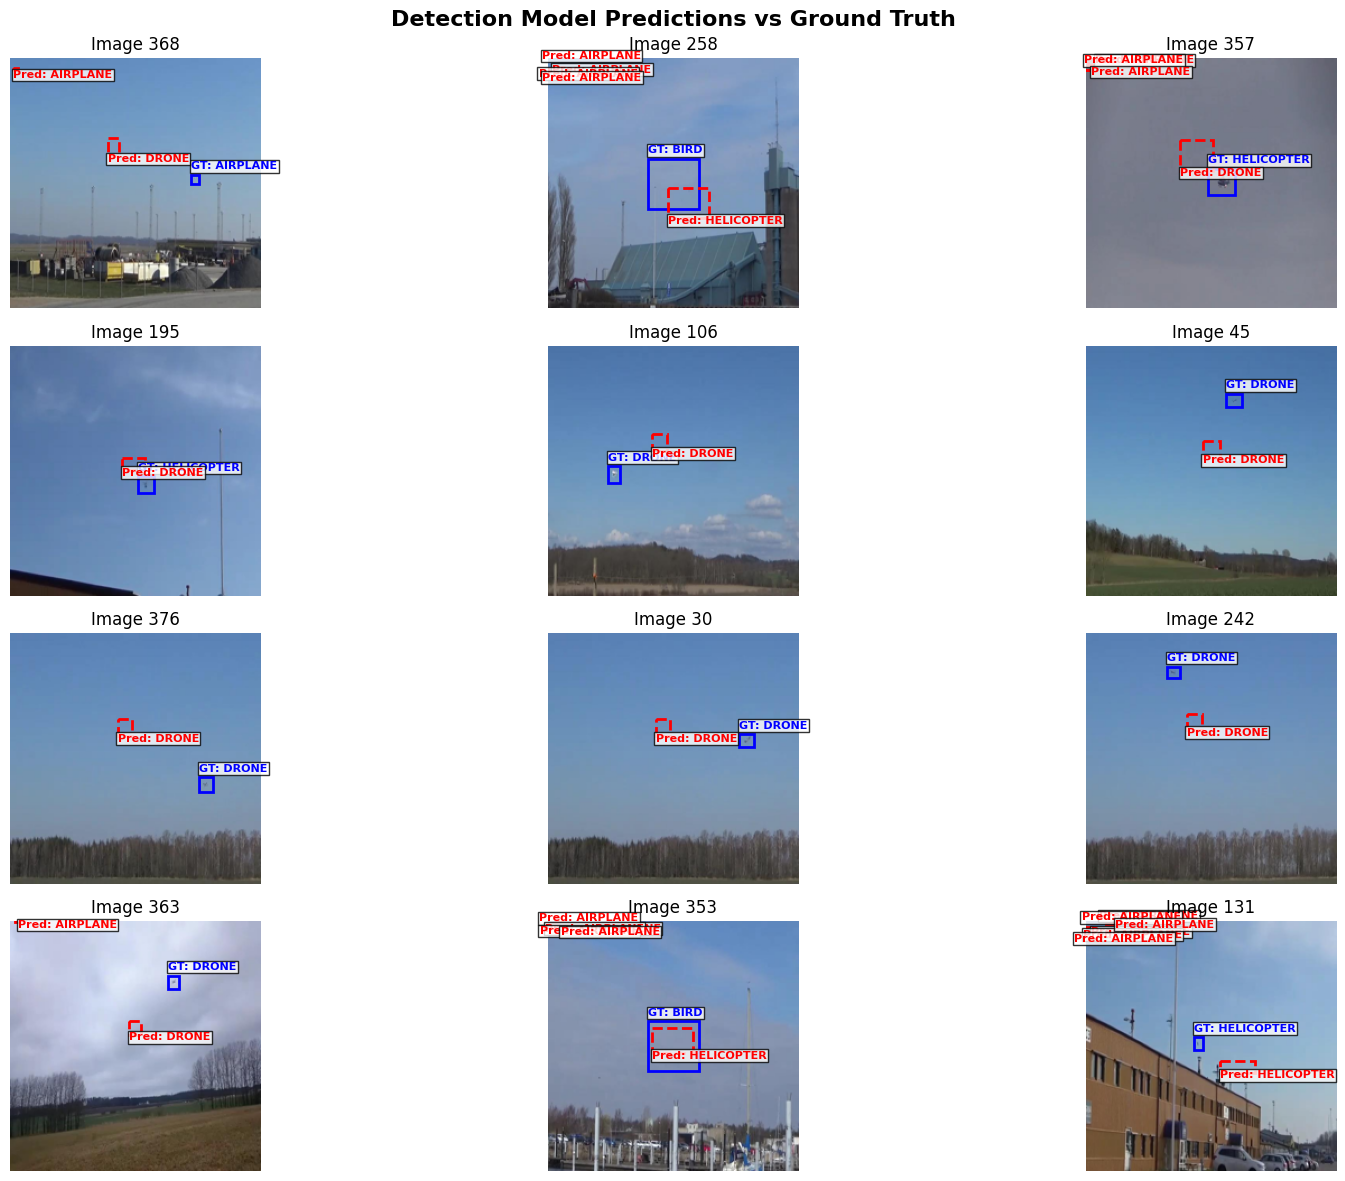

Final Detection Test MAE: 0.0351


In [70]:
# Evaluate on test set
if X_test is not None and len(X_test) > 0:
    mae = evaluate_detection_model(det_model, X_test, Y_test)
    print(f"Final Detection Test MAE: {mae:.4f}")

In [76]:
print(f"🕒 Base Model Training Duration (seconds): {(rf_base_end_time - rf_base_start_time):.2f}")
print(f"🕒 GridSearch + RandomForest Model Training Duration (seconds): {(rf_grid_end_time - rf_grid_start_time):.2f}")
print(f"🕒 RandomForest Optimized Training Duration (seconds): {(rf_opti_end_time - rf_opti_start_time):.2f}")

print(f"🕒 CNN Model Training Duration (seconds): {(cnn_end_time - cnn_start_time):.2f}")
print(f"🕒 CNN Denoised Model Training Duration (seconds): {(cnn_denoised_end_time - cnn_denoised_start_time):.2f}")
print(f"🕒 CNN Detection Model Training Duration (seconds): {(cnn_detection_end_time - cnn_detection_start_time):.2f}")

score_df = pd.DataFrame(index = [
        'RandomForestClassifier',
        'Optimized RandomForest',
        'CNN',
        'CNN Denoised'
    ], columns = [
        'Train Time (Seconds)',
        'Accuracy Train', 'Accuracy Valid', 'Accuracy Test',
        'MSE Train', 'MSE Valid', 'MSE Test',
        'MAE Train', 'MAE Valid', 'MAE Test',
        'Precision Train', 'Precision Valid', 'Precision Test',
        'Recall Train', 'Recall Valid', 'Recall Test',
        'F1 Train', 'F1 Valid', 'F1 Test'])

score_df['Train Time (Seconds)'] = model_training_time[:-1]
score_df['Accuracy Train'] = acc_train_models
score_df['Accuracy Test'] = acc_test_models
score_df['Accuracy Valid'] = acc_val_models

score_df['MSE Train'] = mse_train_models
score_df['MSE Valid'] = mse_val_models
score_df['MSE Test'] = mse_test_models

score_df['MAE Train'] = mae_train_models
score_df['MAE Valid'] = mae_val_models
score_df['MAE Test'] = mae_test_models

score_df['Precision Train'] = precision_train_models
score_df['Precision Valid'] = precision_val_models
score_df['Precision Test'] = precision_test_models

score_df['Recall Train'] = recall_train_models
score_df['Recall Valid'] = recall_val_models
score_df['Recall Test'] = recall_test_models

score_df['F1 Train'] = f1_train_models
score_df['F1 Valid'] = f1_val_models
score_df['F1 Test'] = f1_test_models
score_df.T

🕒 Base Model Training Duration (seconds): 1.17
🕒 GridSearch + RandomForest Model Training Duration (seconds): 1418.24
🕒 RandomForest Optimized Training Duration (seconds): 1.05
🕒 CNN Model Training Duration (seconds): 67.99
🕒 CNN Denoised Model Training Duration (seconds): 52.06
🕒 CNN Detection Model Training Duration (seconds): 48.21


RandomForestClassifier  \
Train Time (Seconds)                                         1.165464   
Accuracy Train                                                    1.0   
Accuracy Valid                                                 0.9675   
Accuracy Test                                                  0.9725   
MSE Train                     tf.Tensor(0.0, shape=(), dtype=float32)   
MSE Valid                   tf.Tensor(0.135, shape=(), dtype=float32)   
MSE Test                    tf.Tensor(0.135, shape=(), dtype=float32)   
MAE Train                     tf.Tensor(0.0, shape=(), dtype=float32)   
MAE Valid                  tf.Tensor(0.0325, shape=(), dtype=float32)   
MAE Test              tf.Tensor(0.041666668, shape=(), dtype=float32)   
Precision Train                                                   1.0   
Precision Valid                                              0.967546   
Precision Test                                               0.973376   
Recall Train                                                      1.0   
Recall Valid                                                   0.9675   
Recall Test                                                    0.9725   
F1 Train                                                          1.0   
F1 Valid                                                     0.967472   
F1 Test                                                        0.9725   

                                               Optimized RandomForest  \
Train Time (Seconds)                                         1.052564   
Accuracy Train                                                    1.0   
Accuracy Valid                                                   0.97   
Accuracy Test                                                    0.98   
MSE Train                     tf.Tensor(0.0, shape=(), dtype=float32)   
MSE Valid                  tf.Tensor(0.1125, shape=(), dtype=float32)   
MSE Test                    tf.Tensor(0.105, shape=(), dtype=float32)   
MAE Train                 tf.Tensor(0.03125, shape=(), dtype=float32)   
MAE Valid                  tf.Tensor(0.0365, shape=(), dtype=float32)   
MAE Test              tf.Tensor(0.037916668, shape=(), dtype=float32)   
Precision Train                                                   1.0   
Precision Valid                                              0.970015   
Precision Test                                               0.980806   
Recall Train                                                      1.0   
Recall Valid                                                     0.97   
Recall Test                                                      0.98   
F1 Train                                                          1.0   
F1 Valid                                                     0.969913   
F1 Test                                                      0.980004   

                                                                  CNN  \
Train Time (Seconds)                                        67.988452   
Accuracy Train                                                 0.8585   
Accuracy Valid                                                   0.81   
Accuracy Test                                                  0.8525   
MSE Train                   tf.Tensor(0.731, shape=(), dtype=float32)   
MSE Valid                  tf.Tensor(1.0125, shape=(), dtype=float32)   
MSE Test                   tf.Tensor(0.8175, shape=(), dtype=float32)   
MAE Train             tf.Tensor(0.077214286, shape=(), dtype=float32)   
MAE Valid                   tf.Tensor(0.121, shape=(), dtype=float32)   
MAE Test               tf.Tensor(0.14505556, shape=(), dtype=float32)   
Precision Train                                              0.881461   
Precision Valid                                              0.839548   
Precision Test                                               0.874854   
Recall Train                                                   0.8585   
Recall Valid                  